Text(0, 0.5, 'number of pixels')

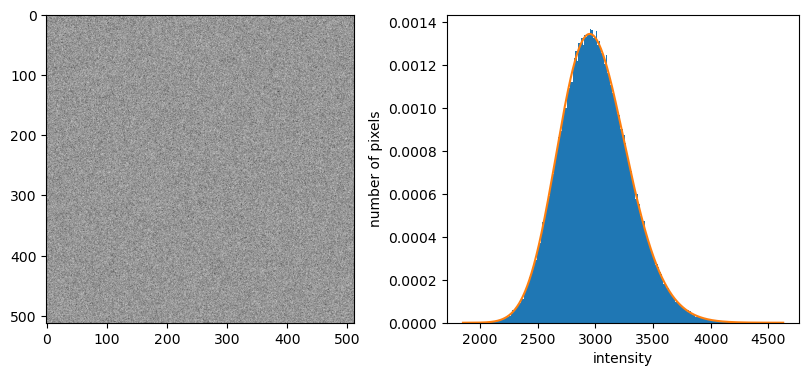

In [1]:
%matplotlib inline
import numpy as np
from numpy.random import default_rng
from scipy.stats import lognorm, norm, binom
from matplotlib import pyplot as plt
from skimage.feature import blob_log
from scipy.ndimage import gaussian_filter
from multiprocessing import Pool
from numba import jit, set_num_threads
from cmdstanpy import CmdStanModel
from itertools import combinations
import arviz as az
from os import environ

# setting number of cores for numba and multiprocessing (but not Stan)
num_cores = 4
set_num_threads(num_cores)

# setting number of threads used by each of 4 chains for Stan
num_threads_per_chain = 2

# sampling a background image with lognormally-distributed intensity
image_dims = (512, 512)
background_sigma = 0.1
background_mu = 8
rng = default_rng()
background = rng.lognormal(background_mu, background_sigma, image_dims)

f, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(background, cmap="binary")
_, bins, _ = axes[1].hist(background.flatten(), bins="auto", density=True)
xvals = np.linspace(bins[0], bins[-1], 10000)

axes[1].plot(xvals, lognorm.pdf(xvals, s=background_sigma, scale=np.exp(background_mu)))
axes[1].set_xlabel("intensity")
axes[1].set_ylabel("number of pixels")

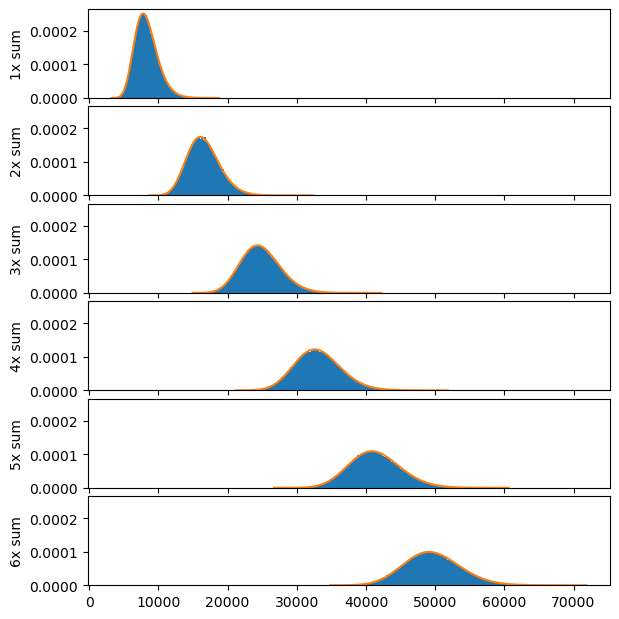

In [2]:
# basis for approximate RA method, showing scaling sigma by 1 / sqrt(n)
rng = default_rng()

mu = 9
sigma = 0.2

# approx "level 2"
# approximate sigma, moment-matched mu containing approximate sigma
f, axes = plt.subplots(6, figsize=(6, 6), sharex=True, sharey=True)
for n in range(1, 7):
    test = np.sum(rng.lognormal(mu, sigma, (100000, n)), axis=1)
    xvals = np.linspace(np.min(test), np.max(test), 10000)
    axes[n - 1].hist(test, bins="auto", density=True)
    axes[n - 1].plot(
        xvals,
        lognorm.pdf(
            xvals,
            s=sigma / np.sqrt(n),
            scale=np.exp(np.log(n) + mu + sigma**2 / 2 - sigma**2 / n / 2),
        ),
    )
    axes[n - 1].set_ylabel(str(n) + "x sum")
f.tight_layout(pad=0.0)

455


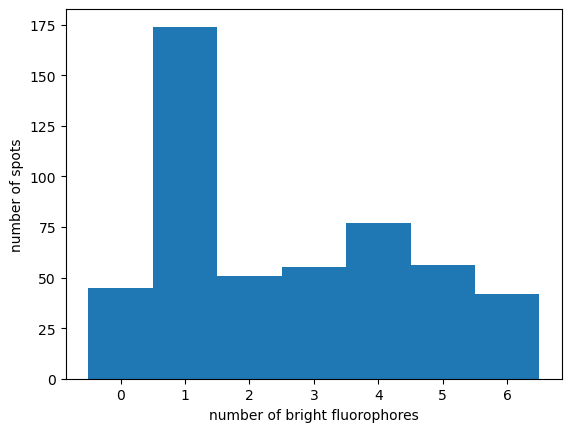

In [3]:
# sample binomially-distributed fluorophore distribution
num_spots = 500
spot_sigma = 1.2
monomer_sigma = 0.2
monomer_mu = 9.3
oligomeric_states = np.array([1, 2, 3, 4, 5, 6])
oligomeric_probabilities = np.array([0.4, 0.1, 0, 0.2, 0, 0.3])
fluorophore_bright_probability = 0.8

num_fluorophores = rng.choice(oligomeric_states, num_spots, p=oligomeric_probabilities)
num_bright_fluorophores = rng.binomial(num_fluorophores, fluorophore_bright_probability)

yvals_lower = np.arange(image_dims[0])
yvals_upper = np.arange(image_dims[0]) + 1.0
xvals_lower = np.arange(image_dims[1])
xvals_upper = np.arange(image_dims[1]) + 1.0

plt.hist(num_bright_fluorophores, bins=np.arange(np.max(oligomeric_states) + 2) - 0.5)
plt.xlabel("number of bright fluorophores")
plt.ylabel("number of spots")

print(np.sum(num_bright_fluorophores != 0))

Text(0.5, 1.0, 'true spot histogram')

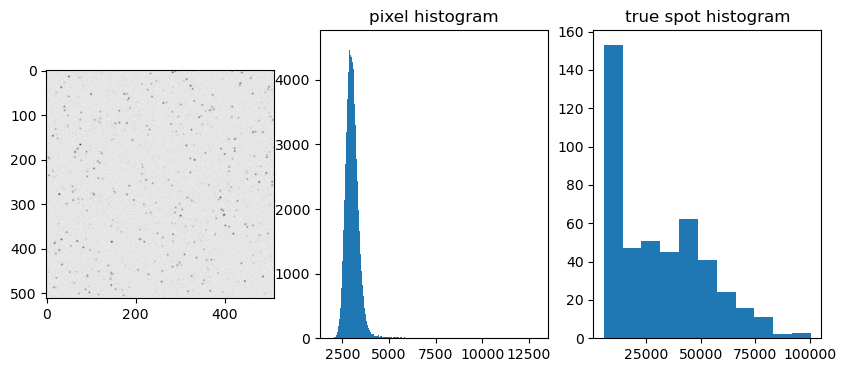

In [4]:
# MD
spot_images_md = np.zeros((num_spots, *image_dims))
intensities_md = rng.lognormal(
    (monomer_mu + np.log(num_bright_fluorophores[num_bright_fluorophores != 0])),
    monomer_sigma,
)
spot_centers_md = np.empty((intensities_md.shape[0], 2))
for i, intensity in enumerate(intensities_md):
    spot_centers_md[i] = (
        rng.uniform(0.0, image_dims[0]),
        rng.uniform(0.0, image_dims[1]),
    )
    spot_images_md[i] = (
        intensity
        * (
            norm.cdf(yvals_upper, spot_centers_md[i, 0], spot_sigma)
            - norm.cdf(yvals_lower, spot_centers_md[i, 0], spot_sigma)
        )[:, np.newaxis]
        * (
            norm.cdf(xvals_upper, spot_centers_md[i, 1], spot_sigma)
            - norm.cdf(xvals_lower, spot_centers_md[i, 1], spot_sigma)
        )[np.newaxis, :]
    )
image_md = np.sum(spot_images_md, axis=0) + background

f, axes = plt.subplots(1, 3, figsize=(10, 4))
axes[0].imshow(image_md, cmap="binary")
axes[1].hist(image_md.flatten(), bins="auto")
axes[1].set_title("pixel histogram")
axes[2].hist(intensities_md, bins="auto")
axes[2].set_title("true spot histogram")

Text(0.5, 1.0, 'true spot histogram')

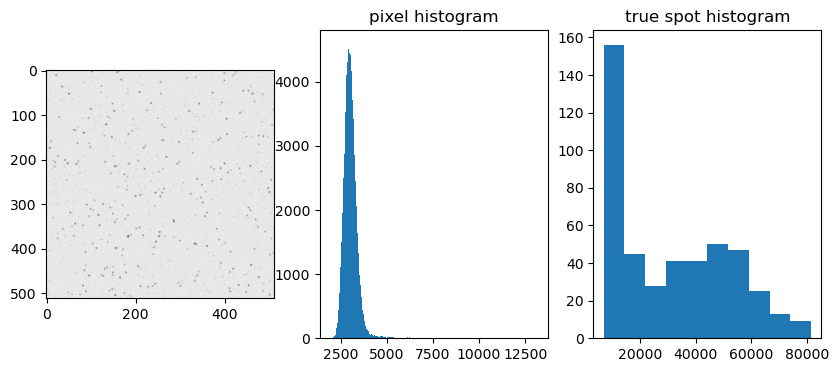

In [5]:
# RA
spot_images_ra = np.zeros((num_spots, *image_dims))
intensities_ra = np.zeros(num_spots)[num_bright_fluorophores != 0]
spot_centers_ra = np.empty((intensities_ra.shape[0], 2))
for i, num_bright in enumerate(num_bright_fluorophores[num_bright_fluorophores != 0]):
    spot_centers_ra[i] = (
        rng.uniform(0.0, image_dims[0]),
        rng.uniform(0.0, image_dims[1]),
    )
    for j in range(num_bright):
        intensity = rng.lognormal(monomer_mu, monomer_sigma)
        intensities_ra[i] += intensity
        spot_images_ra[i] += (
            intensity
            * (
                norm.cdf(yvals_upper, spot_centers_ra[i, 0], spot_sigma)
                - norm.cdf(yvals_lower, spot_centers_ra[i, 0], spot_sigma)
            )[:, np.newaxis]
            * (
                norm.cdf(xvals_upper, spot_centers_ra[i, 1], spot_sigma)
                - norm.cdf(xvals_lower, spot_centers_ra[i, 1], spot_sigma)
            )[np.newaxis, :]
        )
image_ra = np.sum(spot_images_ra, axis=0) + background

f, axes = plt.subplots(1, 3, figsize=(10, 4))
axes[0].imshow(image_ra, cmap="binary")
axes[1].hist(image_ra.flatten(), bins="auto")
axes[1].set_title("pixel histogram")
axes[2].hist(intensities_ra, bins="auto")
axes[2].set_title("true spot histogram")

In [6]:
thresholds = 10.0 ** np.linspace(2.0, 3.1, 20)
threshold_to_use = np.mean(thresholds)
sigma_guess = 1.3
sigma_range = 1.15

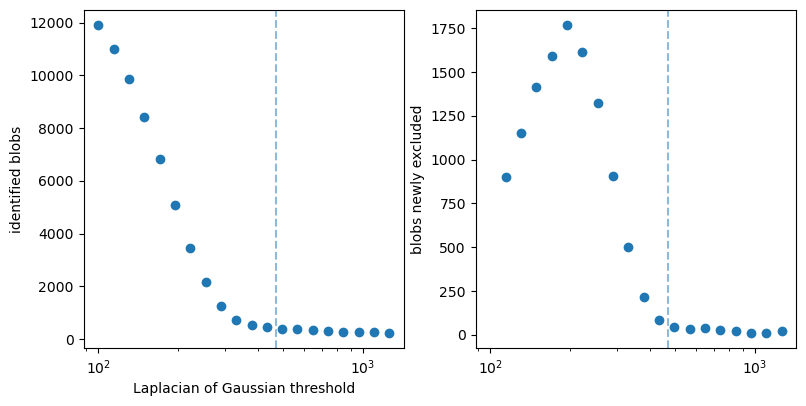

In [7]:
def blob_log_fixedargs(threshold):
    return blob_log(
        image_md,
        threshold=threshold,
        min_sigma=sigma_guess / sigma_range,
        max_sigma=sigma_guess * sigma_range,
        num_sigma=40,
    )


with Pool(num_cores) as pool:
    blobs_log_md = pool.map(blob_log_fixedargs, thresholds)
nblobs = np.array([len(blobs) for blobs in blobs_log_md])

f, axes = plt.subplots(1, 2, sharex=True, figsize=(8, 4))
axes[0].scatter(thresholds, nblobs)
axes[1].scatter(thresholds[1:], nblobs[:-1] - nblobs[1:])
axes[0].set_xlabel("Laplacian of Gaussian threshold")
axes[0].set_ylabel("identified blobs")
axes[0].set_xscale("log")
axes[0].axvline(threshold_to_use, ls="dashed", alpha=0.5)
axes[1].axvline(threshold_to_use, ls="dashed", alpha=0.5)
axes[1].set_ylabel("blobs newly excluded")
f.tight_layout(pad=0.5)

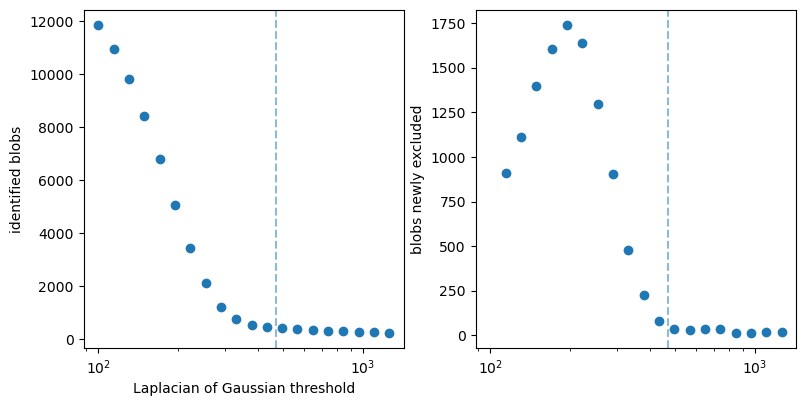

In [8]:
def blob_log_fixedargs(threshold):
    return blob_log(
        image_ra,
        threshold=threshold,
        min_sigma=sigma_guess / sigma_range,
        max_sigma=sigma_guess * sigma_range,
        num_sigma=40,
    )


with Pool(num_cores) as pool:
    blobs_log_ra = pool.map(blob_log_fixedargs, thresholds)
nblobs = np.array([len(blobs) for blobs in blobs_log_ra])

f, axes = plt.subplots(1, 2, sharex=True, figsize=(8, 4))
axes[0].scatter(thresholds, nblobs)
axes[1].scatter(thresholds[1:], nblobs[:-1] - nblobs[1:])
axes[0].set_xlabel("Laplacian of Gaussian threshold")
axes[0].set_ylabel("identified blobs")
axes[0].set_xscale("log")
axes[0].axvline(threshold_to_use, ls="dashed", alpha=0.5)
axes[1].axvline(threshold_to_use, ls="dashed", alpha=0.5)
axes[1].set_ylabel("blobs newly excluded")
f.tight_layout(pad=0.5)

Text(0, 0.5, 'estimated intensity of closest spot')

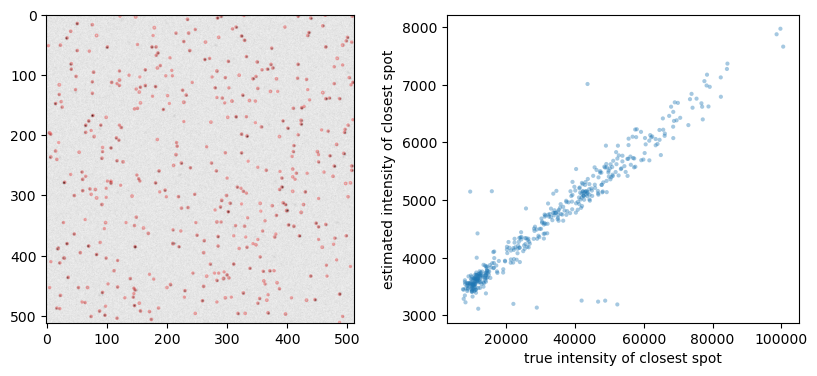

In [9]:
blobs_md = blob_log(
    image_md,
    threshold=threshold_to_use,
    min_sigma=sigma_guess / sigma_range,
    max_sigma=sigma_guess * sigma_range,
    num_sigma=40,
)

f, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(image_md, cmap="binary")

blob_intensities_md = []
closest_intensities_md = []
for blob in blobs_md:
    y, x, r = blob
    blob_intensities_md.append(gaussian_filter(image_md, r)[int(y), int(x)])
    closest_intensities_md.append(
        intensities_md[
            np.argmin(np.square(y - spot_centers_md[:, 0]) + np.square(x - spot_centers_md[:, 1]))
        ]
    )
    c = plt.Circle((x, y), r * np.sqrt(2), color="red", linewidth=1, fill=False, alpha=0.3)
    axes[0].add_patch(c)

axes[1].scatter(
    closest_intensities_md, blob_intensities_md, alpha=0.4, edgecolor="none", marker="."
)
axes[1].set_xlabel("true intensity of closest spot")
axes[1].set_ylabel("estimated intensity of closest spot")

Text(0, 0.5, 'true positives')

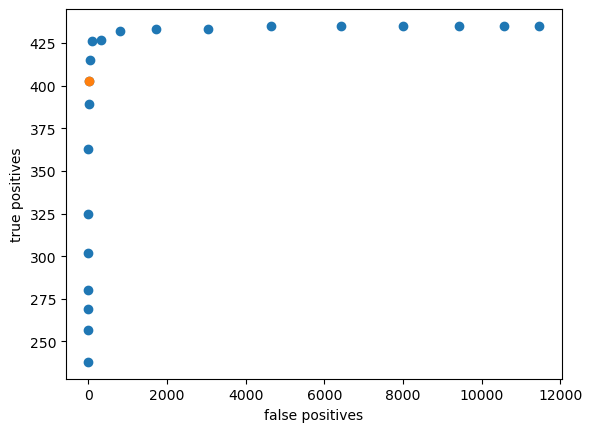

In [10]:
true_positives = []
false_positives = []
for blobs in blobs_log_md:
    true_positive = 0
    false_positive = 0
    for blob in blobs:
        y, x, r = blob
        if (
            np.min(np.square(y - spot_centers_md[:, 0]) + np.square(x - spot_centers_md[:, 1]))
            < 2.0 * r
        ):
            true_positive += 1
        else:
            false_positive += 1
    true_positives.append(true_positive)
    false_positives.append(false_positive)

true_positive = 0
false_positive = 0
for blob in blobs_md:
    y, x, r = blob
    if (
        np.min(np.square(y - spot_centers_md[:, 0]) + np.square(x - spot_centers_md[:, 1]))
        < 2.0 * r
    ):
        true_positive += 1
    else:
        false_positive += 1
true_positives.append(true_positive)
false_positives.append(false_positive)

plt.scatter(false_positives, true_positives)
plt.scatter(false_positive, true_positive)
plt.xlabel("false positives")
plt.ylabel("true positives")

Text(0, 0.5, 'estimated intensity of closest spot')

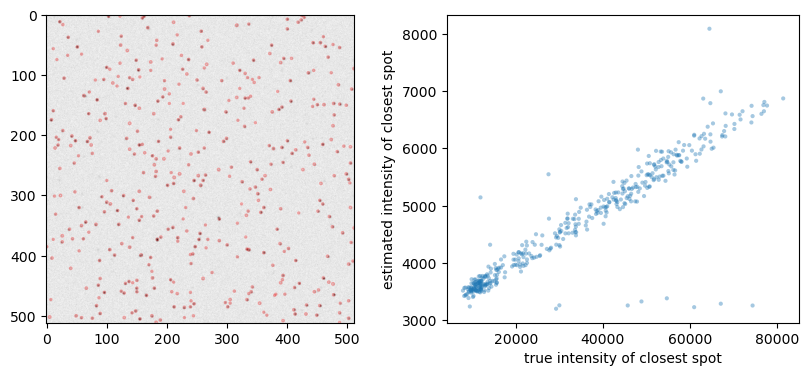

In [11]:
blobs_ra = blob_log(
    image_ra,
    threshold=threshold_to_use,
    min_sigma=sigma_guess / sigma_range,
    max_sigma=sigma_guess * sigma_range,
    num_sigma=40,
)

f, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(image_ra, cmap="binary")

blob_intensities_ra = []
closest_intensities_ra = []
for blob in blobs_ra:
    y, x, r = blob
    blob_intensities_ra.append(gaussian_filter(image_ra, r)[int(y), int(x)])
    closest_intensities_ra.append(
        intensities_ra[
            np.argmin(np.square(y - spot_centers_ra[:, 0]) + np.square(x - spot_centers_ra[:, 1]))
        ]
    )
    c = plt.Circle((x, y), r * np.sqrt(2), color="red", linewidth=1, fill=False, alpha=0.3)
    axes[0].add_patch(c)

axes[1].scatter(
    closest_intensities_ra, blob_intensities_ra, alpha=0.4, edgecolor="none", marker="."
)
axes[1].set_xlabel("true intensity of closest spot")
axes[1].set_ylabel("estimated intensity of closest spot")

Text(0, 0.5, 'true positives')

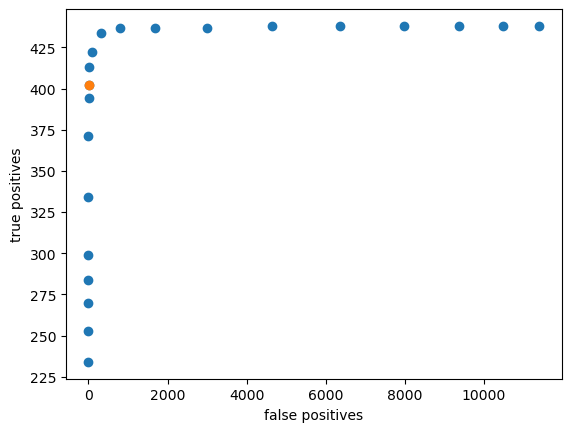

In [12]:
true_positives = []
false_positives = []
for blobs in blobs_log_ra:
    true_positive = 0
    false_positive = 0
    for blob in blobs:
        y, x, r = blob
        if (
            np.min(np.square(y - spot_centers_ra[:, 0]) + np.square(x - spot_centers_ra[:, 1]))
            < 2.0 * r
        ):
            true_positive += 1
        else:
            false_positive += 1
    true_positives.append(true_positive)
    false_positives.append(false_positive)

true_positive = 0
false_positive = 0
for blob in blobs_ra:
    y, x, r = blob
    if (
        np.min(np.square(y - spot_centers_ra[:, 0]) + np.square(x - spot_centers_ra[:, 1]))
        < 2.0 * r
    ):
        true_positive += 1
    else:
        false_positive += 1
true_positives.append(true_positive)
false_positives.append(false_positive)

plt.scatter(false_positives, true_positives)
plt.scatter(false_positive, true_positive)
plt.xlabel("false positives")
plt.ylabel("true positives")

In [13]:
@jit(nopython=True)
def pick_background_pixels(image, blobs):
    background_pixels = []
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            for blob in blobs:
                y, x, blob_sigma = blob
                if np.sqrt(np.square(y - i) + np.square(x - j)) < 4.0 * blob_sigma:
                    background_pixels.append(image[i, j])
    return background_pixels

In [14]:
def pick_background_pixels_after_subtracting(image, blobs, intensities, background_level):
    spot_images_estimated = np.zeros((len(blobs), *image.shape))
    for i, blob in enumerate(blobs):
        y, x, blob_sigma = blob
        spot_images_estimated[i] = (
            (intensities[i] - background_level)
            * 2.0
            * np.pi
            * np.square(blob_sigma)
            * (norm.cdf(yvals_upper, y, blob_sigma) - norm.cdf(yvals_lower, y, blob_sigma))[
                :, np.newaxis
            ]
            * (norm.cdf(xvals_upper, x, blob_sigma) - norm.cdf(xvals_lower, x, blob_sigma))[
                np.newaxis, :
            ]
        )
    image_estimated = image - np.sum(spot_images_estimated, axis=0)
    background_pixels = pick_background_pixels(image_estimated, blobs)
    return background_pixels, image_estimated

In [15]:
modelcode = """
data {
    int<lower=1> num_background_pixels;
    vector<lower=0>[num_background_pixels] background_pixels;
}

parameters {
    real<lower=0> background_mu;
    real<lower=0> background_sigma;
}

model {
    background_pixels ~ lognormal(background_mu, background_sigma);
}
"""

filename = "fit_background.stan"

with open(filename, "w") as f:
    f.write(modelcode)

background_model = CmdStanModel(stan_file=filename)
background_model.compile()

20:52:21 - cmdstanpy - INFO - compiling stan file /home/kent/fit_background.stan to exe file /home/kent/fit_background
20:52:29 - cmdstanpy - INFO - compiled model executable: /home/kent/fit_background


20:52:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


20:52:30 - cmdstanpy - INFO - CmdStan done processing.
20:52:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: lognormal_lpdf: Location parameter is inf, but must be finite! (in '/home/kent/fit_background.stan', line 13, column 4 to column 67)
	Exception: lognormal_lpdf: Location parameter is inf, but must be finite! (in '/home/kent/fit_background.stan', line 13, column 4 to column 67)
	Exception: lognormal_lpdf: Location parameter is inf, but must be finite! (in '/home/kent/fit_background.stan', line 13, column 4 to column 67)
	Exception: lognormal_lpdf: Location parameter is inf, but must be finite! (in '/home/kent/fit_background.stan', line 13, column 4 to column 67)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in '/home/kent/fit_background.stan', line 13, column 4 to column 67)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in '/home/kent/fit_background.stan', line 13, column 4 to column 67

Mean      MCSE    StdDev          5%         50%  \
lp__              357.168000  0.034207  1.047880  355.193000  357.463000   
background_mu       7.995740  0.000078  0.004890    7.987810    7.995670   
background_sigma    0.099235  0.000130  0.003539    0.093804    0.099141   

                         95%     N_Eff   N_Eff/s     R_hat  
lp__              358.097000   938.398   2784.56  1.002090  
background_mu       8.003720  3916.410  11621.40  0.999495  
background_sigma    0.105045   743.878   2207.35  1.002460

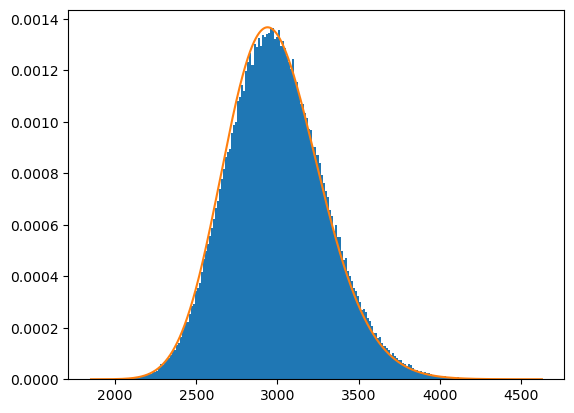

In [16]:
num_background_pixels_demo = 400
data = {
    "num_background_pixels": num_background_pixels_demo,
    "background_pixels": background.flatten()[:num_background_pixels_demo],
}

background_fit = background_model.sample(data)
background_mle = background_model.optimize(data)

plt.hist(background.flatten(), bins="auto", density=True)
xvals = np.linspace(
    np.min(background.flatten()),
    np.max(background.flatten()),
    10000,
)
plt.plot(
    xvals,
    lognorm.pdf(
        xvals,
        s=background_mle.optimized_params_dict["background_sigma"],
        scale=np.exp(background_mle.optimized_params_dict["background_mu"]),
    ),
)
background_fit.summary()

20:52:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


20:52:49 - cmdstanpy - INFO - CmdStan done processing.
20:52:49 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: lognormal_lpdf: Location parameter is inf, but must be finite! (in '/home/kent/fit_background.stan', line 13, column 4 to column 67)
	Exception: lognormal_lpdf: Location parameter is inf, but must be finite! (in '/home/kent/fit_background.stan', line 13, column 4 to column 67)
	Exception: lognormal_lpdf: Location parameter is inf, but must be finite! (in '/home/kent/fit_background.stan', line 13, column 4 to column 67)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in '/home/kent/fit_background.stan', line 13, column 4 to column 67)
	Exception: lognormal_lpdf: Location parameter is inf, but must be finite! (in '/home/kent/fit_background.stan', line 13, column 4 to column 67)
	Exception: lognormal_lpdf: Location parameter is inf, but must be finite! (in '/home/kent/fit_background.stan', line 13, column 4 to column 67)
Exce

Mean      MCSE    StdDev           5%          50%  \
lp__              2542.72000  0.036234  0.985576  2540.780000  2543.020000   
background_mu        8.11277  0.000019  0.001210     8.110780     8.112770   
background_sigma     0.22434  0.000034  0.000870     0.222874     0.224346   

                          95%     N_Eff   N_Eff/s     R_hat  
lp__              2543.660000   739.847   21.8173  1.003310  
background_mu        8.114740  3947.040  116.3940  0.999609  
background_sigma     0.225767   671.021   19.7877  1.004510

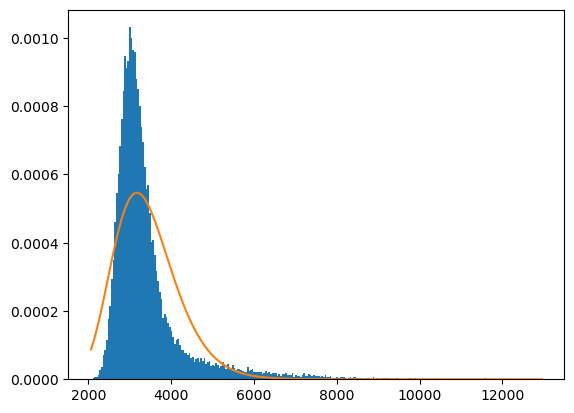

In [17]:
background_pixels_md = pick_background_pixels(image_md, blobs_md)

data = {
    "num_background_pixels": len(background_pixels_md),
    "background_pixels": background_pixels_md,
}

background_fit_md = background_model.sample(data)
background_mle_md = background_model.optimize(data)

plt.hist(background_pixels_md, bins="auto", density=True)
xvals = np.linspace(np.min(background_pixels_md), np.max(background_pixels_md), 10000)
plt.plot(
    xvals,
    lognorm.pdf(
        xvals,
        s=background_mle_md.optimized_params_dict["background_sigma"],
        scale=np.exp(background_mle_md.optimized_params_dict["background_mu"]),
    ),
)
background_fit_md.summary()

20:52:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


20:53:11 - cmdstanpy - INFO - CmdStan done processing.
20:53:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: lognormal_lpdf: Location parameter is inf, but must be finite! (in '/home/kent/fit_background.stan', line 13, column 4 to column 67)
	Exception: lognormal_lpdf: Location parameter is inf, but must be finite! (in '/home/kent/fit_background.stan', line 13, column 4 to column 67)
	Exception: lognormal_lpdf: Location parameter is inf, but must be finite! (in '/home/kent/fit_background.stan', line 13, column 4 to column 67)
	Exception: lognormal_lpdf: Location parameter is inf, but must be finite! (in '/home/kent/fit_background.stan', line 13, column 4 to column 67)
	Exception: lognormal_lpdf: Location parameter is inf, but must be finite! (in '/home/kent/fit_background.stan', line 13, column 4 to column 67)
	Exception: lognormal_lpdf: Location parameter is inf, but must be finite! (in '/home/kent/fit_background.stan', line 13, column 4 to column 67)
	Exception

Mean      MCSE    StdDev            5%          50%  \
lp__              10328.200000  0.046924  1.101280  10326.100000  10328.60000   
background_mu         8.065140  0.000016  0.000963      8.063540      8.06513   
background_sigma      0.178105  0.000040  0.000726      0.176929      0.17811   

                           95%     N_Eff   N_Eff/s    R_hat  
lp__              10329.200000   550.818  14.93420  1.01003  
background_mu         8.066710  3649.510  98.94840  1.00229  
background_sigma      0.179334   327.880   8.88974  1.00379

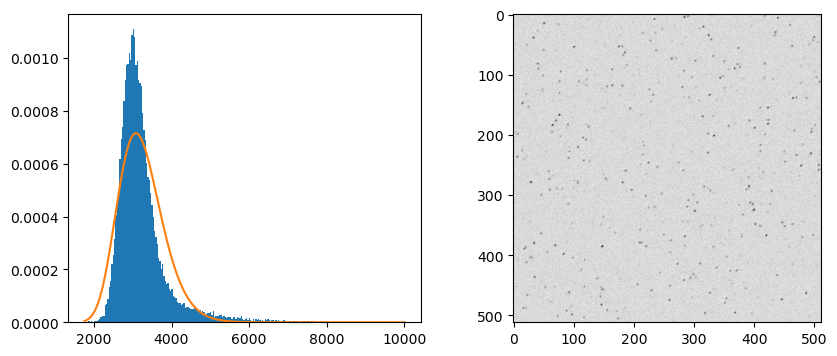

In [18]:
background_pixels_md, image_estimated_md = pick_background_pixels_after_subtracting(
    image_md,
    blobs_md,
    blob_intensities_md,
    np.exp(
        background_mle_md.optimized_params_dict["background_mu"]
        - background_mle_md.optimized_params_dict["background_sigma"] ** 2
    ),
)

data = {
    "num_background_pixels": len(background_pixels_md),
    "background_pixels": background_pixels_md,
}

background_fit_md = background_model.sample(data)
background_mle_md = background_model.optimize(data)

f, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(background_pixels_md, bins="auto", density=True)
xvals = np.linspace(np.min(background_pixels_md), np.max(background_pixels_md), 10000)
axes[0].plot(
    xvals,
    lognorm.pdf(
        xvals,
        s=background_mle_md.optimized_params_dict["background_sigma"],
        scale=np.exp(background_mle_md.optimized_params_dict["background_mu"]),
    ),
)
axes[1].imshow(image_estimated_md, cmap="binary")
background_fit_md.summary()

20:53:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


20:53:32 - cmdstanpy - INFO - CmdStan done processing.
20:53:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: lognormal_lpdf: Location parameter is inf, but must be finite! (in '/home/kent/fit_background.stan', line 13, column 4 to column 67)
	Exception: lognormal_lpdf: Location parameter is inf, but must be finite! (in '/home/kent/fit_background.stan', line 13, column 4 to column 67)
	Exception: lognormal_lpdf: Location parameter is inf, but must be finite! (in '/home/kent/fit_background.stan', line 13, column 4 to column 67)
	Exception: lognormal_lpdf: Location parameter is inf, but must be finite! (in '/home/kent/fit_background.stan', line 13, column 4 to column 67)
	Exception: lognormal_lpdf: Location parameter is inf, but must be finite! (in '/home/kent/fit_background.stan', line 13, column 4 to column 67)
	Exception: lognormal_lpdf: Location parameter is inf, but must be finite! (in '/home/kent/fit_background.stan', line 13, column 4 to column 67)
	Exception

Mean      MCSE    StdDev           5%          50%  \
lp__              2546.79000  0.032622  0.954829  2544.930000  2547.090000   
background_mu        8.11257  0.000020  0.001220     8.110500     8.112570   
background_sigma     0.22414  0.000034  0.000854     0.222699     0.224149   

                          95%     N_Eff   N_Eff/s    R_hat  
lp__              2547.720000   856.720   24.0997  1.00585  
background_mu        8.114620  3629.370  102.0950  1.00032  
background_sigma     0.225516   626.534   17.6245  1.00541

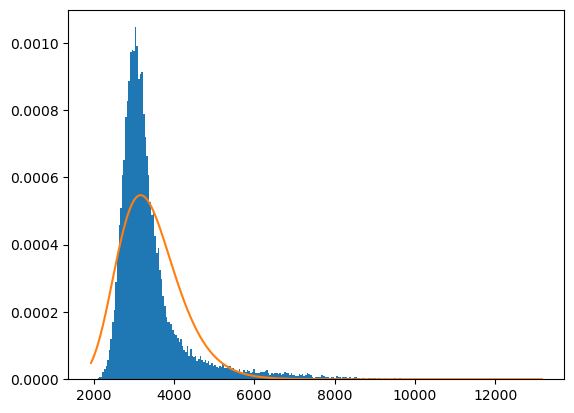

In [19]:
background_pixels_ra = pick_background_pixels(image_ra, blobs_ra)

data = {
    "num_background_pixels": len(background_pixels_ra),
    "background_pixels": background_pixels_ra,
}

background_fit_ra = background_model.sample(data)
background_mle_ra = background_model.optimize(data)

plt.hist(background_pixels_ra, bins="auto", density=True)
xvals = np.linspace(np.min(background_pixels_ra), np.max(background_pixels_ra), 10000)
plt.plot(
    xvals,
    lognorm.pdf(
        xvals,
        s=background_mle_ra.optimized_params_dict["background_sigma"],
        scale=np.exp(background_mle_ra.optimized_params_dict["background_mu"]),
    ),
)
background_fit_ra.summary()

20:53:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


20:53:53 - cmdstanpy - INFO - CmdStan done processing.
20:53:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: lognormal_lpdf: Location parameter is inf, but must be finite! (in '/home/kent/fit_background.stan', line 13, column 4 to column 67)
	Exception: lognormal_lpdf: Location parameter is inf, but must be finite! (in '/home/kent/fit_background.stan', line 13, column 4 to column 67)
	Exception: lognormal_lpdf: Location parameter is inf, but must be finite! (in '/home/kent/fit_background.stan', line 13, column 4 to column 67)
	Exception: lognormal_lpdf: Location parameter is inf, but must be finite! (in '/home/kent/fit_background.stan', line 13, column 4 to column 67)
	Exception: lognormal_lpdf: Scale parameter is 0, but must be positive finite! (in '/home/kent/fit_background.stan', line 13, column 4 to column 67)
	Exception: lognormal_lpdf: Scale parameter is 0, but must be positive finite! (in '/home/kent/fit_background.stan', line 13, column 4 to column 67)
Ex

Mean      MCSE    StdDev            5%  \
lp__              10290.900000  0.029693  0.990567  10289.000000   
background_mu         8.065520  0.000016  0.000973      8.063920   
background_sigma      0.177511  0.000025  0.000671      0.176406   

                           50%           95%     N_Eff   N_Eff/s    R_hat  
lp__              10291.200000  10291.900000  1112.880   30.3312  1.00269  
background_mu         8.065550      8.067090  3760.650  102.4950  1.00042  
background_sigma      0.177493      0.178592   750.301   20.4492  1.00618

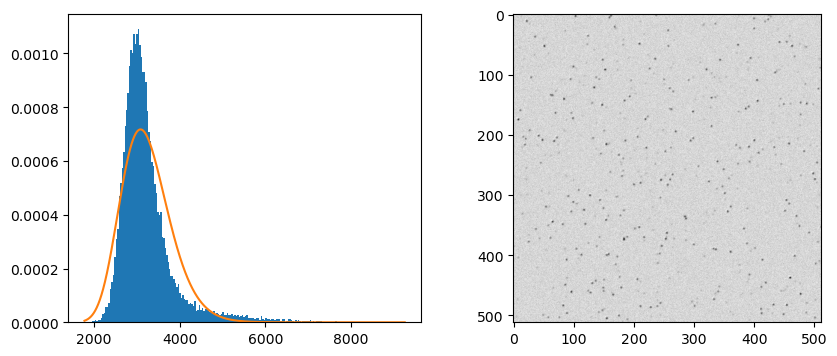

In [20]:
background_pixels_ra, image_estimated_ra = pick_background_pixels_after_subtracting(
    image_ra,
    blobs_ra,
    blob_intensities_ra,
    np.exp(
        background_mle_ra.optimized_params_dict["background_mu"]
        - background_mle_ra.optimized_params_dict["background_sigma"] ** 2
    ),
)

data = {
    "num_background_pixels": len(background_pixels_ra),
    "background_pixels": background_pixels_ra,
}

background_fit_ra = background_model.sample(data)
background_mle_ra = background_model.optimize(data)

f, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(background_pixels_ra, bins="auto", density=True)
xvals = np.linspace(np.min(background_pixels_ra), np.max(background_pixels_ra), 10000)
axes[0].plot(
    xvals,
    lognorm.pdf(
        xvals,
        s=background_mle_ra.optimized_params_dict["background_sigma"],
        scale=np.exp(background_mle_ra.optimized_params_dict["background_mu"]),
    ),
)
axes[1].imshow(image_estimated_ra, cmap="binary")
background_fit_ra.summary()

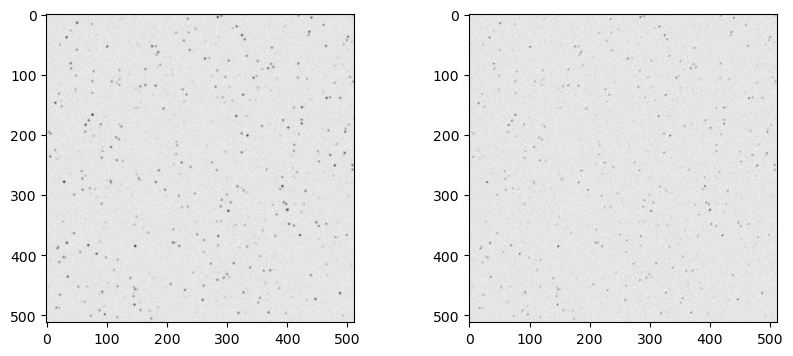

In [21]:
f, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(image_md, cmap="binary", vmin=np.min(image_md), vmax=np.max(image_md))
axes[1].imshow(image_estimated_md, cmap="binary", vmin=np.min(image_md), vmax=np.max(image_md))

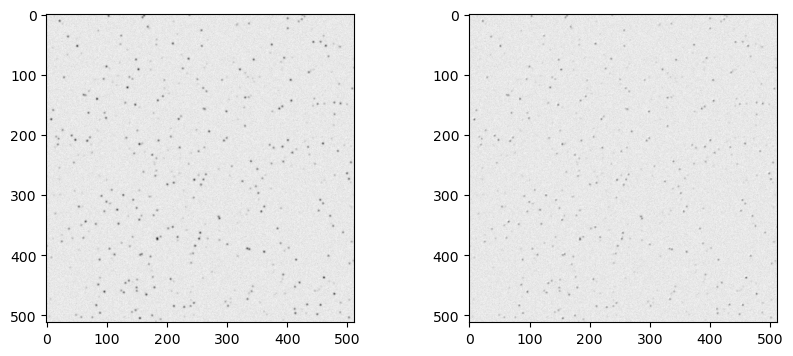

In [22]:
f, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(image_ra, cmap="binary", vmin=np.min(image_ra), vmax=np.max(image_ra))
axes[1].imshow(image_estimated_ra, cmap="binary", vmin=np.min(image_ra), vmax=np.max(image_ra))

In [23]:
censor_edge = 2
censor_separation = 3

# fit blob directly given prior estimated background subtracted before passing
modelcode = """
data {
    matrix<lower=0>[5,5] image;
    real<lower=0> overall_background_level;
}
// maybe in a future version of Stan...
//transformed data {
//    vector[5] lower_edges_col;
//    row_vector[5] lower_edges_row;
//    vector[5] upper_edges_col;
//    row_vector[5] upper_edges_row;
//    for (i in 0:4) {
//        lower_edges_col[i] = i;
//        lower_edges_row[i] = i;
//        upper_edges_col[i] = i + 1.0;
//        upper_edges_row[i] = i + 1.0;
//    }
//}
parameters {
    real background_level;
    real<lower=0> blob_intensity;
    vector<lower=1,upper=6>[2] blob_center;
    real<lower=0.5, upper=5.0> blob_sigma;
    real<lower=0> sigma_error;
}
model {
//    matrix[5,5] pixel_frac = ((std_normal_cdf((upper_edges_col - blob_center[1]) / blob_sigma) -
//                               std_normal_cdf((lower_edges_col - blob_center[1]) / blob_sigma)) *
//                              (std_normal_cdf((upper_edges_row - blob_center[2]) / blob_sigma) -
//                               std_normal_cdf((lower_edges_row - blob_center[2]) / blob_sigma)));
    for (n in 1:5) {
        for (m in 1:5) {
            image[m,n] - background_level ~ normal(blob_intensity *
                                                   ((std_normal_cdf((m + 1 - blob_center[1]) / blob_sigma) -
                                                     std_normal_cdf((m - blob_center[1]) / blob_sigma)) *
                                                    (std_normal_cdf((n + 1 - blob_center[2]) / blob_sigma) -
                                                     std_normal_cdf((n - blob_center[2]) / blob_sigma))),
                                                   sigma_error);
        }
    }
    background_level ~ normal(overall_background_level, overall_background_level / 15);
}
"""

filename = "fit_blob.stan"

with open(filename, "w") as f:
    f.write(modelcode)

blob_model = CmdStanModel(stan_file=filename)
blob_model.compile()

20:53:55 - cmdstanpy - INFO - compiling stan file /home/kent/fit_blob.stan to exe file /home/kent/fit_blob
20:54:06 - cmdstanpy - INFO - compiled model executable: /home/kent/fit_blob


20:54:06 - cmdstanpy - INFO - Chain [1] start processing
20:54:06 - cmdstanpy - INFO - Chain [1] done processing
20:54:06 - cmdstanpy - INFO - Chain [1] start processing
20:54:06 - cmdstanpy - INFO - Chain [1] done processing
20:54:06 - cmdstanpy - INFO - Chain [1] start processing
20:54:06 - cmdstanpy - INFO - Chain [1] done processing
20:54:06 - cmdstanpy - INFO - Chain [1] start processing
20:54:07 - cmdstanpy - INFO - Chain [1] done processing
20:54:07 - cmdstanpy - INFO - Chain [1] start processing
20:54:07 - cmdstanpy - INFO - Chain [1] done processing
20:54:07 - cmdstanpy - INFO - Chain [1] start processing
20:54:07 - cmdstanpy - INFO - Chain [1] done processing
20:54:07 - cmdstanpy - INFO - Chain [1] start processing
20:54:07 - cmdstanpy - INFO - Chain [1] done processing
20:54:07 - cmdstanpy - INFO - Chain [1] start processing
20:54:07 - cmdstanpy - INFO - Chain [1] done processing
20:54:07 - cmdstanpy - INFO - Chain [1] start processing
20:54:07 - cmdstanpy - INFO - Chain [1]

20:54:12 - cmdstanpy - INFO - Chain [1] done processing
20:54:12 - cmdstanpy - INFO - Chain [1] start processing
20:54:12 - cmdstanpy - INFO - Chain [1] done processing
20:54:12 - cmdstanpy - INFO - Chain [1] start processing
20:54:12 - cmdstanpy - INFO - Chain [1] done processing
20:54:12 - cmdstanpy - INFO - Chain [1] start processing
20:54:12 - cmdstanpy - INFO - Chain [1] done processing
20:54:12 - cmdstanpy - INFO - Chain [1] start processing
20:54:12 - cmdstanpy - INFO - Chain [1] done processing
20:54:12 - cmdstanpy - INFO - Chain [1] start processing
20:54:12 - cmdstanpy - INFO - Chain [1] done processing
20:54:12 - cmdstanpy - INFO - Chain [1] start processing
20:54:12 - cmdstanpy - INFO - Chain [1] done processing
20:54:12 - cmdstanpy - INFO - Chain [1] start processing
20:54:12 - cmdstanpy - INFO - Chain [1] done processing
20:54:12 - cmdstanpy - INFO - Chain [1] start processing
20:54:12 - cmdstanpy - INFO - Chain [1] done processing
20:54:12 - cmdstanpy - INFO - Chain [1] 

20:54:18 - cmdstanpy - INFO - Chain [1] done processing
20:54:18 - cmdstanpy - INFO - Chain [1] start processing
20:54:18 - cmdstanpy - INFO - Chain [1] done processing
20:54:18 - cmdstanpy - INFO - Chain [1] start processing
20:54:18 - cmdstanpy - INFO - Chain [1] done processing
20:54:18 - cmdstanpy - INFO - Chain [1] start processing
20:54:18 - cmdstanpy - INFO - Chain [1] done processing
20:54:18 - cmdstanpy - INFO - Chain [1] start processing
20:54:18 - cmdstanpy - INFO - Chain [1] done processing
20:54:18 - cmdstanpy - INFO - Chain [1] start processing
20:54:18 - cmdstanpy - INFO - Chain [1] done processing
20:54:18 - cmdstanpy - INFO - Chain [1] start processing
20:54:18 - cmdstanpy - INFO - Chain [1] done processing
20:54:18 - cmdstanpy - INFO - Chain [1] start processing
20:54:18 - cmdstanpy - INFO - Chain [1] done processing
20:54:18 - cmdstanpy - INFO - Chain [1] start processing
20:54:18 - cmdstanpy - INFO - Chain [1] done processing
20:54:18 - cmdstanpy - INFO - Chain [1] 

20:54:23 - cmdstanpy - INFO - Chain [1] done processing
20:54:23 - cmdstanpy - INFO - Chain [1] start processing
20:54:24 - cmdstanpy - INFO - Chain [1] done processing
20:54:24 - cmdstanpy - INFO - Chain [1] start processing
20:54:24 - cmdstanpy - INFO - Chain [1] done processing
20:54:24 - cmdstanpy - INFO - Chain [1] start processing
20:54:24 - cmdstanpy - INFO - Chain [1] done processing
20:54:24 - cmdstanpy - INFO - Chain [1] start processing
20:54:24 - cmdstanpy - INFO - Chain [1] done processing
20:54:24 - cmdstanpy - INFO - Chain [1] start processing
20:54:24 - cmdstanpy - INFO - Chain [1] done processing
20:54:24 - cmdstanpy - INFO - Chain [1] start processing
20:54:24 - cmdstanpy - INFO - Chain [1] done processing
20:54:24 - cmdstanpy - INFO - Chain [1] start processing
20:54:24 - cmdstanpy - INFO - Chain [1] done processing
20:54:24 - cmdstanpy - INFO - Chain [1] start processing
20:54:24 - cmdstanpy - INFO - Chain [1] done processing
20:54:24 - cmdstanpy - INFO - Chain [1] 

20:54:29 - cmdstanpy - INFO - Chain [1] done processing
20:54:29 - cmdstanpy - INFO - Chain [1] start processing
20:54:29 - cmdstanpy - INFO - Chain [1] done processing
20:54:29 - cmdstanpy - INFO - Chain [1] start processing
20:54:29 - cmdstanpy - INFO - Chain [1] done processing
20:54:29 - cmdstanpy - INFO - Chain [1] start processing
20:54:29 - cmdstanpy - INFO - Chain [1] done processing
20:54:29 - cmdstanpy - INFO - Chain [1] start processing
20:54:29 - cmdstanpy - INFO - Chain [1] done processing
20:54:29 - cmdstanpy - INFO - Chain [1] start processing
20:54:29 - cmdstanpy - INFO - Chain [1] done processing
20:54:29 - cmdstanpy - INFO - Chain [1] start processing
20:54:29 - cmdstanpy - INFO - Chain [1] done processing
20:54:29 - cmdstanpy - INFO - Chain [1] start processing
20:54:29 - cmdstanpy - INFO - Chain [1] done processing
20:54:29 - cmdstanpy - INFO - Chain [1] start processing
20:54:29 - cmdstanpy - INFO - Chain [1] done processing
20:54:30 - cmdstanpy - INFO - Chain [1] 

20:54:34 - cmdstanpy - INFO - Chain [1] done processing
20:54:34 - cmdstanpy - INFO - Chain [1] start processing
20:54:34 - cmdstanpy - INFO - Chain [1] done processing
20:54:34 - cmdstanpy - INFO - Chain [1] start processing
20:54:35 - cmdstanpy - INFO - Chain [1] done processing
20:54:35 - cmdstanpy - INFO - Chain [1] start processing
20:54:35 - cmdstanpy - INFO - Chain [1] done processing
20:54:35 - cmdstanpy - INFO - Chain [1] start processing
20:54:35 - cmdstanpy - INFO - Chain [1] done processing
20:54:35 - cmdstanpy - INFO - Chain [1] start processing
20:54:35 - cmdstanpy - INFO - Chain [1] done processing
20:54:35 - cmdstanpy - INFO - Chain [1] start processing
20:54:35 - cmdstanpy - INFO - Chain [1] done processing
20:54:35 - cmdstanpy - INFO - Chain [1] start processing
20:54:35 - cmdstanpy - INFO - Chain [1] done processing
20:54:35 - cmdstanpy - INFO - Chain [1] start processing
20:54:35 - cmdstanpy - INFO - Chain [1] done processing
20:54:35 - cmdstanpy - INFO - Chain [1] 

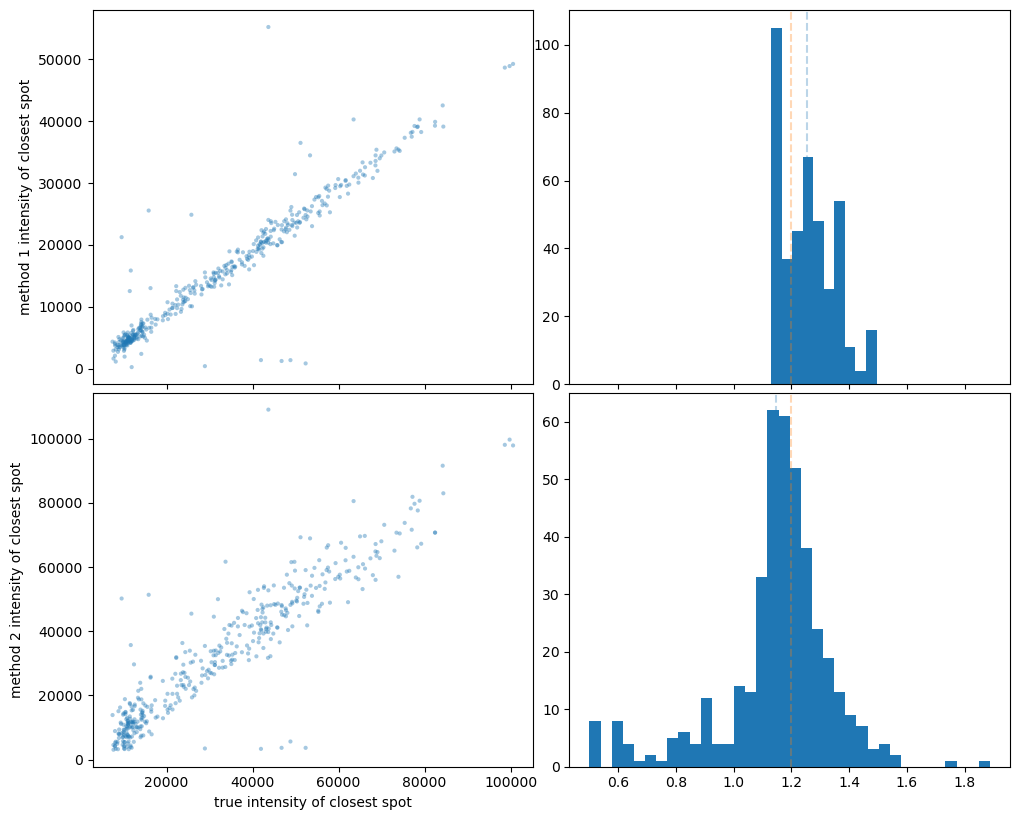

In [24]:
method1_intensities_md = []
method2_intensities_md = []
closest_intensities_censored_md = []
method1_blob_sigmas = []
method2_blob_sigmas = []

ylocs = np.array([blob[0] for blob in blobs_md])
xlocs = np.array([blob[1] for blob in blobs_md])
for i, blob in enumerate(blobs_md):
    y, x, blob_sigma = blob
    if x >= censor_edge and x < image_dims[0] - censor_edge:
        if y >= censor_edge and y < image_dims[1] - censor_edge:
            if (
                np.sum(np.sqrt(np.square(ylocs - y) + np.square(xlocs - x)) < censor_separation)
                == 1
            ):
                closest_intensities_censored_md.append(closest_intensities_md[i])
                method1_blob_sigmas.append(blob_sigma)
                method1_intensities_md.append(
                    (
                        blob_intensities_md[i]
                        - np.exp(
                            background_mle_md.optimized_params_dict["background_mu"]
                            - background_mle_md.optimized_params_dict["background_sigma"] ** 2
                        )
                    )
                    * 2.0
                    * np.pi
                    * np.square(blob_sigma)
                )
                data = {
                    "image": image_md[int(y) - 2 : int(y) + 3, int(x) - 2 : int(x) + 3],
                    "overall_background_level": np.exp(
                        background_mle_md.optimized_params_dict["background_mu"]
                        - background_mle_md.optimized_params_dict["background_sigma"] ** 2
                    ),
                }
                inits = {
                    "blob_center": (3.5, 3.5),
                    "blob_sigma": blob_sigma,
                    "background_level": np.min(
                        image_md[int(y) - 2 : int(y) + 3, int(x) - 2 : int(x) + 3]
                    ),
                    "blob_intensity": 50000.0,
                    "sigma_error": 600.0,
                }
                blob_mle = blob_model.optimize(data, inits=inits)
                method2_intensities_md.append(blob_mle.optimized_params_dict["blob_intensity"])
                method2_blob_sigmas.append(blob_mle.optimized_params_dict["blob_sigma"])

method1_intensities_md = np.array(method1_intensities_md)
method2_intensities_md = np.array(method2_intensities_md)

f, axes = plt.subplots(2, 2, figsize=(10, 8), sharex="col")
axes[0, 0].scatter(
    closest_intensities_censored_md,
    method1_intensities_md,
    alpha=0.4,
    edgecolor="none",
    marker=".",
)
axes[1, 0].scatter(
    closest_intensities_censored_md,
    method2_intensities_md,
    alpha=0.4,
    edgecolor="none",
    marker=".",
)
axes[1, 0].set_xlabel("true intensity of closest spot")
axes[0, 0].set_ylabel("method 1 intensity of closest spot")
axes[1, 0].set_ylabel("method 2 intensity of closest spot")
axes[0, 1].hist(method1_blob_sigmas, bins="auto")
axes[1, 1].hist(method2_blob_sigmas, bins="auto")
axes[0, 1].axvline(np.mean(method1_blob_sigmas), ls="dashed", alpha=0.3)
axes[0, 1].axvline(spot_sigma, ls="dashed", alpha=0.3, color="C1")
axes[1, 1].axvline(np.mean(method2_blob_sigmas), ls="dashed", alpha=0.3)
axes[1, 1].axvline(spot_sigma, ls="dashed", alpha=0.3, color="C1")
f.tight_layout(pad=0.0)

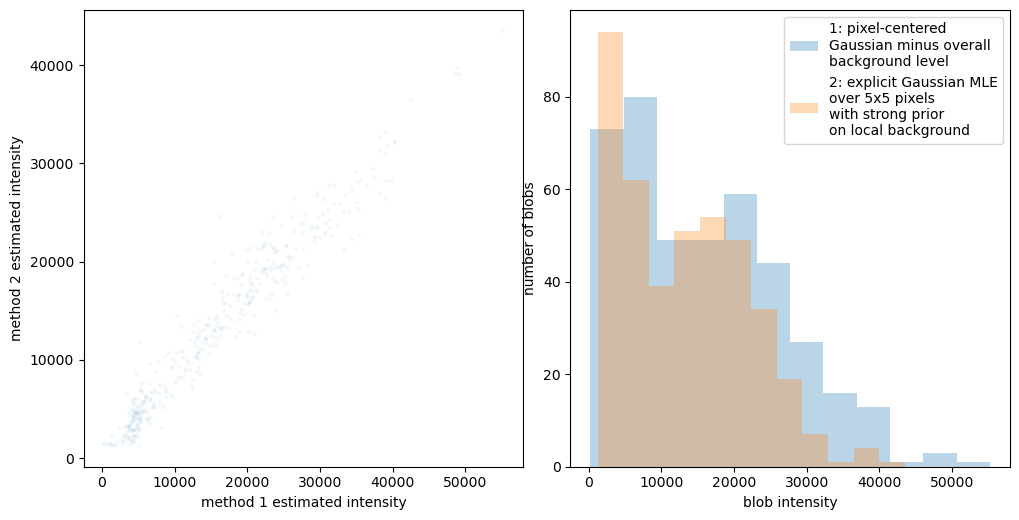

In [25]:
f, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].scatter(
    method1_intensities_md,
    method2_intensities_md / np.sqrt(2.0 * np.pi),
    marker=".",
    alpha=0.05,
    edgecolor="none",
)
axes[1].hist(method1_intensities_md, bins="auto", alpha=0.3)
axes[1].hist(method2_intensities_md / np.sqrt(2.0 * np.pi), bins="auto", alpha=0.3)
axes[0].set_xlabel("method 1 estimated intensity")
axes[0].set_ylabel("method 2 estimated intensity")
axes[1].set_ylabel("number of blobs")
axes[1].set_xlabel("blob intensity")
axes[1].legend(
    [
        "1: pixel-centered\nGaussian minus overall\nbackground level",
        "2: explicit Gaussian MLE\nover 5x5 pixels\nwith strong prior\non local background",
    ]
)
f.tight_layout(pad=0.0)

20:54:39 - cmdstanpy - INFO - Chain [1] start processing
20:54:39 - cmdstanpy - INFO - Chain [1] done processing
20:54:39 - cmdstanpy - INFO - Chain [1] start processing
20:54:39 - cmdstanpy - INFO - Chain [1] done processing
20:54:39 - cmdstanpy - INFO - Chain [1] start processing
20:54:39 - cmdstanpy - INFO - Chain [1] done processing
20:54:39 - cmdstanpy - INFO - Chain [1] start processing
20:54:40 - cmdstanpy - INFO - Chain [1] done processing
20:54:40 - cmdstanpy - INFO - Chain [1] start processing
20:54:40 - cmdstanpy - INFO - Chain [1] done processing
20:54:40 - cmdstanpy - INFO - Chain [1] start processing
20:54:40 - cmdstanpy - INFO - Chain [1] done processing
20:54:40 - cmdstanpy - INFO - Chain [1] start processing
20:54:40 - cmdstanpy - INFO - Chain [1] done processing
20:54:40 - cmdstanpy - INFO - Chain [1] start processing
20:54:40 - cmdstanpy - INFO - Chain [1] done processing
20:54:40 - cmdstanpy - INFO - Chain [1] start processing
20:54:40 - cmdstanpy - INFO - Chain [1]

20:54:45 - cmdstanpy - INFO - Chain [1] done processing
20:54:45 - cmdstanpy - INFO - Chain [1] start processing
20:54:45 - cmdstanpy - INFO - Chain [1] done processing
20:54:45 - cmdstanpy - INFO - Chain [1] start processing
20:54:45 - cmdstanpy - INFO - Chain [1] done processing
20:54:45 - cmdstanpy - INFO - Chain [1] start processing
20:54:45 - cmdstanpy - INFO - Chain [1] done processing
20:54:45 - cmdstanpy - INFO - Chain [1] start processing
20:54:45 - cmdstanpy - INFO - Chain [1] done processing
20:54:45 - cmdstanpy - INFO - Chain [1] start processing
20:54:45 - cmdstanpy - INFO - Chain [1] done processing
20:54:45 - cmdstanpy - INFO - Chain [1] start processing
20:54:45 - cmdstanpy - INFO - Chain [1] done processing
20:54:45 - cmdstanpy - INFO - Chain [1] start processing
20:54:45 - cmdstanpy - INFO - Chain [1] done processing
20:54:45 - cmdstanpy - INFO - Chain [1] start processing
20:54:45 - cmdstanpy - INFO - Chain [1] done processing
20:54:45 - cmdstanpy - INFO - Chain [1] 

20:54:50 - cmdstanpy - INFO - Chain [1] done processing
20:54:50 - cmdstanpy - INFO - Chain [1] start processing
20:54:50 - cmdstanpy - INFO - Chain [1] done processing
20:54:50 - cmdstanpy - INFO - Chain [1] start processing
20:54:50 - cmdstanpy - INFO - Chain [1] done processing
20:54:50 - cmdstanpy - INFO - Chain [1] start processing
20:54:51 - cmdstanpy - INFO - Chain [1] done processing
20:54:51 - cmdstanpy - INFO - Chain [1] start processing
20:54:51 - cmdstanpy - INFO - Chain [1] done processing
20:54:51 - cmdstanpy - INFO - Chain [1] start processing
20:54:51 - cmdstanpy - INFO - Chain [1] done processing
20:54:51 - cmdstanpy - INFO - Chain [1] start processing
20:54:51 - cmdstanpy - INFO - Chain [1] done processing
20:54:51 - cmdstanpy - INFO - Chain [1] start processing
20:54:51 - cmdstanpy - INFO - Chain [1] done processing
20:54:51 - cmdstanpy - INFO - Chain [1] start processing
20:54:51 - cmdstanpy - INFO - Chain [1] done processing
20:54:51 - cmdstanpy - INFO - Chain [1] 

20:54:56 - cmdstanpy - INFO - Chain [1] done processing
20:54:56 - cmdstanpy - INFO - Chain [1] start processing
20:54:56 - cmdstanpy - INFO - Chain [1] done processing
20:54:56 - cmdstanpy - INFO - Chain [1] start processing
20:54:56 - cmdstanpy - INFO - Chain [1] done processing
20:54:56 - cmdstanpy - INFO - Chain [1] start processing
20:54:56 - cmdstanpy - INFO - Chain [1] done processing
20:54:56 - cmdstanpy - INFO - Chain [1] start processing
20:54:56 - cmdstanpy - INFO - Chain [1] done processing
20:54:56 - cmdstanpy - INFO - Chain [1] start processing
20:54:56 - cmdstanpy - INFO - Chain [1] done processing
20:54:56 - cmdstanpy - INFO - Chain [1] start processing
20:54:57 - cmdstanpy - INFO - Chain [1] done processing
20:54:57 - cmdstanpy - INFO - Chain [1] start processing
20:54:57 - cmdstanpy - INFO - Chain [1] done processing
20:54:57 - cmdstanpy - INFO - Chain [1] start processing
20:54:57 - cmdstanpy - INFO - Chain [1] done processing
20:54:57 - cmdstanpy - INFO - Chain [1] 

20:55:02 - cmdstanpy - INFO - Chain [1] done processing
20:55:02 - cmdstanpy - INFO - Chain [1] start processing
20:55:02 - cmdstanpy - INFO - Chain [1] done processing
20:55:02 - cmdstanpy - INFO - Chain [1] start processing
20:55:02 - cmdstanpy - INFO - Chain [1] done processing
20:55:02 - cmdstanpy - INFO - Chain [1] start processing
20:55:02 - cmdstanpy - INFO - Chain [1] done processing
20:55:02 - cmdstanpy - INFO - Chain [1] start processing
20:55:02 - cmdstanpy - INFO - Chain [1] done processing
20:55:02 - cmdstanpy - INFO - Chain [1] start processing
20:55:02 - cmdstanpy - INFO - Chain [1] done processing
20:55:02 - cmdstanpy - INFO - Chain [1] start processing
20:55:02 - cmdstanpy - INFO - Chain [1] done processing
20:55:02 - cmdstanpy - INFO - Chain [1] start processing
20:55:02 - cmdstanpy - INFO - Chain [1] done processing
20:55:02 - cmdstanpy - INFO - Chain [1] start processing
20:55:03 - cmdstanpy - INFO - Chain [1] done processing
20:55:03 - cmdstanpy - INFO - Chain [1] 

20:55:07 - cmdstanpy - INFO - Chain [1] done processing
20:55:07 - cmdstanpy - INFO - Chain [1] start processing
20:55:07 - cmdstanpy - INFO - Chain [1] done processing
20:55:07 - cmdstanpy - INFO - Chain [1] start processing
20:55:08 - cmdstanpy - INFO - Chain [1] done processing
20:55:08 - cmdstanpy - INFO - Chain [1] start processing
20:55:08 - cmdstanpy - INFO - Chain [1] done processing
20:55:08 - cmdstanpy - INFO - Chain [1] start processing
20:55:08 - cmdstanpy - INFO - Chain [1] done processing
20:55:08 - cmdstanpy - INFO - Chain [1] start processing
20:55:08 - cmdstanpy - INFO - Chain [1] done processing
20:55:08 - cmdstanpy - INFO - Chain [1] start processing
20:55:08 - cmdstanpy - INFO - Chain [1] done processing
20:55:08 - cmdstanpy - INFO - Chain [1] start processing
20:55:08 - cmdstanpy - INFO - Chain [1] done processing
20:55:08 - cmdstanpy - INFO - Chain [1] start processing
20:55:08 - cmdstanpy - INFO - Chain [1] done processing
20:55:08 - cmdstanpy - INFO - Chain [1] 

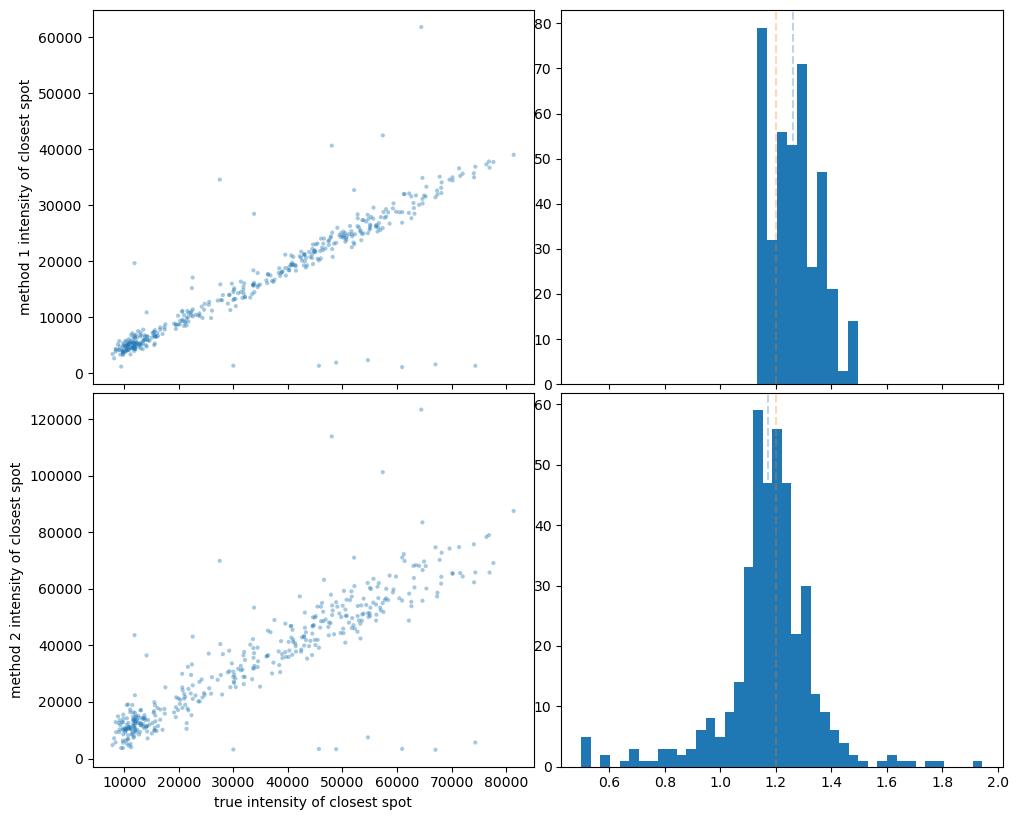

In [26]:
method1_intensities_ra = []
method2_intensities_ra = []
closest_intensities_censored_ra = []
method1_blob_sigmas = []
method2_blob_sigmas = []

ylocs = np.array([blob[0] for blob in blobs_ra])
xlocs = np.array([blob[1] for blob in blobs_ra])
for i, blob in enumerate(blobs_ra):
    y, x, blob_sigma = blob
    if x >= censor_edge and x < image_dims[0] - censor_edge:
        if y >= censor_edge and y < image_dims[1] - censor_edge:
            if (
                np.sum(np.sqrt(np.square(ylocs - y) + np.square(xlocs - x)) < censor_separation)
                == 1
            ):
                closest_intensities_censored_ra.append(closest_intensities_ra[i])
                method1_blob_sigmas.append(blob_sigma)
                method1_intensities_ra.append(
                    (
                        blob_intensities_ra[i]
                        - np.exp(
                            background_mle_ra.optimized_params_dict["background_mu"]
                            - background_mle_ra.optimized_params_dict["background_sigma"] ** 2
                        )
                    )
                    * 2.0
                    * np.pi
                    * np.square(blob_sigma)
                )
                data = {
                    "image": image_ra[int(y) - 2 : int(y) + 3, int(x) - 2 : int(x) + 3],
                    "overall_background_level": np.exp(
                        background_mle_ra.optimized_params_dict["background_mu"]
                        - background_mle_ra.optimized_params_dict["background_sigma"] ** 2
                    ),
                }
                inits = {
                    "blob_center": (3.5, 3.5),
                    "blob_sigma": blob_sigma,
                    "background_level": np.min(
                        image_ra[int(y) - 2 : int(y) + 3, int(x) - 2 : int(x) + 3]
                    ),
                    "blob_intensity": 50000.0,
                    "sigma_error": 600.0,
                }
                blob_mle = blob_model.optimize(data, inits=inits)
                method2_intensities_ra.append(blob_mle.optimized_params_dict["blob_intensity"])
                method2_blob_sigmas.append(blob_mle.optimized_params_dict["blob_sigma"])

method1_intensities_ra = np.array(method1_intensities_ra)
method2_intensities_ra = np.array(method2_intensities_ra)

f, axes = plt.subplots(2, 2, figsize=(10, 8), sharex="col")
axes[0, 0].scatter(
    closest_intensities_censored_ra,
    method1_intensities_ra,
    alpha=0.4,
    edgecolor="none",
    marker=".",
)
axes[1, 0].scatter(
    closest_intensities_censored_ra,
    method2_intensities_ra,
    alpha=0.4,
    edgecolor="none",
    marker=".",
)
axes[1, 0].set_xlabel("true intensity of closest spot")
axes[0, 0].set_ylabel("method 1 intensity of closest spot")
axes[1, 0].set_ylabel("method 2 intensity of closest spot")
axes[0, 1].hist(method1_blob_sigmas, bins="auto")
axes[1, 1].hist(method2_blob_sigmas, bins="auto")
axes[0, 1].axvline(np.mean(method1_blob_sigmas), ls="dashed", alpha=0.3)
axes[0, 1].axvline(spot_sigma, ls="dashed", alpha=0.3, color="C1")
axes[1, 1].axvline(np.mean(method2_blob_sigmas), ls="dashed", alpha=0.3)
axes[1, 1].axvline(spot_sigma, ls="dashed", alpha=0.3, color="C1")
f.tight_layout(pad=0.0)

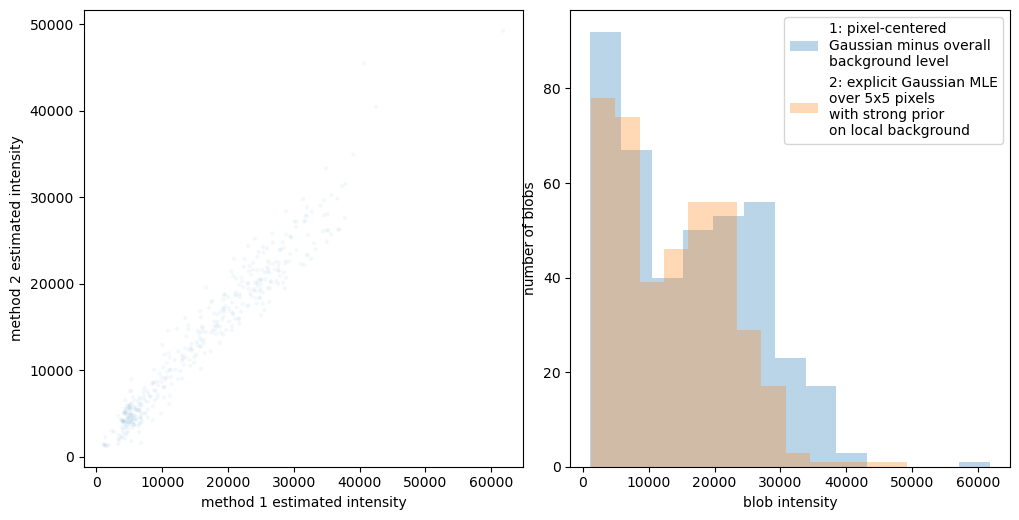

In [27]:
f, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].scatter(
    method1_intensities_ra,
    method2_intensities_ra / np.sqrt(2.0 * np.pi),
    marker=".",
    alpha=0.05,
    edgecolor="none",
)
axes[1].hist(method1_intensities_ra, bins="auto", alpha=0.3)
axes[1].hist(method2_intensities_ra / np.sqrt(2.0 * np.pi), bins="auto", alpha=0.3)
axes[0].set_xlabel("method 1 estimated intensity")
axes[0].set_ylabel("method 2 estimated intensity")
axes[1].set_ylabel("number of blobs")
axes[1].set_xlabel("blob intensity")
axes[1].legend(
    [
        "1: pixel-centered\nGaussian minus overall\nbackground level",
        "2: explicit Gaussian MLE\nover 5x5 pixels\nwith strong prior\non local background",
    ]
)
f.tight_layout(pad=0.0)

In [28]:
def get_sample_mean(fit, name):
    return np.mean(fit.draws()[:, :, fit.column_names.index(name)])

In [29]:
modelcode = """
data {
    int<lower=1> num_spots;
    int<lower=0> highest_oligomer;
    vector<lower=0>[num_spots] spot_intensities;
}

parameters {
    real background_level;
    real<lower=0> monomer_mu;
    real<lower=0> sigma;
    simplex[highest_oligomer] p_oligomer;
}

model {
    vector[highest_oligomer] log_p_oligomer = log(p_oligomer);
    for (i in 1:num_spots) {
        vector[highest_oligomer] lps = log_p_oligomer;
        for (j in 1:highest_oligomer) {
            lps[j] += lognormal_lupdf(spot_intensities[i] - background_level |
                                      monomer_mu + log(j), sigma);
        }
        target += log_sum_exp(lps);
    }
}
"""

filename = "fit_md.stan"

with open(filename, "w") as f:
    f.write(modelcode)

md_model = CmdStanModel(stan_file=filename)
md_model.compile()

20:55:12 - cmdstanpy - INFO - compiling stan file /home/kent/fit_md.stan to exe file /home/kent/fit_md
20:55:21 - cmdstanpy - INFO - compiled model executable: /home/kent/fit_md


In [30]:
def md_pdf(x, intensity_min, oligomeric_combo, p_oligomer, background_level, monomer_mu, sigma):
    yvals = np.zeros(xvals.shape)
    allowed_index = 0
    for i in oligomeric_combo - 1:
        yvals += p_oligomer[allowed_index] * lognorm.pdf(
            x - intensity_min - background_level,
            s=sigma,
            scale=(i + 1) * np.exp(monomer_mu),
        )
        allowed_index += 1
    return yvals


def combined_md_pdf(
    x,
    intensity_min,
    oligomeric_combo,
    p_oligomer,
    p_bright,
    background_level,
    monomer_mu,
    sigma,
):
    yvals = np.zeros(xvals.shape)
    allowed_index = 0
    for i in oligomeric_combo - 1:
        for j in range(i + 1):
            yvals += (
                p_oligomer[allowed_index]
                * binom.pmf(
                    j,
                    i,
                    p_bright,
                )
                * lognorm.pdf(
                    x - intensity_min - background_level,
                    s=sigma,
                    scale=(j + 1) * np.exp(monomer_mu),
                )
            )
        allowed_index += 1
    return yvals


def md_mean_pdf(x, fit, intensity_min, oligomeric_combo_or_max_oligomer):
    if (
        type(oligomeric_combo_or_max_oligomer) is np.ndarray
        or type(oligomeric_combo_or_max_oligomer) is list
    ):
        oligomeric_combo = oligomeric_combo_or_max_oligomer
    else:
        oligomeric_combo = np.arange(oligomeric_combo_or_max_oligomer) + 1
    p_oligomer = np.empty(len(oligomeric_combo))
    allowed_index = 0
    for i in oligomeric_combo - 1:
        p_oligomer[allowed_index] = get_sample_mean(
            fit, "p_oligomer[" + str(allowed_index + 1) + "]"
        )
        allowed_index += 1
    background_level = get_sample_mean(fit, "background_level")
    monomer_mu = get_sample_mean(fit, "monomer_mu")
    sigma = get_sample_mean(fit, "sigma")
    if "p_bright" in fit.column_names:
        p_bright = get_sample_mean(fit, "p_bright")
        return combined_md_pdf(
            x,
            intensity_min,
            oligomeric_combo,
            p_oligomer,
            p_bright,
            background_level,
            monomer_mu,
            sigma,
        )
    else:
        return md_pdf(
            x,
            intensity_min,
            oligomeric_combo,
            p_oligomer,
            background_level,
            monomer_mu,
            sigma,
        )

20:55:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


20:56:17 - cmdstanpy - INFO - CmdStan done processing.
20:56:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in '/home/kent/fit_md.stan', line 20, column 12 to line 21, column 66)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in '/home/kent/fit_md.stan', line 20, column 12 to line 21, column 66)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in '/home/kent/fit_md.stan', line 20, column 12 to line 21, column 66)
	Exception: lognormal_lpdf: Location parameter is inf, but must be finite! (in '/home/kent/fit_md.stan', line 20, column 12 to line 21, column 66)
	Exception: lognormal_lpdf: Random variable is -1.22724, but must be nonnegative! (in '/home/kent/fit_md.stan', line 20, column 12 to line 21, column 66)
	Exception: lognormal_lpdf: Random variable is -0.00161542, but must be nonnegative! (in '/home/kent/fit_md.stan', line 

Mean       MCSE      StdDev           5%  \
lp__             -4368.970000   0.071235    2.324710 -4373.330000   
background_level -4213.180000  33.234200  944.197000 -5684.250000   
monomer_mu           9.075410   0.004068    0.115276     8.870590   
sigma                0.222428   0.001250    0.032376     0.183143   
p_oligomer[1]        0.359890   0.000483    0.025710     0.317821   
p_oligomer[2]        0.195547   0.002738    0.069500     0.062556   
p_oligomer[3]        0.322010   0.001220    0.058545     0.234629   
p_oligomer[4]        0.095889   0.001788    0.063768     0.011897   
p_oligomer[5]        0.019325   0.000415    0.019650     0.001116   
p_oligomer[6]        0.007338   0.000158    0.008080     0.000363   

                          50%          95%     N_Eff  N_Eff/s     R_hat  
lp__             -4368.610000 -4365.850000  1065.010  18.1975  1.005400  
background_level -4261.980000 -2570.430000   807.148  13.7915  1.012090  
monomer_mu           9.087090     9.250750   802.940  13.7196  1.011820  
sigma                0.214931     0.290469   670.833  11.4623  1.010420  
p_oligomer[1]        0.359591     0.402987  2829.710  48.3504  0.999892  
p_oligomer[2]        0.202645     0.298297   644.111  11.0057  1.013110  
p_oligomer[3]        0.319026     0.421238  2304.380  39.3743  1.001460  
p_oligomer[4]        0.086724     0.215684  1271.560  21.7268  1.006920  
p_oligomer[5]        0.013515     0.059217  2239.740  38.2697  1.002920  
p_oligomer[6]        0.005078     0.022251  2613.910  44.6632  1.001410

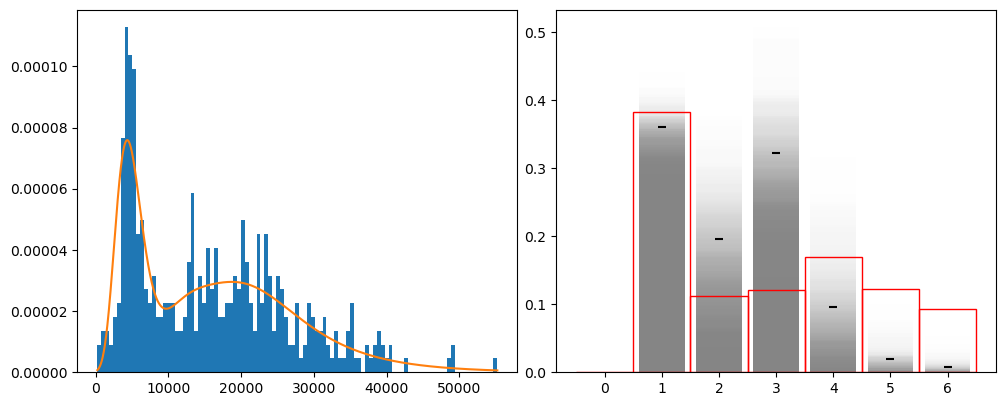

In [31]:
data = {
    "num_spots": method1_intensities_md.shape[0],
    "highest_oligomer": 6,
    "spot_intensities": method1_intensities_md - np.min(method1_intensities_md),
}
md_model_fit_md = md_model.sample(data)

f, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(method1_intensities_md, bins=data["num_spots"] // 4, density=True)
xvals = np.linspace(np.min(method1_intensities_md), np.max(method1_intensities_md), 10000)
axes[0].plot(
    xvals,
    md_mean_pdf(xvals, md_model_fit_md, np.min(method1_intensities_md), data["highest_oligomer"]),
)

xvals = np.arange(data["highest_oligomer"]) + 1
for draw in md_model_fit_md.draws().reshape(-1, md_model_fit_md.draws().shape[-1])[::33, :]:
    heights = [
        draw[md_model_fit_md.column_names.index("p_oligomer[" + str(i + 1) + "]")]
        for i in range(data["highest_oligomer"])
    ]
    axes[1].bar(xvals, heights, color="black", alpha=0.004)
axes[1].scatter(
    xvals,
    np.mean(
        md_model_fit_md.draws().reshape(-1, md_model_fit_md.draws().shape[-1])[
            :,
            md_model_fit_md.column_names.index(
                "p_oligomer[1]"
            ) : md_model_fit_md.column_names.index(
                "p_oligomer[" + str(data["highest_oligomer"]) + "]"
            )
            + 1,
        ],
        axis=0,
    ),
    color="black",
    marker="_",
)
axes[1].hist(
    num_bright_fluorophores[num_bright_fluorophores != 0],
    bins=np.arange(np.max(oligomeric_states) + 2) - 0.5,
    color=(0, 0, 0, 0),
    edgecolor="red",
    density=True,
)
f.tight_layout(pad=0.5)

md_model_fit_md.summary()

20:56:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


20:57:08 - cmdstanpy - INFO - CmdStan done processing.
20:57:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: lognormal_lpdf: Random variable is -0.324367, but must be nonnegative! (in '/home/kent/fit_md.stan', line 20, column 12 to line 21, column 66)
	Exception: lognormal_lpdf: Random variable is -0.832675, but must be nonnegative! (in '/home/kent/fit_md.stan', line 20, column 12 to line 21, column 66)
	Exception: lognormal_lpdf: Random variable is -0.434103, but must be nonnegative! (in '/home/kent/fit_md.stan', line 20, column 12 to line 21, column 66)
	Exception: lognormal_lpdf: Random variable is -0.0866875, but must be nonnegative! (in '/home/kent/fit_md.stan', line 20, column 12 to line 21, column 66)
	Exception: lognormal_lpdf: Random variable is -5.15805, but must be nonnegative! (in '/home/kent/fit_md.stan', line 20, column 12 to line 21, column 66)
	Exception: lognormal_lpdf: Random variable is -397.436, but must be nonnegative! (in '/home/kent/fit_md.

Mean       MCSE      StdDev           5%  \
lp__             -4216.180000   0.062878    2.230560 -4220.270000   
background_level -4881.750000  31.989900  767.040000 -5936.340000   
monomer_mu           9.127190   0.004485    0.096352     8.907250   
sigma                0.220813   0.000758    0.023517     0.188918   
p_oligomer[1]        0.378624   0.000766    0.028644     0.330583   
p_oligomer[2]        0.173804   0.001425    0.048323     0.088602   
p_oligomer[3]        0.391023   0.003465    0.079315     0.241816   
p_oligomer[4]        0.044765   0.004177    0.081988     0.001300   
p_oligomer[5]        0.007045   0.000224    0.009026     0.000353   
p_oligomer[6]        0.004739   0.000077    0.004366     0.000310   

                          50%          95%     N_Eff   N_Eff/s     R_hat  
lp__             -4215.850000 -4213.190000  1258.420  30.76590  1.002650  
background_level -4983.570000 -3306.480000   574.922  14.05570  1.004630  
monomer_mu           9.147790     9.236400   461.430  11.28110  1.005980  
sigma                0.217652     0.264839   963.075  23.54530  1.002770  
p_oligomer[1]        0.378950     0.425733  1397.960  34.17740  1.000360  
p_oligomer[2]        0.176095     0.249469  1149.650  28.10660  1.001830  
p_oligomer[3]        0.401866     0.485818   523.929  12.80910  1.002790  
p_oligomer[4]        0.016984     0.247729   385.351   9.42109  1.006410  
p_oligomer[5]        0.004665     0.020682  1623.250  39.68520  1.000790  
p_oligomer[6]        0.003582     0.012793  3254.300  79.56140  0.999984

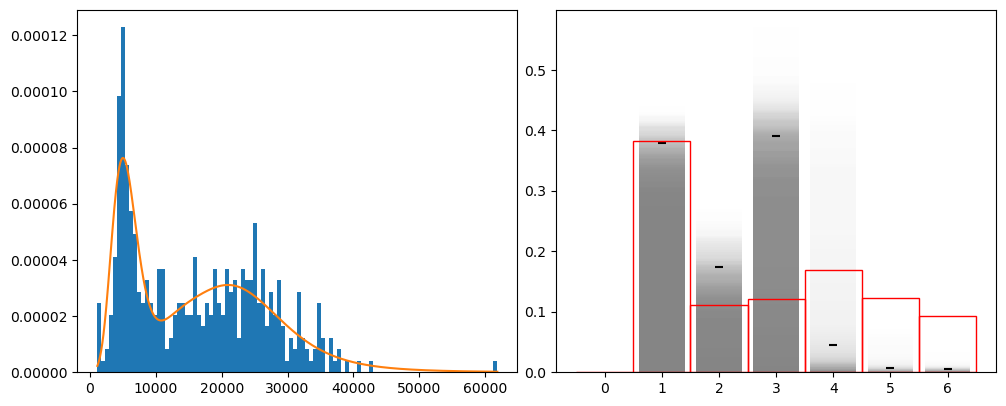

In [32]:
data = {
    "num_spots": method1_intensities_ra.shape[0],
    "highest_oligomer": 6,
    "spot_intensities": method1_intensities_ra - np.min(method1_intensities_ra),
}
md_model_fit_ra = md_model.sample(data)

f, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(method1_intensities_ra, bins=data["num_spots"] // 4, density=True)
xvals = np.linspace(np.min(method1_intensities_ra), np.max(method1_intensities_ra), 10000)
axes[0].plot(
    xvals,
    md_mean_pdf(xvals, md_model_fit_ra, np.min(method1_intensities_ra), data["highest_oligomer"]),
)

xvals = np.arange(data["highest_oligomer"]) + 1
for draw in md_model_fit_ra.draws().reshape(-1, md_model_fit_ra.draws().shape[-1])[::33, :]:
    heights = [
        draw[md_model_fit_ra.column_names.index("p_oligomer[" + str(i + 1) + "]")]
        for i in range(data["highest_oligomer"])
    ]
    axes[1].bar(xvals, heights, color="black", alpha=0.004)
axes[1].scatter(
    xvals,
    np.mean(
        md_model_fit_ra.draws().reshape(-1, md_model_fit_ra.draws().shape[-1])[
            :,
            md_model_fit_ra.column_names.index(
                "p_oligomer[1]"
            ) : md_model_fit_ra.column_names.index(
                "p_oligomer[" + str(data["highest_oligomer"]) + "]"
            )
            + 1,
        ],
        axis=0,
    ),
    color="black",
    marker="_",
)
axes[1].hist(
    num_bright_fluorophores[num_bright_fluorophores != 0],
    bins=np.arange(np.max(oligomeric_states) + 2) - 0.5,
    color=(0, 0, 0, 0),
    edgecolor="red",
    density=True,
)
f.tight_layout(pad=0.5)

md_model_fit_ra.summary()

In [33]:
modelcode = """
data {
    int<lower=1> num_spots;
    int<lower=0> highest_oligomer;
    vector<lower=0>[num_spots] spot_intensities;
}

parameters {
    real background_level;
    real<lower=0> monomer_mu;
    real<lower=0> sigma;
    simplex[highest_oligomer] p_oligomer;
}

model {
    vector[highest_oligomer] log_p_oligomer = log(p_oligomer);
    for (i in 1:num_spots) {
        vector[highest_oligomer] lps = log_p_oligomer;
        for (j in 1:highest_oligomer) {
            lps[j] += lognormal_lupdf(spot_intensities[i] - background_level |
                                      monomer_mu + log(j) + sigma ^ 2 *
                                      (j - 1) / (2.0 * j), sigma / sqrt(j));
        }
        target += log_sum_exp(lps);
    }
}
"""

filename = "fit_approx_ra.stan"

with open(filename, "w") as f:
    f.write(modelcode)

approx_ra_model = CmdStanModel(stan_file=filename)
approx_ra_model.compile()

20:57:10 - cmdstanpy - INFO - compiling stan file /home/kent/fit_approx_ra.stan to exe file /home/kent/fit_approx_ra
20:57:19 - cmdstanpy - INFO - compiled model executable: /home/kent/fit_approx_ra


In [34]:
def approx_ra_pdf(
    x, intensity_min, oligomeric_combo, p_oligomer, background_level, monomer_mu, sigma
):
    yvals = np.zeros(xvals.shape)
    allowed_index = 0
    for i in oligomeric_combo - 1:
        yvals += p_oligomer[allowed_index] * lognorm.pdf(
            x - intensity_min - background_level,
            s=sigma / np.sqrt(i + 1),
            scale=(i + 1) * np.exp(monomer_mu + np.square(sigma) * (i / (2.0 * (i + 1)))),
        )
        allowed_index += 1
    return yvals


def combined_approx_ra_pdf(
    x,
    intensity_min,
    oligomeric_combo,
    p_oligomer,
    p_bright,
    background_level,
    monomer_mu,
    sigma,
):
    yvals = np.zeros(xvals.shape)
    allowed_index = 0
    for i in oligomeric_combo - 1:
        for j in range(i + 1):
            yvals += (
                p_oligomer[allowed_index]
                * binom.pmf(
                    j,
                    i,
                    p_bright,
                )
                * lognorm.pdf(
                    x - intensity_min - background_level,
                    s=sigma / np.sqrt(j + 1),
                    scale=(j + 1) * np.exp(monomer_mu + np.square(sigma) * (j / (2.0 * (j + 1)))),
                )
            )
        allowed_index += 1
    return yvals


def approx_ra_mean_pdf(x, fit, intensity_min, oligomeric_combo_or_max_oligomer):
    if (
        type(oligomeric_combo_or_max_oligomer) is np.ndarray
        or type(oligomeric_combo_or_max_oligomer) is list
    ):
        oligomeric_combo = oligomeric_combo_or_max_oligomer
    else:
        oligomeric_combo = np.arange(oligomeric_combo_or_max_oligomer) + 1
    p_oligomer = np.empty(len(oligomeric_combo))
    allowed_index = 0
    for i in oligomeric_combo - 1:
        p_oligomer[allowed_index] = get_sample_mean(
            fit, "p_oligomer[" + str(allowed_index + 1) + "]"
        )
        allowed_index += 1
    background_level = get_sample_mean(fit, "background_level")
    monomer_mu = get_sample_mean(fit, "monomer_mu")
    sigma = get_sample_mean(fit, "sigma")
    if "p_bright" in fit.column_names:
        p_bright = get_sample_mean(fit, "p_bright")
        return combined_approx_ra_pdf(
            x,
            intensity_min,
            oligomeric_combo,
            p_oligomer,
            p_bright,
            background_level,
            monomer_mu,
            sigma,
        )
    else:
        return approx_ra_pdf(
            x,
            intensity_min,
            oligomeric_combo,
            p_oligomer,
            background_level,
            monomer_mu,
            sigma,
        )

20:57:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


20:58:20 - cmdstanpy - INFO - CmdStan done processing.
20:58:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_approx_ra.stan', line 20, column 12 to line 22, column 76)
	Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_approx_ra.stan', line 20, column 12 to line 22, column 76)
	Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_approx_ra.stan', line 20, column 12 to line 22, column 76)
	Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_approx_ra.stan', line 20, column 12 to line 22, column 76)
	Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_approx_ra.stan', line 20, column 12 to line 22, column 76)
	Exception: lognormal_lpdf: Random variable is -0.0854104, but must be nonnegative! (in '/home/kent/fit_a

20:58:20 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 4 divergent transitions (0.4%)
	Chain 2 had 5 divergent transitions (0.5%)
	Chain 3 had 11 divergent transitions (1.1%)
	Chain 4 had 2 divergent transitions (0.2%)
	Use function "diagnose()" to see further information.


Mean        MCSE       StdDev           5%  \
lp__             -4376.220000    0.199605     2.520690 -4380.480000   
background_level -1244.750000  388.756000  1887.480000 -2463.570000   
monomer_mu           8.112850    0.031783     0.177496     7.963430   
sigma                0.727710    0.018403     0.108080     0.617912   
p_oligomer[1]        0.036186    0.001066     0.022640     0.003167   
p_oligomer[2]        0.430218    0.001415     0.039908     0.366034   
p_oligomer[3]        0.029412    0.007062     0.039181     0.001585   
p_oligomer[4]        0.039901    0.007847     0.048363     0.002049   
p_oligomer[5]        0.098836    0.001656     0.080537     0.006813   
p_oligomer[6]        0.365448    0.009288     0.100918     0.157939   

                          50%          95%      N_Eff    N_Eff/s    R_hat  
lp__             -4375.920000 -4373.090000   159.4770   4.011490  1.02149  
background_level  -828.672000  -325.383000    23.5728   0.592952  1.11850  
monomer_mu           8.081240     8.291740    31.1884   0.784515  1.09680  
sigma                0.744271     0.834340    34.4922   0.867619  1.09054  
p_oligomer[1]        0.033973     0.077169   451.0910  11.346800  1.00948  
p_oligomer[2]        0.430968     0.495668   794.9710  19.996800  1.00850  
p_oligomer[3]        0.017815     0.085912    30.7861   0.774395  1.08401  
p_oligomer[4]        0.025542     0.117600    37.9882   0.955558  1.07542  
p_oligomer[5]        0.079298     0.261561  2363.8000  59.459100  1.00071  
p_oligomer[6]        0.385918     0.491382   118.0500   2.969440  1.02876

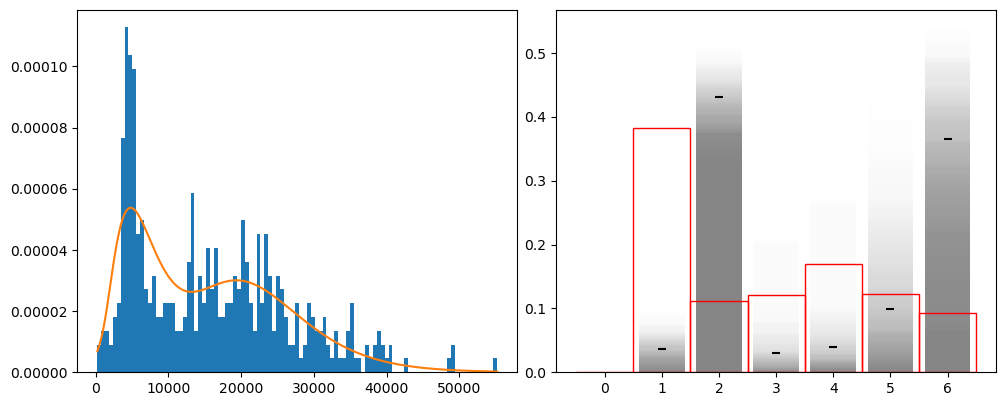

In [35]:
data = {
    "num_spots": method1_intensities_md.shape[0],
    "highest_oligomer": 6,
    "spot_intensities": method1_intensities_md - np.min(method1_intensities_md),
}
approx_ra_model_fit_md = approx_ra_model.sample(data)

f, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(method1_intensities_md, bins=data["num_spots"] // 4, density=True)
xvals = np.linspace(np.min(method1_intensities_md), np.max(method1_intensities_md), 10000)
axes[0].plot(
    xvals,
    approx_ra_mean_pdf(
        xvals,
        approx_ra_model_fit_md,
        np.min(method1_intensities_md),
        data["highest_oligomer"],
    ),
)

xvals = np.arange(data["highest_oligomer"]) + 1
for draw in approx_ra_model_fit_md.draws().reshape(-1, approx_ra_model_fit_md.draws().shape[-1])[
    ::33, :
]:
    heights = [
        draw[approx_ra_model_fit_md.column_names.index("p_oligomer[" + str(i + 1) + "]")]
        for i in range(data["highest_oligomer"])
    ]
    axes[1].bar(xvals, heights, color="black", alpha=0.004)
axes[1].scatter(
    xvals,
    np.mean(
        approx_ra_model_fit_md.draws().reshape(-1, approx_ra_model_fit_md.draws().shape[-1])[
            :,
            approx_ra_model_fit_md.column_names.index(
                "p_oligomer[1]"
            ) : approx_ra_model_fit_md.column_names.index(
                "p_oligomer[" + str(data["highest_oligomer"]) + "]"
            )
            + 1,
        ],
        axis=0,
    ),
    color="black",
    marker="_",
)
axes[1].hist(
    num_bright_fluorophores[num_bright_fluorophores != 0],
    bins=np.arange(np.max(oligomeric_states) + 2) - 0.5,
    color=(0, 0, 0, 0),
    edgecolor="red",
    density=True,
)
f.tight_layout(pad=0.5)

approx_ra_model_fit_md.summary()

20:58:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


20:59:29 - cmdstanpy - INFO - CmdStan done processing.
20:59:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: lognormal_lpdf: Random variable is -1.39574, but must be nonnegative! (in '/home/kent/fit_approx_ra.stan', line 20, column 12 to line 22, column 76)
	Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_approx_ra.stan', line 20, column 12 to line 22, column 76)
	Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_approx_ra.stan', line 20, column 12 to line 22, column 76)
	Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_approx_ra.stan', line 20, column 12 to line 22, column 76)
	Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_approx_ra.stan', line 20, column 12 to line 22, column 76)
	Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_app

Mean       MCSE       StdDev           5%  \
lp__             -4216.200000   0.061225     2.116480 -4220.050000   
background_level -2655.020000  60.909200  1367.910000 -5205.090000   
monomer_mu           8.265190   0.006135     0.139030     8.078850   
sigma                0.563751   0.003690     0.087048     0.405218   
p_oligomer[1]        0.028421   0.000861     0.025688     0.001039   
p_oligomer[2]        0.430288   0.000726     0.036015     0.371346   
p_oligomer[3]        0.024290   0.000498     0.022731     0.001299   
p_oligomer[4]        0.055929   0.001844     0.051716     0.003083   
p_oligomer[5]        0.097620   0.002415     0.082671     0.005993   
p_oligomer[6]        0.363452   0.003623     0.097174     0.167817   

                          50%          95%     N_Eff   N_Eff/s    R_hat  
lp__             -4215.860000 -4213.420000  1194.990  16.63100  1.00388  
background_level -2420.310000  -944.060000   504.370   7.01946  1.00524  
monomer_mu           8.243200     8.524340   513.571   7.14752  1.00515  
sigma                0.572638     0.692124   556.476   7.74464  1.00543  
p_oligomer[1]        0.021535     0.078070   890.774  12.39720  1.00165  
p_oligomer[2]        0.430460     0.488787  2460.560  34.24430  1.00227  
p_oligomer[3]        0.017933     0.070644  2086.750  29.04190  1.00107  
p_oligomer[4]        0.040012     0.167409   786.776  10.94980  1.00356  
p_oligomer[5]        0.074788     0.263948  1171.560  16.30490  1.00188  
p_oligomer[6]        0.385185     0.484096   719.488  10.01330  1.00381

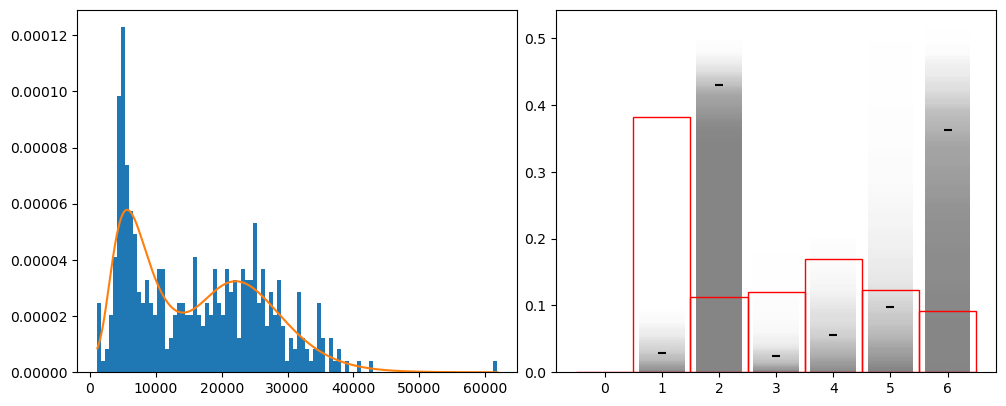

In [36]:
data = {
    "num_spots": method1_intensities_ra.shape[0],
    "highest_oligomer": 6,
    "spot_intensities": method1_intensities_ra - np.min(method1_intensities_ra),
}
approx_ra_model_fit_ra = approx_ra_model.sample(data)

f, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(method1_intensities_ra, bins=data["num_spots"] // 4, density=True)
xvals = np.linspace(np.min(method1_intensities_ra), np.max(method1_intensities_ra), 10000)
axes[0].plot(
    xvals,
    approx_ra_mean_pdf(
        xvals,
        approx_ra_model_fit_ra,
        np.min(method1_intensities_ra),
        data["highest_oligomer"],
    ),
)

xvals = np.arange(data["highest_oligomer"]) + 1
for draw in approx_ra_model_fit_ra.draws().reshape(-1, approx_ra_model_fit_ra.draws().shape[-1])[
    ::33, :
]:
    heights = [
        draw[approx_ra_model_fit_ra.column_names.index("p_oligomer[" + str(i + 1) + "]")]
        for i in range(data["highest_oligomer"])
    ]
    axes[1].bar(xvals, heights, color="black", alpha=0.004)
axes[1].scatter(
    xvals,
    np.mean(
        approx_ra_model_fit_ra.draws().reshape(-1, approx_ra_model_fit_ra.draws().shape[-1])[
            :,
            approx_ra_model_fit_ra.column_names.index(
                "p_oligomer[1]"
            ) : approx_ra_model_fit_ra.column_names.index(
                "p_oligomer[" + str(data["highest_oligomer"]) + "]"
            )
            + 1,
        ],
        axis=0,
    ),
    color="black",
    marker="_",
)
axes[1].hist(
    num_bright_fluorophores[num_bright_fluorophores != 0],
    bins=np.arange(np.max(oligomeric_states) + 2) - 0.5,
    color=(0, 0, 0, 0),
    edgecolor="red",
    density=True,
)
f.tight_layout(pad=0.5)

approx_ra_model_fit_ra.summary()

In [37]:
modelcode = """
data {
    int<lower=1> num_spots;
    int<lower=0> highest_oligomer;
    vector<lower=0>[num_spots] spot_intensities;
}
parameters {
    real background_level;
    real<lower=0> monomer_mu;
    real<lower=0> sigma;
    simplex[highest_oligomer] p_oligomer;
    real<lower=0,upper=1> p_bright;
}
model {
    vector[highest_oligomer] log_p_oligomer = log(p_oligomer);
    vector[((highest_oligomer * (highest_oligomer + 1))%/%2)] lps;
    vector[((highest_oligomer * (highest_oligomer + 1))%/%2)] binomial_precomputed;
    vector[highest_oligomer] lognormal_precomputed;
    int ravel = 1;
    // precompute binomial terms
    for (k in 1:highest_oligomer) { // num total
        for (j in 1:k) { // num bright
            // subtracting the log complementary CDF accounts for
            // the 0 population being censored
            binomial_precomputed[ravel] = binomial_lpmf(j | k, p_bright) -
                                          binomial_lccdf(0 | k, p_bright);
            ravel += 1;
        }
    }
    for (i in 1:num_spots) {
        for (n in 1:highest_oligomer) {
            lognormal_precomputed[n] = lognormal_lupdf(spot_intensities[i] -
                                                       background_level |
                                                       monomer_mu + log(n), sigma);
        }
        ravel = 1;
        for (k in 1:highest_oligomer) { // num total
            for (j in 1:k) { // num bright
                lps[ravel] = log_p_oligomer[k] +
                             binomial_precomputed[ravel] +
                             lognormal_precomputed[j];
                ravel += 1;
            }
        }
        target += log_sum_exp(lps);
    }
}
"""

modelcode_parallel = """
functions {
    real partial_sum_oligomers_lpdf(array[] real slice_spot_intensities,
                                    int start, int end,
                                    int highest_oligomer,
                                    vector lps_precomputed,
                                    real background_level,
                                    real monomer_mu, real sigma) {
        vector[((highest_oligomer * (highest_oligomer + 1))%/%2)] lps;
        vector[highest_oligomer] lognormal_precomputed;
        int ravel;
        real sum = 0.0;
        for (i in 1:(end - start)) {
            ravel = 1;
            // precompute lognormal_lupdf
            for (n in 1:highest_oligomer) {
                lognormal_precomputed[n] = lognormal_lupdf(slice_spot_intensities[i] -
                                                           background_level |
                                                           monomer_mu + log(n), sigma);
            }
            for (k in 1:highest_oligomer) { // num total
                for (j in 1:k) { // num bright
                    lps[ravel] = lognormal_precomputed[j] + lps_precomputed[ravel];
                    ravel += 1;
                }
            }
            sum += log_sum_exp(lps);
        }
        return sum;
    }
}
data {
    int<lower=1> num_spots;
    int<lower=1> highest_oligomer;
    //vector<lower=0>[num_spots] spot_intensities;
    array[num_spots] real<lower=0> spot_intensities;
}
parameters {
    real background_level;
    real<lower=0> monomer_mu;
    real<lower=0> sigma;
    simplex[highest_oligomer] p_oligomer;
    real<lower=0,upper=1> p_bright;
}
model {
    vector[highest_oligomer] log_p_oligomer = log(p_oligomer);
    vector[((highest_oligomer * (highest_oligomer + 1))%/%2)] lps_precomputed;
    int ravel = 1;
    // precompute binomial terms
    for (k in 1:highest_oligomer) { // num total
        for (j in 1:k) { // num bright
            lps_precomputed[ravel] = log_p_oligomer[k];
            // subtracting the log complementary CDF accounts for
            // the 0 population being censored
            lps_precomputed[ravel] += binomial_lpmf(j | k, p_bright) -
                                      binomial_lccdf(0 | k, p_bright);
            ravel += 1;
        }
    }
    target += reduce_sum(partial_sum_oligomers_lupdf, spot_intensities, 64,
                         highest_oligomer, lps_precomputed, background_level,
                         monomer_mu, sigma);
}
"""

filename = "fit_combined_md.stan"

if num_threads_per_chain > 1:
    with open(filename, "w") as f:
        f.write(modelcode_parallel)
    combined_md_model = CmdStanModel(stan_file=filename, cpp_options={"STAN_THREADS": True})
else:
    with open(filename, "w") as f:
        f.write(modelcode)
    combined_md_model = CmdStanModel(stan_file=filename)

combined_md_model.compile()

20:59:31 - cmdstanpy - INFO - compiling stan file /home/kent/fit_combined_md.stan to exe file /home/kent/fit_combined_md
20:59:52 - cmdstanpy - INFO - compiled model executable: /home/kent/fit_combined_md


20:59:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


21:01:16 - cmdstanpy - INFO - CmdStan done processing.
21:01:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: Exception: lognormal_lpdf: Random variable is -0.570843, but must be nonnegative! (in '/home/kent/fit_combined_md.stan', line 17, column 16 to line 19, column 87) (in '/home/kent/fit_combined_md.stan', line 60, column 4 to line 62, column 44)
	Exception: Exception: lognormal_lpdf: Random variable is -0.488886, but must be nonnegative! (in '/home/kent/fit_combined_md.stan', line 17, column 16 to line 19, column 87) (in '/home/kent/fit_combined_md.stan', line 60, column 4 to line 62, column 44)
	Exception: Exception: lognormal_lpdf: Random variable is -0.404343, but must be nonnegative! (in '/home/kent/fit_combined_md.stan', line 17, column 16 to line 19, column 87) (in '/home/kent/fit_combined_md.stan', line 60, column 4 to line 62, column 44)
	Exception: Exception: lognormal_lpdf: Random variable is -1.14312, but must be nonnegative! (in '/home/kent/fit_co

Mean         MCSE       StdDev            5%  \
lp__             -4286.750000     1.297280     3.065030  -4292.850000   
background_level -6208.480000  1559.760000  2904.530000 -12653.300000   
monomer_mu           9.088790     0.085351     0.195194      8.571250   
sigma                0.186114     0.013939     0.040891      0.106664   
p_oligomer[1]        0.135584     0.055905     0.107255      0.000660   
p_oligomer[2]        0.145305     0.089065     0.136156      0.006021   
p_oligomer[3]        0.188399     0.004703     0.151122      0.009261   
p_oligomer[4]        0.290878     0.005419     0.167794      0.032777   
p_oligomer[5]        0.153033     0.012155     0.151678      0.008556   
p_oligomer[6]        0.086801     0.013072     0.121914      0.002638   
p_bright             0.700880     0.123160     0.201720      0.423420   

                          50%          95%       N_Eff    N_Eff/s    R_hat  
lp__             -4286.260000 -4282.720000     5.58221   0.070925  1.24532  
background_level -5168.920000 -3437.740000     3.46764   0.044058  1.57071  
monomer_mu           9.124100     9.298360     5.23012   0.066451  1.30177  
sigma                0.191664     0.243508     8.60554   0.109338  1.18467  
p_oligomer[1]        0.142197     0.302562     3.68066   0.046765  1.46302  
p_oligomer[2]        0.086939     0.381800     2.33699   0.029693  2.52537  
p_oligomer[3]        0.167514     0.499414  1032.71000  13.121100  1.00995  
p_oligomer[4]        0.278625     0.594859   958.71300  12.180900  1.01719  
p_oligomer[5]        0.099730     0.495776   155.72200   1.978530  1.02376  
p_oligomer[6]        0.041499     0.390515    86.98020   1.105130  1.04168  
p_bright             0.651040     0.998940     2.68256   0.034080  1.93779

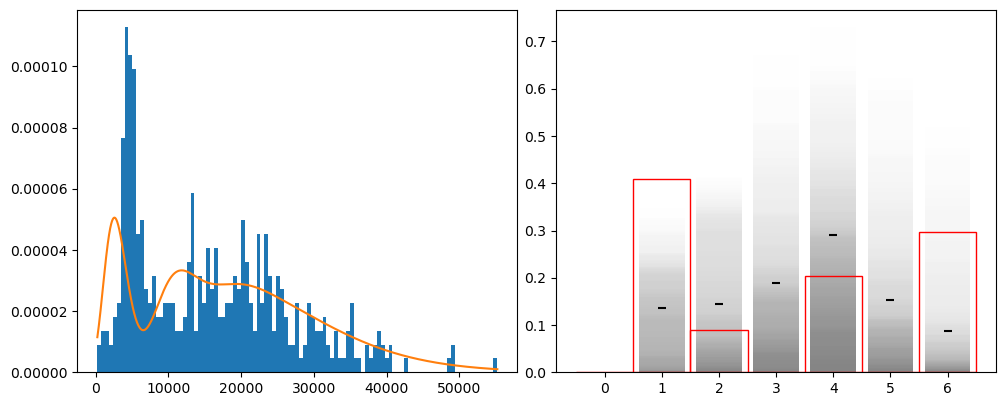

In [38]:
data = {
    "num_spots": method1_intensities_md.shape[0],
    "highest_oligomer": 6,
    "spot_intensities": method1_intensities_md - np.min(method1_intensities_md),
}
combined_md_model_fit_md = combined_md_model.sample(data, threads_per_chain=num_threads_per_chain)

f, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(method1_intensities_md, bins=data["num_spots"] // 4, density=True)
xvals = np.linspace(np.min(method1_intensities_md), np.max(method1_intensities_md), 10000)
axes[0].plot(
    xvals,
    md_mean_pdf(
        xvals,
        combined_md_model_fit_md,
        np.min(method1_intensities_md),
        data["highest_oligomer"],
    ),
)

xvals = np.arange(data["highest_oligomer"]) + 1
for draw in combined_md_model_fit_md.draws().reshape(
    -1, combined_md_model_fit_md.draws().shape[-1]
)[::33, :]:
    heights = [
        draw[combined_md_model_fit_md.column_names.index("p_oligomer[" + str(i + 1) + "]")]
        for i in range(data["highest_oligomer"])
    ]
    axes[1].bar(xvals, heights, color="black", alpha=0.004)
axes[1].scatter(
    xvals,
    np.mean(
        combined_md_model_fit_md.draws().reshape(-1, combined_md_model_fit_md.draws().shape[-1])[
            :,
            combined_md_model_fit_md.column_names.index(
                "p_oligomer[1]"
            ) : combined_md_model_fit_md.column_names.index(
                "p_oligomer[" + str(data["highest_oligomer"]) + "]"
            )
            + 1,
        ],
        axis=0,
    ),
    color="black",
    marker="_",
)
axes[1].hist(
    num_fluorophores,
    bins=np.arange(np.max(oligomeric_states) + 2) - 0.5,
    color=(0, 0, 0, 0),
    edgecolor="red",
    density=True,
)
f.tight_layout(pad=0.5)

combined_md_model_fit_md.summary()

21:01:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


21:02:23 - cmdstanpy - INFO - CmdStan done processing.
21:02:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: Exception: lognormal_lpdf: Random variable is -0.577044, but must be nonnegative! (in '/home/kent/fit_combined_md.stan', line 17, column 16 to line 19, column 87) (in '/home/kent/fit_combined_md.stan', line 60, column 4 to line 62, column 44)
	Exception: Exception: lognormal_lpdf: Location parameter is inf, but must be finite! (in '/home/kent/fit_combined_md.stan', line 17, column 16 to line 19, column 87) (in '/home/kent/fit_combined_md.stan', line 60, column 4 to line 62, column 44)
	Exception: Exception: lognormal_lpdf: Location parameter is inf, but must be finite! (in '/home/kent/fit_combined_md.stan', line 17, column 16 to line 19, column 87) (in '/home/kent/fit_combined_md.stan', line 60, column 4 to line 62, column 44)
	Exception: Exception: lognormal_lpdf: Location parameter is inf, but must be finite! (in '/home/kent/fit_combined_md.stan', line 1

Mean       MCSE      StdDev           5%  \
lp__             -4137.490000   0.089263    2.495900 -4142.000000   
background_level -4987.400000  34.597100  824.597000 -6121.070000   
monomer_mu           9.132680   0.004818    0.103595     8.914590   
sigma                0.214043   0.000617    0.020791     0.185713   
p_oligomer[1]        0.330505   0.001355    0.043503     0.256957   
p_oligomer[2]        0.077825   0.001377    0.059458     0.004247   
p_oligomer[3]        0.440188   0.009035    0.177622     0.037089   
p_oligomer[4]        0.122918   0.009004    0.172854     0.002246   
p_oligomer[5]        0.020359   0.001473    0.045952     0.000593   
p_oligomer[6]        0.008204   0.000307    0.013134     0.000412   
p_bright             0.861340   0.002780    0.077910     0.710700   

                          50%          95%       N_Eff   N_Eff/s    R_hat  
lp__             -4137.120000 -4134.120000   781.82300  13.97860  1.00328  
background_level -5132.460000 -3371.210000   568.07400  10.15690  1.00587  
monomer_mu           9.158510     9.256390   462.24000   8.26462  1.00712  
sigma                0.211223     0.253540  1135.11000  20.29520  1.00203  
p_oligomer[1]        0.333290     0.395142  1031.33000  18.43970  1.00262  
p_oligomer[2]        0.066973     0.192235  1865.48000  33.35390  1.00015  
p_oligomer[3]        0.497965     0.627813   386.50700   6.91055  1.01006  
p_oligomer[4]        0.037985     0.519426   368.53800   6.58928  1.00882  
p_oligomer[5]        0.008673     0.072373   972.64900  17.39050  1.00525  
p_oligomer[6]        0.005086     0.025275  1826.88000  32.66360  1.00220  
p_bright             0.869590     0.974070   784.51829  14.02679  1.00360

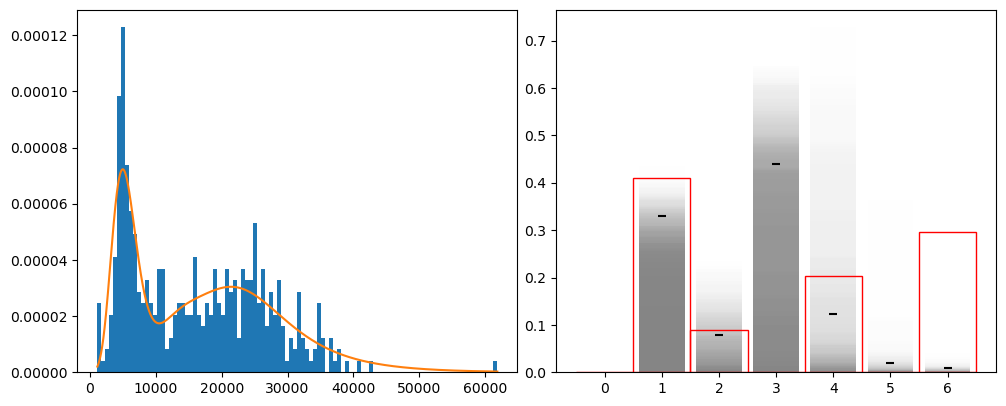

In [39]:
data = {
    "num_spots": method1_intensities_ra.shape[0],
    "highest_oligomer": 6,
    "spot_intensities": method1_intensities_ra - np.min(method1_intensities_ra),
}
combined_md_model_fit_ra = combined_md_model.sample(data, threads_per_chain=num_threads_per_chain)

f, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(method1_intensities_ra, bins=data["num_spots"] // 4, density=True)
xvals = np.linspace(np.min(method1_intensities_ra), np.max(method1_intensities_ra), 10000)
axes[0].plot(
    xvals,
    md_mean_pdf(
        xvals,
        combined_md_model_fit_ra,
        np.min(method1_intensities_ra),
        data["highest_oligomer"],
    ),
)

xvals = np.arange(data["highest_oligomer"]) + 1
for draw in combined_md_model_fit_ra.draws().reshape(
    -1, combined_md_model_fit_ra.draws().shape[-1]
)[::33, :]:
    heights = [
        draw[combined_md_model_fit_ra.column_names.index("p_oligomer[" + str(i + 1) + "]")]
        for i in range(data["highest_oligomer"])
    ]
    axes[1].bar(xvals, heights, color="black", alpha=0.004)
axes[1].scatter(
    xvals,
    np.mean(
        combined_md_model_fit_ra.draws().reshape(-1, combined_md_model_fit_ra.draws().shape[-1])[
            :,
            combined_md_model_fit_ra.column_names.index(
                "p_oligomer[1]"
            ) : combined_md_model_fit_ra.column_names.index(
                "p_oligomer[" + str(data["highest_oligomer"]) + "]"
            )
            + 1,
        ],
        axis=0,
    ),
    color="black",
    marker="_",
)
axes[1].hist(
    num_fluorophores,
    bins=np.arange(np.max(oligomeric_states) + 2) - 0.5,
    color=(0, 0, 0, 0),
    edgecolor="red",
    density=True,
)
f.tight_layout(pad=0.5)

combined_md_model_fit_ra.summary()

In [40]:
modelcode = """
data {
    int<lower=1> num_spots;
    int<lower=0> highest_oligomer;
    vector<lower=0>[num_spots] spot_intensities;
}
parameters {
    real background_level;
    real<lower=0> monomer_mu;
    real<lower=0> sigma;
    simplex[highest_oligomer] p_oligomer;
    real<lower=0,upper=1> p_bright;
}
model {
    vector[highest_oligomer] log_p_oligomer = log(p_oligomer);
    vector[((highest_oligomer * (highest_oligomer + 1))%/%2)] lps;
    vector[((highest_oligomer * (highest_oligomer + 1))%/%2)] binomial_precomputed;
    vector[highest_oligomer] lognormal_precomputed;
    int ravel = 1;
    // precompute binomial terms
    for (k in 1:highest_oligomer) { // num total
        for (j in 1:k) { // num bright
            // subtracting the log complementary CDF accounts for
            // the 0 population being censored
            binomial_precomputed[ravel] = binomial_lpmf(j | k, p_bright) -
                                          binomial_lccdf(0 | k, p_bright);
            ravel += 1;
        }
    }
    for (i in 1:num_spots) {
        for (n in 1:highest_oligomer) {
            lognormal_precomputed[n] = lognormal_lupdf(spot_intensities[i] -
                                                       background_level |
                                                       monomer_mu + log(n) +
                                                       sigma ^ 2 *
                                                       (n - 1) / (2.0 * n),
                                                       sigma / sqrt(n));
        }
        ravel = 1;
        for (k in 1:highest_oligomer) { // num total
            for (j in 1:k) { // num bright
                lps[ravel] = log_p_oligomer[k] +
                             binomial_precomputed[ravel] +
                             lognormal_precomputed[j];
                ravel += 1;
            }
        }
        target += log_sum_exp(lps);
    }
}
"""

modelcode_parallel = """
functions {
    real partial_sum_oligomers_lpdf(array[] real slice_spot_intensities,
                                    int start, int end,
                                    int highest_oligomer,
                                    vector lps_precomputed,
                                    real background_level,
                                    real monomer_mu, real sigma) {
        vector[((highest_oligomer * (highest_oligomer + 1))%/%2)] lps;
        vector[highest_oligomer] lognormal_precomputed;
        int ravel;
        real sum = 0.0;
        for (i in 1:(end - start)) {
            ravel = 1;
            // precompute lognormal_lupdf
            for (n in 1:highest_oligomer) {
                lognormal_precomputed[n] = lognormal_lupdf(slice_spot_intensities[i] -
                                                           background_level |
                                                           monomer_mu + log(n) +
                                                           sigma ^ 2 *
                                                           (n - 1) / (2.0 * n),
                                                           sigma / sqrt(n));
            }
            for (k in 1:highest_oligomer) { // num total
                for (j in 1:k) { // num bright
                    lps[ravel] = lognormal_precomputed[j] + lps_precomputed[ravel];
                    ravel += 1;
                }
            }
            sum += log_sum_exp(lps);
        }
        return sum;
    }
}
data {
    int<lower=1> num_spots;
    int<lower=1> highest_oligomer;
    //vector<lower=0>[num_spots] spot_intensities;
    array[num_spots] real<lower=0> spot_intensities;
}
parameters {
    real background_level;
    real<lower=0> monomer_mu;
    real<lower=0> sigma;
    simplex[highest_oligomer] p_oligomer;
    real<lower=0,upper=1> p_bright;
}
model {
    vector[highest_oligomer] log_p_oligomer = log(p_oligomer);
    vector[((highest_oligomer * (highest_oligomer + 1))%/%2)] lps_precomputed;
    int ravel = 1;
    // precompute binomial terms
    for (k in 1:highest_oligomer) { // num total
        for (j in 1:k) { // num bright
            lps_precomputed[ravel] = log_p_oligomer[k];
            // subtracting the log complementary CDF accounts for
            // the 0 population being censored
            lps_precomputed[ravel] += binomial_lpmf(j | k, p_bright) -
                                      binomial_lccdf(0 | k, p_bright);
            ravel += 1;
        }
    }
    target += reduce_sum(partial_sum_oligomers_lupdf, spot_intensities, 64,
                         highest_oligomer, lps_precomputed, background_level,
                         monomer_mu, sigma);
}
"""

filename = "fit_combined_approx_ra.stan"

if num_threads_per_chain > 1:
    with open(filename, "w") as f:
        f.write(modelcode_parallel)
    combined_approx_ra_model = CmdStanModel(stan_file=filename, cpp_options={"STAN_THREADS": True})
else:
    with open(filename, "w") as f:
        f.write(modelcode)
    combined_approx_rad_model = CmdStanModel(stan_file=filename)

combined_approx_ra_model.compile()

21:02:25 - cmdstanpy - INFO - compiling stan file /home/kent/fit_combined_approx_ra.stan to exe file /home/kent/fit_combined_approx_ra
21:02:47 - cmdstanpy - INFO - compiled model executable: /home/kent/fit_combined_approx_ra


21:02:47 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


21:03:51 - cmdstanpy - INFO - CmdStan done processing.
21:03:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra.stan', line 17, column 16 to line 22, column 76) (in '/home/kent/fit_combined_approx_ra.stan', line 63, column 4 to line 65, column 44)
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra.stan', line 17, column 16 to line 22, column 76) (in '/home/kent/fit_combined_approx_ra.stan', line 63, column 4 to line 65, column 44)
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra.stan', line 17, column 16 to line 22, column 76) (in '/home/kent/fit_combined_approx_ra.stan', line 63, column 4 to line 65, column 44)
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/h

21:03:51 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.1%)
	Chain 3 had 2 divergent transitions (0.2%)
	Use function "diagnose()" to see further information.


Mean       MCSE      StdDev           5%  \
lp__             -4298.130000   0.067998    2.350570 -4302.460000   
background_level  -853.272000  12.564400  430.513000 -1691.260000   
monomer_mu           8.087520   0.002054    0.074698     7.972100   
sigma                0.743041   0.001382    0.054874     0.652078   
p_oligomer[1]        0.030963   0.000459    0.022457     0.002534   
p_oligomer[2]        0.432580   0.000717    0.039462     0.366758   
p_oligomer[3]        0.023016   0.000348    0.022439     0.001060   
p_oligomer[4]        0.031107   0.000527    0.029675     0.001853   
p_oligomer[5]        0.085481   0.001366    0.075310     0.004308   
p_oligomer[6]        0.396854   0.001563    0.081208     0.237407   
p_bright             0.981380   0.000260    0.015930     0.949810   

                          50%          95%       N_Eff  N_Eff/s     R_hat  
lp__             -4297.790000 -4294.950000  1194.97000  27.8313  1.001440  
background_level  -772.400000  -309.230000  1174.05000  27.3442  1.002230  
monomer_mu           8.085260     8.216810  1322.86000  30.8101  1.002450  
sigma                0.743644     0.832342  1577.42000  36.7388  1.001670  
p_oligomer[1]        0.026626     0.074543  2396.03000  55.8047  0.999873  
p_oligomer[2]        0.433328     0.494667  3032.04000  70.6176  1.000210  
p_oligomer[3]        0.016262     0.068790  4167.59000  97.0651  0.999796  
p_oligomer[4]        0.022219     0.089523  3171.91000  73.8753  1.000030  
p_oligomer[5]        0.064989     0.239051  3038.14000  70.7598  1.000970  
p_oligomer[6]        0.410090     0.503265  2699.36000  62.8693  1.001200  
p_bright             0.985640     0.998680  3768.16653  87.7624  0.999600

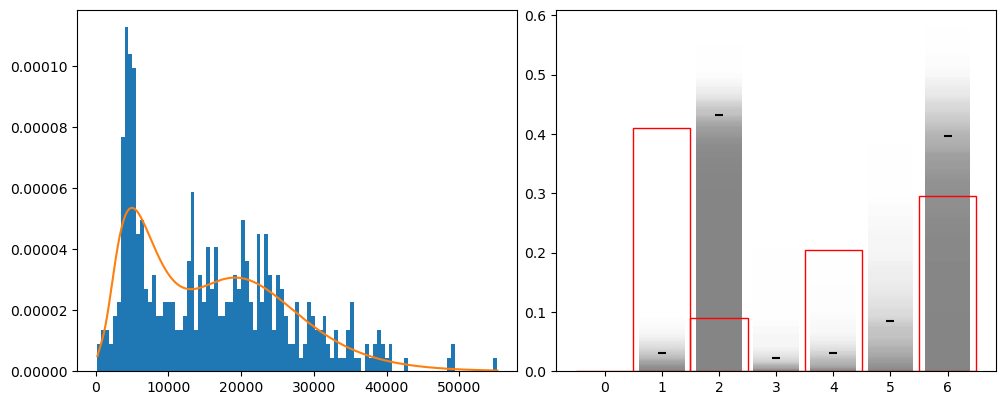

In [41]:
data = {
    "num_spots": method1_intensities_md.shape[0],
    "highest_oligomer": 6,
    "spot_intensities": method1_intensities_md - np.min(method1_intensities_md),
}
# inits = {"background_level": -np.exp(background_mle_md.optimized_params_dict["background_mu"] - background_mle_md.optimized_params_dict["background_sigma"] ** 2)}
combined_approx_ra_model_fit_md = combined_approx_ra_model.sample(
    data, threads_per_chain=num_threads_per_chain
)

f, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(method1_intensities_md, bins=data["num_spots"] // 4, density=True)
xvals = np.linspace(np.min(method1_intensities_md), np.max(method1_intensities_md), 10000)
axes[0].plot(
    xvals,
    approx_ra_mean_pdf(
        xvals,
        combined_approx_ra_model_fit_md,
        np.min(method1_intensities_md),
        data["highest_oligomer"],
    ),
)

xvals = np.arange(data["highest_oligomer"]) + 1
for draw in combined_approx_ra_model_fit_md.draws().reshape(
    -1, combined_approx_ra_model_fit_md.draws().shape[-1]
)[::33, :]:
    heights = [
        draw[combined_approx_ra_model_fit_md.column_names.index("p_oligomer[" + str(i + 1) + "]")]
        for i in range(data["highest_oligomer"])
    ]
    axes[1].bar(xvals, heights, color="black", alpha=0.004)
axes[1].scatter(
    xvals,
    np.mean(
        combined_approx_ra_model_fit_md.draws().reshape(
            -1, combined_approx_ra_model_fit_md.draws().shape[-1]
        )[
            :,
            combined_approx_ra_model_fit_md.column_names.index(
                "p_oligomer[1]"
            ) : combined_approx_ra_model_fit_md.column_names.index(
                "p_oligomer[" + str(data["highest_oligomer"]) + "]"
            )
            + 1,
        ],
        axis=0,
    ),
    color="black",
    marker="_",
)
axes[1].hist(
    num_fluorophores,
    bins=np.arange(np.max(oligomeric_states) + 2) - 0.5,
    color=(0, 0, 0, 0),
    edgecolor="red",
    density=True,
)
f.tight_layout(pad=0.5)

combined_approx_ra_model_fit_md.summary()

21:03:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


21:05:07 - cmdstanpy - INFO - CmdStan done processing.
21:05:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: Exception: lognormal_lpdf: Random variable is -0.196704, but must be nonnegative! (in '/home/kent/fit_combined_approx_ra.stan', line 17, column 16 to line 22, column 76) (in '/home/kent/fit_combined_approx_ra.stan', line 63, column 4 to line 65, column 44)
	Exception: Exception: lognormal_lpdf: Random variable is -0.407305, but must be nonnegative! (in '/home/kent/fit_combined_approx_ra.stan', line 17, column 16 to line 22, column 76) (in '/home/kent/fit_combined_approx_ra.stan', line 63, column 4 to line 65, column 44)
	Exception: Exception: lognormal_lpdf: Random variable is -1.29548, but must be nonnegative! (in '/home/kent/fit_combined_approx_ra.stan', line 17, column 16 to line 22, column 76) (in '/home/kent/fit_combined_approx_ra.stan', line 63, column 4 to line 65, column 44)
	Exception: Exception: lognormal_lpdf: Random variable is -1.13386, but mu

21:05:07 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 40 divergent transitions (4.0%)
	Use function "diagnose()" to see further information.


Mean        MCSE       StdDev           5%  \
lp__             -4139.270000    0.995064     3.139110 -4144.160000   
background_level -2289.880000  284.203000  1144.660000 -4558.350000   
monomer_mu           8.327870    0.137054     0.290065     8.078330   
sigma                0.551913    0.055282     0.127700     0.260033   
p_oligomer[1]        0.070619    0.049846     0.104637     0.002106   
p_oligomer[2]        0.379363    0.065836     0.137268     0.007011   
p_oligomer[3]        0.042171    0.022896     0.071814     0.001377   
p_oligomer[4]        0.084105    0.056465     0.130838     0.002393   
p_oligomer[5]        0.073992    0.002080     0.069311     0.004110   
p_oligomer[6]        0.349750    0.064506     0.147167     0.010632   
p_bright             0.951980    0.041860     0.093530     0.720700   

                          50%          95%       N_Eff    N_Eff/s    R_hat  
lp__             -4139.370000 -4132.700000     9.95200   0.150756  1.34145  
background_level -2049.400000  -871.879000    16.22160   0.245729  1.15428  
monomer_mu           8.226950     9.067860     4.47930   0.067854  2.30961  
sigma                0.585618     0.700758     5.33601   0.080832  1.75874  
p_oligomer[1]        0.030008     0.342954     4.40670   0.066754  2.48785  
p_oligomer[2]        0.425399     0.489144     4.34727   0.065854  2.88672  
p_oligomer[3]        0.019623     0.188343     9.83768   0.149024  1.31868  
p_oligomer[4]        0.034431     0.442356     5.36929   0.081336  2.03947  
p_oligomer[5]        0.053509     0.209530  1110.02000  16.814900  1.00018  
p_oligomer[6]        0.401747     0.494026     5.20499   0.078847  1.88471  
p_bright             0.985630     0.998830     4.99169   0.075620  1.99745

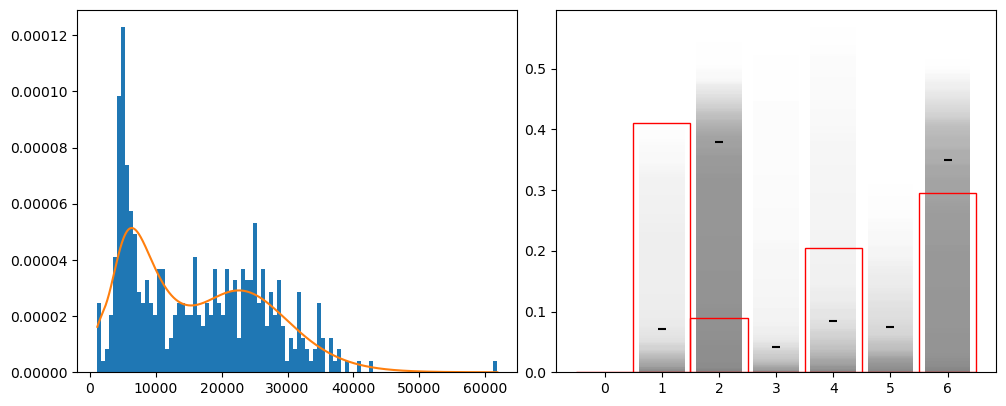

In [42]:
data = {
    "num_spots": method1_intensities_ra.shape[0],
    "highest_oligomer": 6,
    "spot_intensities": method1_intensities_ra - np.min(method1_intensities_ra),
}
# inits = {"background_level": -np.exp(background_mle_ra.optimized_params_dict["background_mu"] - background_mle_ra.optimized_params_dict["background_sigma"] ** 2)}
combined_approx_ra_model_fit_ra = combined_approx_ra_model.sample(
    data, threads_per_chain=num_threads_per_chain
)

f, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(method1_intensities_ra, bins=data["num_spots"] // 4, density=True)
xvals = np.linspace(np.min(method1_intensities_ra), np.max(method1_intensities_ra), 10000)
axes[0].plot(
    xvals,
    approx_ra_mean_pdf(
        xvals,
        combined_approx_ra_model_fit_ra,
        np.min(method1_intensities_ra),
        data["highest_oligomer"],
    ),
)

xvals = np.arange(data["highest_oligomer"]) + 1
for draw in combined_approx_ra_model_fit_ra.draws().reshape(
    -1, combined_approx_ra_model_fit_ra.draws().shape[-1]
)[::33, :]:
    heights = [
        draw[combined_approx_ra_model_fit_ra.column_names.index("p_oligomer[" + str(i + 1) + "]")]
        for i in range(data["highest_oligomer"])
    ]
    axes[1].bar(xvals, heights, color="black", alpha=0.004)
axes[1].scatter(
    xvals,
    np.mean(
        combined_approx_ra_model_fit_ra.draws().reshape(
            -1, combined_approx_ra_model_fit_ra.draws().shape[-1]
        )[
            :,
            combined_approx_ra_model_fit_ra.column_names.index(
                "p_oligomer[1]"
            ) : combined_approx_ra_model_fit_ra.column_names.index(
                "p_oligomer[" + str(data["highest_oligomer"]) + "]"
            )
            + 1,
        ],
        axis=0,
    ),
    color="black",
    marker="_",
)
axes[1].hist(
    num_fluorophores,
    bins=np.arange(np.max(oligomeric_states) + 2) - 0.5,
    color=(0, 0, 0, 0),
    edgecolor="red",
    density=True,
)
f.tight_layout(pad=0.5)

combined_approx_ra_model_fit_ra.summary()

In [43]:
modelcode = """
functions {
    real partial_sum_oligomers_lpdf(array[] real slice_spot_intensities,
                                    int start, int end,
                                    int highest_oligomer,
                                    vector lps_precomputed,
                                    real background_level,
                                    real background_mu,
                                    real background_sigma,
                                    real monomer_mu, real sigma) {
        vector[((highest_oligomer * (highest_oligomer + 1))%/%2)] lps;
        vector[highest_oligomer] lognormal_precomputed;
        int ravel;
        real sum = 0.0;
        for (i in 1:(end - start)) {
            ravel = 1;
            // precompute lognormal_lupdf
            for (n in 1:highest_oligomer) {
                lognormal_precomputed[n] = lognormal_lupdf(slice_spot_intensities[i] -
                                                           background_level |
                                                           log_sum_exp((background_mu + background_sigma ^ 2 / 2.0),
                                                                       (log(n) + monomer_mu + sigma ^ 2 / 2.0)) -
                                                           (log((exp(2.0 * background_mu + background_sigma ^ 2) *
                                                                 (exp(background_sigma ^ 2) - 1) +
                                                                 n * exp(2.0 * monomer_mu + sigma ^ 2) *
                                                                 (exp(sigma ^ 2) - 1)) /
                                                                (exp(background_mu + background_sigma ^ 2 / 2.0) +
                                                                 n * exp(monomer_mu + sigma ^ 2 / 2.0)) ^ 2 + 1)) / 2.0,
                                                           sqrt(log((exp(2.0 * background_mu + background_sigma ^ 2) *
                                                                     (exp(background_sigma ^ 2) - 1) +
                                                                     n * exp(2.0 * monomer_mu + sigma ^ 2) *
                                                                     (exp(sigma ^ 2) - 1)) /
                                                                    (exp(background_mu + background_sigma ^ 2 / 2.0) +
                                                                     n * exp(monomer_mu + sigma ^ 2 / 2.0)) ^ 2 + 1)));
            }
            for (k in 1:highest_oligomer) { // num total
                for (j in 1:k) { // num bright
                    lps[ravel] = lognormal_precomputed[j] + lps_precomputed[ravel];
                    ravel += 1;
                }
            }
            sum += log_sum_exp(lps);
        }
        return sum;
    }
    real partial_sum_monomers_lpdf(array[] real slice_monomeric_spot_intensities,
                                   int start, int end,
                                   real background_level,
                                   real background_mu,
                                   real background_sigma,
                                   real monomer_mu, real sigma) {
        array[end - start] real slice_monomeric_spot_intensities_subtracted;
        for (i in 1:(end - start)) {
            slice_monomeric_spot_intensities_subtracted[i] = slice_monomeric_spot_intensities[i] - background_level;
        }
        return lognormal_lupdf(slice_monomeric_spot_intensities_subtracted |
                               log_sum_exp((background_mu + background_sigma ^ 2 / 2.0),
                                           (monomer_mu + sigma ^ 2 / 2.0)) -
                               (log((exp(2.0 * background_mu + background_sigma ^ 2) *
                                     (exp(background_sigma ^ 2) - 1) +
                                     exp(2.0 * monomer_mu + sigma ^ 2) *
                                     (exp(sigma ^ 2) - 1)) /
                                    (exp(background_mu + background_sigma ^ 2 / 2.0) +
                                     exp(monomer_mu + sigma ^ 2 / 2.0)) ^ 2 + 1)) / 2.0,
                               sqrt(log((exp(2.0 * background_mu + background_sigma ^ 2) *
                                         (exp(background_sigma ^ 2) - 1) +
                                         exp(2.0 * monomer_mu + sigma ^ 2) *
                                         (exp(sigma ^ 2) - 1)) /
                                        (exp(background_mu + background_sigma ^ 2 / 2.0) +
                                         exp(monomer_mu + sigma ^ 2 / 2.0)) ^ 2 + 1)));
    }
}
data {
    int<lower=1> num_spots;
    //int<lower=1> num_monomeric_spots;
    int<lower=1> highest_oligomer;
    array[num_spots] real<lower=0> spot_intensities;
    //array[num_monomeric_spots] real<lower=0> monomeric_spot_intensities;
}

parameters {
    real background_level;
    real<lower=0> background_mu;
    real<lower=0> background_sigma;
    real<lower=0> monomer_mu;
    real<lower=0> sigma;
    simplex[highest_oligomer] p_oligomer;
    real<lower=0,upper=1> p_bright;
}

model {
    vector[highest_oligomer] log_p_oligomer = log(p_oligomer);
    vector[((highest_oligomer * (highest_oligomer + 1))%/%2)] lps_precomputed;
    int ravel = 1;
    // precompute binomial terms
    for (k in 1:highest_oligomer) { // num total
        for (j in 1:k) { // num bright
            lps_precomputed[ravel] = log_p_oligomer[k];
            // subtracting the log complementary CDF accounts for
            // the 0 population being censored
            lps_precomputed[ravel] += binomial_lpmf(j | k, p_bright) -
                                      binomial_lccdf(0 | k, p_bright);
            ravel += 1;
        }
    }
    target += reduce_sum(partial_sum_oligomers_lupdf, spot_intensities, 64,
                         highest_oligomer, lps_precomputed, background_level,
                         background_mu, background_sigma, monomer_mu, sigma);
    //target += reduce_sum(partial_sum_monomers_lupdf, monomeric_spot_intensities, 64,
    //                     background_level, background_mu, background_sigma,
    //                     monomer_mu, sigma);
}
"""

filename = "fit_combined_full_mm_background.stan"

with open(filename, "w") as f:
    f.write(modelcode)

if num_threads_per_chain > 1:
    combined_full_mm_background_model = CmdStanModel(
        stan_file=filename, cpp_options={"STAN_THREADS": True}
    )
else:
    combined_approx_ra_model = CmdStanModel(stan_file=filename)
combined_full_mm_background_model.compile()

21:05:09 - cmdstanpy - INFO - compiling stan file /home/kent/fit_combined_full_mm_background.stan to exe file /home/kent/fit_combined_full_mm_background
21:05:31 - cmdstanpy - INFO - compiled model executable: /home/kent/fit_combined_full_mm_background


21:05:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


21:19:34 - cmdstanpy - INFO - CmdStan done processing.
21:19:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_full_mm_background.stan', line 19, column 16 to line 34, column 119) (in '/home/kent/fit_combined_full_mm_background.stan', line 106, column 4 to line 108, column 77)
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_full_mm_background.stan', line 19, column 16 to line 34, column 119) (in '/home/kent/fit_combined_full_mm_background.stan', line 106, column 4 to line 108, column 77)
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_full_mm_background.stan', line 19, column 16 to line 34, column 119) (in '/home/kent/fit_combined_full_mm_background.stan', line 106, column 4 to line 108, column 77)
	Exception: Exception: lognorma

21:19:34 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 43 divergent transitions (4.3%)
	Chain 2 had 28 divergent transitions (2.8%)
	Chain 3 had 58 divergent transitions (5.8%)
	Chain 4 had 69 divergent transitions (6.9%)
	Use function "diagnose()" to see further information.


(array([0.   , 0.41 , 0.09 , 0.   , 0.204, 0.   , 0.296]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5]),
 <BarContainer object of 7 artists>)

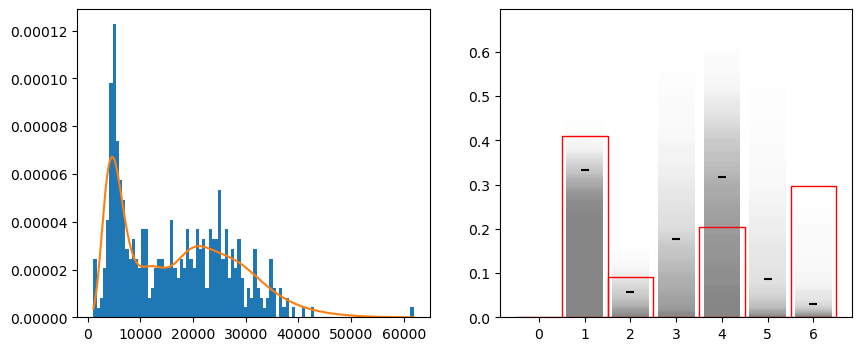

In [44]:
data = {
    "num_spots": method1_intensities_ra.shape[0],
    "highest_oligomer": 6,
    "spot_intensities": method1_intensities_ra - np.min(method1_intensities_ra),
}
inits = {
    "background_level": -np.exp(
        background_mle_ra.optimized_params_dict["background_mu"]
        - background_mle_ra.optimized_params_dict["background_sigma"] ** 2
    ),
    "background_mu": background_mle_ra.optimized_params_dict["background_mu"],
    "background_sigma": background_mle_ra.optimized_params_dict["background_sigma"],
}

combined_full_mm_background_model_fit_ra = combined_full_mm_background_model.sample(
    data, inits=inits, threads_per_chain=num_threads_per_chain
)

background_mu_est = get_sample_mean(combined_full_mm_background_model_fit_ra, "background_mu")
background_sigma_est = get_sample_mean(combined_full_mm_background_model_fit_ra, "background_sigma")
monomer_mu_est = get_sample_mean(combined_full_mm_background_model_fit_ra, "monomer_mu")
sigma_est = get_sample_mean(combined_full_mm_background_model_fit_ra, "sigma")

f, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(method1_intensities_ra, bins=data["num_spots"] // 4, density=True)
xvals = np.linspace(np.min(method1_intensities_ra), np.max(method1_intensities_ra), 10000)
yvals = np.zeros(xvals.shape)
for i in range(data["highest_oligomer"]):
    for j in range(i + 1):
        yvals += (
            np.mean(
                combined_full_mm_background_model_fit_ra.draws()[
                    :,
                    :,
                    combined_full_mm_background_model_fit_ra.column_names.index(
                        "p_oligomer[" + str(i + 1) + "]"
                    ),
                ]
            )
            * binom.pmf(
                j,
                i,
                np.mean(
                    combined_full_mm_background_model_fit_ra.draws()[
                        :,
                        :,
                        combined_full_mm_background_model_fit_ra.column_names.index("p_bright"),
                    ]
                ),
            )
            * lognorm.pdf(
                xvals
                - np.min(method1_intensities_ra)
                - np.mean(
                    combined_full_mm_background_model_fit_ra.draws()[
                        :,
                        :,
                        combined_full_mm_background_model_fit_ra.column_names.index(
                            "background_level"
                        ),
                    ]
                ),
                s=np.sqrt(
                    np.log(
                        (
                            np.exp(2.0 * background_mu_est + background_sigma_est**2)
                            * (np.exp(background_sigma_est**2) - 1)
                            + (j + 1)
                            * np.exp(2.0 * monomer_mu_est + sigma_est**2)
                            * (np.exp(sigma_est**2) - 1)
                        )
                        / (
                            np.exp(background_mu_est + background_sigma_est**2 / 2.0)
                            + (j + 1) * np.exp(monomer_mu_est + sigma_est**2 / 2.0)
                        )
                        ** 2
                        + 1
                    )
                ),
                scale=np.exp(
                    np.log(
                        np.exp(background_mu_est + background_sigma_est**2 / 2.0)
                        + (j + 1) * np.exp(monomer_mu_est + sigma_est**2 / 2.0)
                    )
                    - (
                        np.log(
                            (
                                np.exp(2.0 * background_mu_est + background_sigma_est**2)
                                * (np.exp(background_sigma_est**2) - 1)
                                + (j + 1)
                                * np.exp(2.0 * monomer_mu_est + sigma_est**2)
                                * (np.exp(sigma_est**2) - 1)
                            )
                            / (
                                np.exp(background_mu_est + background_sigma_est**2 / 2.0)
                                + (j + 1) * np.exp(monomer_mu_est + sigma_est**2 / 2.0)
                            )
                            ** 2
                            + 1
                        )
                    )
                    / 2.0
                ),
            )
        )
axes[0].plot(xvals, yvals)

xvals = np.arange(data["highest_oligomer"]) + 1
for draw in combined_full_mm_background_model_fit_ra.draws().reshape(
    -1, combined_full_mm_background_model_fit_ra.draws().shape[-1]
)[::33, :]:
    heights = [
        draw[
            combined_full_mm_background_model_fit_ra.column_names.index(
                "p_oligomer[" + str(i + 1) + "]"
            )
        ]
        for i in range(data["highest_oligomer"])
    ]
    axes[1].bar(xvals, heights, color="black", alpha=0.004)
axes[1].scatter(
    xvals,
    np.mean(
        combined_full_mm_background_model_fit_ra.draws().reshape(
            -1, combined_full_mm_background_model_fit_ra.draws().shape[-1]
        )[
            :,
            combined_full_mm_background_model_fit_ra.column_names.index(
                "p_oligomer[1]"
            ) : combined_full_mm_background_model_fit_ra.column_names.index(
                "p_oligomer[" + str(data["highest_oligomer"]) + "]"
            )
            + 1,
        ],
        axis=0,
    ),
    color="black",
    marker="_",
)
axes[1].hist(
    num_fluorophores,
    bins=np.arange(np.max(oligomeric_states) + 2) - 0.5,
    color=(0, 0, 0, 0),
    edgecolor="red",
    density=True,
)

Text(0.5, 1.0, 'true spot histogram')

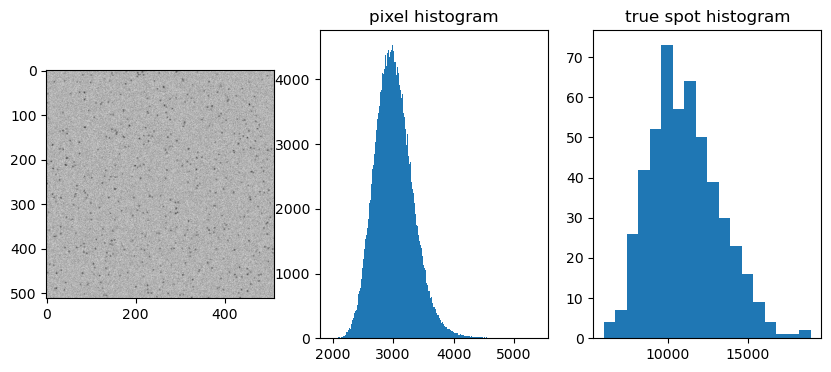

In [45]:
background_monomeric = rng.lognormal(background_mu, background_sigma, image_dims)

spot_images_monomeric = np.zeros((num_spots, *image_dims))
intensities_monomeric = np.zeros(num_spots)
spot_centers_monomeric = np.empty((intensities_monomeric.shape[0], 2))
for i in range(num_spots):
    spot_centers_monomeric[i] = (
        rng.uniform(0.0, image_dims[0]),
        rng.uniform(0.0, image_dims[1]),
    )
    intensity = rng.lognormal(monomer_mu, monomer_sigma)
    intensities_monomeric[i] = intensity
    spot_images_monomeric[i] += (
        intensity
        * (
            norm.cdf(yvals_upper, spot_centers_monomeric[i, 0], spot_sigma)
            - norm.cdf(yvals_lower, spot_centers_monomeric[i, 0], spot_sigma)
        )[:, np.newaxis]
        * (
            norm.cdf(xvals_upper, spot_centers_monomeric[i, 1], spot_sigma)
            - norm.cdf(xvals_lower, spot_centers_monomeric[i, 1], spot_sigma)
        )[np.newaxis, :]
    )
image_monomeric = np.sum(spot_images_monomeric, axis=0) + background_monomeric

f, axes = plt.subplots(1, 3, figsize=(10, 4))
axes[0].imshow(image_monomeric, cmap="binary")
axes[1].hist(image_monomeric.flatten(), bins="auto")
axes[1].set_title("pixel histogram")
axes[2].hist(intensities_monomeric, bins="auto")
axes[2].set_title("true spot histogram")

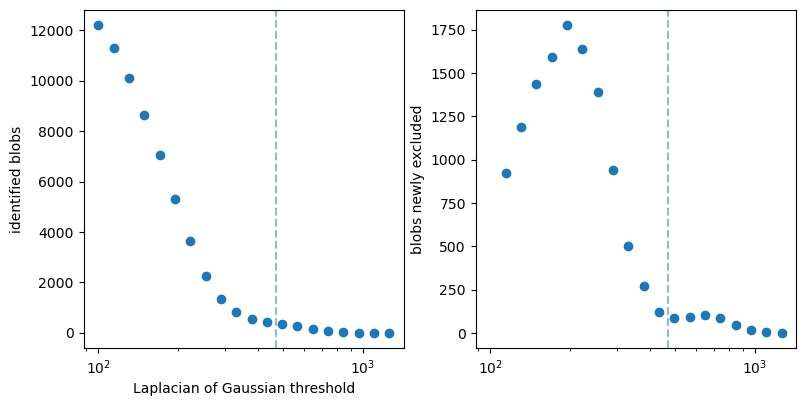

In [46]:
def blob_log_fixedargs(threshold):
    return blob_log(
        image_monomeric,
        threshold=threshold,
        min_sigma=sigma_guess / sigma_range,
        max_sigma=sigma_guess * sigma_range,
        num_sigma=40,
    )


with Pool(num_cores) as pool:
    blobs_log_monomeric = pool.map(blob_log_fixedargs, thresholds)
nblobs = np.array([len(blobs) for blobs in blobs_log_monomeric])

f, axes = plt.subplots(1, 2, sharex=True, figsize=(8, 4))
axes[0].scatter(thresholds, nblobs)
axes[1].scatter(thresholds[1:], nblobs[:-1] - nblobs[1:])
axes[0].set_xlabel("Laplacian of Gaussian threshold")
axes[0].set_ylabel("identified blobs")
axes[0].set_xscale("log")
axes[0].axvline(threshold_to_use, ls="dashed", alpha=0.5)
axes[1].axvline(threshold_to_use, ls="dashed", alpha=0.5)
axes[1].set_ylabel("blobs newly excluded")
f.tight_layout(pad=0.5)

Text(0, 0.5, 'estimated intensity of closest spot')

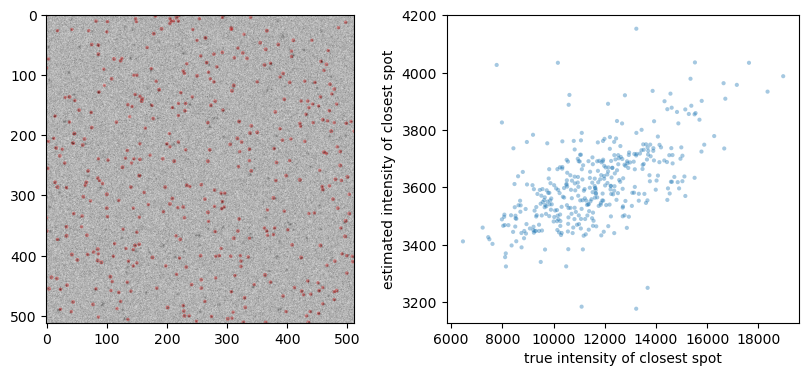

In [47]:
blobs_monomeric = blob_log(
    image_monomeric,
    threshold=threshold_to_use,
    min_sigma=sigma_guess / sigma_range,
    max_sigma=sigma_guess * sigma_range,
    num_sigma=40,
)

f, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(image_monomeric, cmap="binary")

blob_intensities_monomeric = []
closest_intensities_monomeric = []
for blob in blobs_monomeric:
    y, x, r = blob
    blob_intensities_monomeric.append(gaussian_filter(image_monomeric, r)[int(y), int(x)])
    closest_intensities_monomeric.append(
        intensities_monomeric[
            np.argmin(
                np.square(y - spot_centers_monomeric[:, 0])
                + np.square(x - spot_centers_monomeric[:, 1])
            )
        ]
    )
    c = plt.Circle((x, y), r * np.sqrt(2), color="red", linewidth=1, fill=False, alpha=0.3)
    axes[0].add_patch(c)

axes[1].scatter(
    closest_intensities_monomeric,
    blob_intensities_monomeric,
    alpha=0.4,
    edgecolor="none",
    marker=".",
)
axes[1].set_xlabel("true intensity of closest spot")
axes[1].set_ylabel("estimated intensity of closest spot")

Text(0, 0.5, 'true positives')

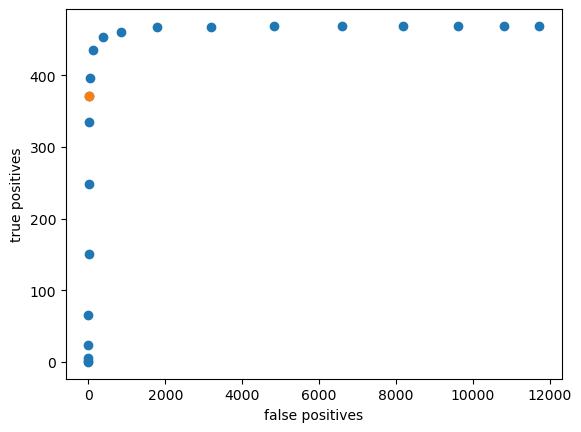

In [48]:
true_positives = []
false_positives = []
for blobs in blobs_log_monomeric:
    true_positive = 0
    false_positive = 0
    for blob in blobs:
        y, x, r = blob
        if (
            np.min(
                np.square(y - spot_centers_monomeric[:, 0])
                + np.square(x - spot_centers_monomeric[:, 1])
            )
            < 2.0 * r
        ):
            true_positive += 1
        else:
            false_positive += 1
    true_positives.append(true_positive)
    false_positives.append(false_positive)

true_positive = 0
false_positive = 0
for blob in blobs_monomeric:
    y, x, r = blob
    if (
        np.min(
            np.square(y - spot_centers_monomeric[:, 0])
            + np.square(x - spot_centers_monomeric[:, 1])
        )
        < 2.0 * r
    ):
        true_positive += 1
    else:
        false_positive += 1
true_positives.append(true_positive)
false_positives.append(false_positive)

plt.scatter(false_positives, true_positives)
plt.scatter(false_positive, true_positive)
plt.xlabel("false positives")
plt.ylabel("true positives")

In [49]:
background_pixels_monomeric = pick_background_pixels(image_monomeric, blobs_monomeric)

data = {
    "num_background_pixels": len(background_pixels_monomeric),
    "background_pixels": background_pixels_monomeric,
}

background_mle_monomeric = background_model.optimize(data)

(
    background_pixels_monomeric,
    image_estimated_monomeric,
) = pick_background_pixels_after_subtracting(
    image_monomeric,
    blobs_monomeric,
    blob_intensities_monomeric,
    np.exp(
        background_mle_monomeric.optimized_params_dict["background_mu"]
        - background_mle_monomeric.optimized_params_dict["background_sigma"] ** 2
    ),
)

data = {
    "num_background_pixels": len(background_pixels_monomeric),
    "background_pixels": background_pixels_monomeric,
}

background_mle_monomeric = background_model.optimize(data)

method1_intensities_monomeric = []
closest_intensities_censored_monomeric = []
method1_blob_sigmas = []

ylocs = np.array([blob[0] for blob in blobs_monomeric])
xlocs = np.array([blob[1] for blob in blobs_monomeric])
for i, blob in enumerate(blobs_monomeric):
    y, x, blob_sigma = blob
    if x >= censor_edge and x < image_dims[0] - censor_edge:
        if y >= censor_edge and y < image_dims[1] - censor_edge:
            if (
                np.sum(np.sqrt(np.square(ylocs - y) + np.square(xlocs - x)) < censor_separation)
                == 1
            ):
                closest_intensities_censored_monomeric.append(closest_intensities_monomeric[i])
                method1_blob_sigmas.append(blob_sigma)
                method1_intensities_monomeric.append(
                    (
                        blob_intensities_monomeric[i]
                        - np.exp(
                            background_mle_monomeric.optimized_params_dict["background_mu"]
                            - background_mle_monomeric.optimized_params_dict["background_sigma"]
                            ** 2
                        )
                    )
                    * 2.0
                    * np.pi
                    * np.square(blob_sigma)
                )

method1_intensities_monomeric = np.array(method1_intensities_monomeric)

21:19:50 - cmdstanpy - INFO - Chain [1] start processing
21:19:50 - cmdstanpy - INFO - Chain [1] done processing
21:19:51 - cmdstanpy - INFO - Chain [1] start processing
21:19:51 - cmdstanpy - INFO - Chain [1] done processing


In [50]:
modelcode = """
functions {
    real partial_sum_oligomers_lpdf(array[] real slice_spot_intensities,
                                    int start, int end,
                                    int highest_oligomer,
                                    vector lps_precomputed,
                                    real background_level,
                                    real monomer_mu, real sigma) {
        vector[((highest_oligomer * (highest_oligomer + 1))%/%2)] lps;
        vector[highest_oligomer] lognormal_precomputed;
        int ravel;
        real sum = 0.0;
        for (i in 1:(end - start)) {
            ravel = 1;
            // precompute lognormal_lupdf
            for (n in 1:highest_oligomer) {
                lognormal_precomputed[n] = lognormal_lupdf(slice_spot_intensities[i] -
                                                           background_level |
                                                           monomer_mu + log(n) + sigma ^ 2 *
                                                           (n - 1) / (2.0 * n), sigma / sqrt(n));
            }
            for (k in 1:highest_oligomer) { // num total
                for (j in 1:k) { // num bright
                    lps[ravel] = lognormal_precomputed[j] + lps_precomputed[ravel];
                    ravel += 1;
                }
            }
            sum += log_sum_exp(lps);
        }
        return sum;
    }
    real partial_sum_monomers_lpdf(array[] real slice_monomeric_spot_intensities,
                                   int start, int end,
                                   real background_level,
                                   real monomer_mu, real sigma) {
        array[end - start] real subtracted_intensities;
        for (i in 1:(end - start)) {
            subtracted_intensities[i] = slice_monomeric_spot_intensities[i] - background_level;
        }
        return lognormal_lupdf(subtracted_intensities | monomer_mu, sigma);
    }
}
data {
    int<lower=1> num_spots;
    int<lower=1> num_monomeric_spots;
    int<lower=1> highest_oligomer;
    array[num_spots] real<lower=0> spot_intensities;
    array[num_monomeric_spots] real<lower=0> monomeric_spot_intensities;
}

parameters {
    real background_level;
    real<lower=0> monomer_mu;
    real<lower=0> sigma;
    simplex[highest_oligomer] p_oligomer;
    real<lower=0,upper=1> p_bright;
}

model {
    vector[highest_oligomer] log_p_oligomer = log(p_oligomer);
    vector[((highest_oligomer * (highest_oligomer + 1))%/%2)] lps_precomputed;
    int ravel = 1;
    // precompute binomial terms
    for (k in 1:highest_oligomer) { // num total
        for (j in 1:k) { // num bright
            lps_precomputed[ravel] = log_p_oligomer[k];
            // subtracting the log complementary CDF accounts for
            // the 0 population being censored
            lps_precomputed[ravel] += binomial_lpmf(j | k, p_bright) -
                                      binomial_lccdf(0 | k, p_bright);
            ravel += 1;
        }
    }
    target += reduce_sum(partial_sum_oligomers_lupdf, spot_intensities, 128,
                         highest_oligomer, lps_precomputed, background_level,
                         monomer_mu, sigma);
    target += reduce_sum(partial_sum_monomers_lupdf, monomeric_spot_intensities, 128,
                         background_level, monomer_mu, sigma);
}
"""

filename = "fit_combined_approx_ra_monomeric.stan"

with open(filename, "w") as f:
    f.write(modelcode)

if num_threads_per_chain > 1:
    combined_approx_ra_monomeric_model = CmdStanModel(
        stan_file=filename, cpp_options={"STAN_THREADS": True}
    )
else:
    combined_approx_ra_monomeric_model = CmdStanModel(stan_file=filename)
combined_approx_ra_monomeric_model.compile()

21:19:51 - cmdstanpy - INFO - compiling stan file /home/kent/fit_combined_approx_ra_monomeric.stan to exe file /home/kent/fit_combined_approx_ra_monomeric
21:20:10 - cmdstanpy - INFO - compiled model executable: /home/kent/fit_combined_approx_ra_monomeric


21:20:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


21:21:27 - cmdstanpy - INFO - CmdStan done processing.
21:21:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: Exception: lognormal_lpdf: Random variable is -0.292791, but must be nonnegative! (in '/home/kent/fit_combined_approx_ra_monomeric.stan', line 17, column 16 to line 20, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric.stan', line 74, column 4 to line 76, column 44)
	Exception: Exception: lognormal_lpdf: Random variable is -0.198042, but must be nonnegative! (in '/home/kent/fit_combined_approx_ra_monomeric.stan', line 17, column 16 to line 20, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric.stan', line 74, column 4 to line 76, column 44)
	Exception: Exception: lognormal_lpdf: Random variable is -1.93878, but must be nonnegative! (in '/home/kent/fit_combined_approx_ra_monomeric.stan', line 17, column 16 to line 20, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric.stan', line 74, column 4 to line 76, column 44)
	Exception: Ex

Mean      MCSE      StdDev           5%          50%  \
lp__             -7594.520000  0.064072    2.337050 -7598.870000 -7594.130000   
background_level -3308.310000  5.400610  259.672000 -3742.940000 -3297.780000   
monomer_mu           9.049370  0.000615    0.030243     9.000590     9.049540   
sigma                0.210729  0.000161    0.008320     0.197691     0.210441   
p_oligomer[1]        0.236127  0.001525    0.056967     0.138813     0.238134   
p_oligomer[2]        0.067600  0.001155    0.056370     0.003685     0.053087   
p_oligomer[3]        0.156143  0.002476    0.117949     0.010214     0.130589   
p_oligomer[4]        0.227862  0.002734    0.134589     0.026387     0.218154   
p_oligomer[5]        0.156410  0.002661    0.126280     0.011986     0.123922   
p_oligomer[6]        0.155858  0.003210    0.134918     0.019745     0.107354   
p_bright             0.602930  0.003180    0.101130     0.456190     0.593720   

                          95%       N_Eff   N_Eff/s     R_hat  
lp__             -7591.360000  1330.43000  20.37670  1.004490  
background_level -2904.440000  2311.88000  35.40830  1.001010  
monomer_mu           9.099880  2415.11000  36.98940  1.001320  
sigma                0.225389  2659.25000  40.72860  0.999819  
p_oligomer[1]        0.324494  1395.96000  21.38020  1.002840  
p_oligomer[2]        0.178680  2380.68000  36.46200  1.000950  
p_oligomer[3]        0.374502  2269.27000  34.75580  1.000670  
p_oligomer[4]        0.458037  2423.22000  37.11360  1.002760  
p_oligomer[5]        0.414804  2252.76000  34.50290  1.001410  
p_oligomer[6]        0.449444  1766.79000  27.05980  1.002480  
p_bright             0.782580  1011.97186  15.49917  1.004110

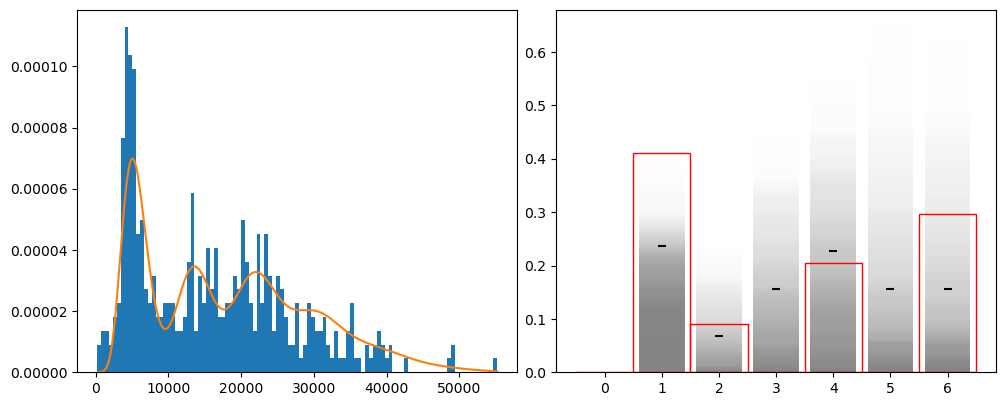

In [51]:
overall_intensity_min_md = min(
    [np.min(method1_intensities_md), np.min(method1_intensities_monomeric)]
)
data = {
    "num_spots": method1_intensities_md.shape[0],
    "num_monomeric_spots": method1_intensities_monomeric.shape[0],
    "highest_oligomer": 6,
    "spot_intensities": method1_intensities_md - overall_intensity_min_md,
    "monomeric_spot_intensities": method1_intensities_monomeric - overall_intensity_min_md,
}
combined_approx_ra_monomeric_model_fit_md = combined_approx_ra_monomeric_model.sample(
    data, threads_per_chain=num_threads_per_chain
)

f, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(method1_intensities_md, bins=data["num_spots"] // 4, density=True)
xvals = np.linspace(overall_intensity_min_md, np.max(method1_intensities_md), 10000)
yvals = np.zeros(xvals.shape)
for i in range(data["highest_oligomer"]):
    for j in range(i + 1):
        yvals += (
            np.mean(
                combined_approx_ra_monomeric_model_fit_md.draws()[
                    :,
                    :,
                    combined_approx_ra_monomeric_model_fit_md.column_names.index(
                        "p_oligomer[" + str(i + 1) + "]"
                    ),
                ]
            )
            * binom.pmf(
                j,
                i,
                np.mean(
                    combined_approx_ra_monomeric_model_fit_md.draws()[
                        :,
                        :,
                        combined_approx_ra_monomeric_model_fit_md.column_names.index("p_bright"),
                    ]
                ),
            )
            * lognorm.pdf(
                xvals
                - overall_intensity_min_md
                - np.mean(
                    combined_approx_ra_monomeric_model_fit_md.draws()[
                        :,
                        :,
                        combined_approx_ra_monomeric_model_fit_md.column_names.index(
                            "background_level"
                        ),
                    ]
                ),
                s=np.mean(
                    combined_approx_ra_monomeric_model_fit_md.draws()[
                        :,
                        :,
                        combined_approx_ra_monomeric_model_fit_md.column_names.index("sigma"),
                    ]
                )
                / np.sqrt(j + 1),
                scale=(j + 1)
                * np.exp(
                    np.mean(
                        combined_approx_ra_monomeric_model_fit_md.draws()[
                            :,
                            :,
                            combined_approx_ra_monomeric_model_fit_md.column_names.index(
                                "monomer_mu"
                            ),
                        ]
                    )
                ),
            )
        )
axes[0].plot(xvals, yvals)

xvals = np.arange(data["highest_oligomer"]) + 1
for draw in combined_approx_ra_monomeric_model_fit_md.draws().reshape(
    -1, combined_approx_ra_monomeric_model_fit_md.draws().shape[-1]
)[::33, :]:
    heights = [
        draw[
            combined_approx_ra_monomeric_model_fit_md.column_names.index(
                "p_oligomer[" + str(i + 1) + "]"
            )
        ]
        for i in range(data["highest_oligomer"])
    ]
    axes[1].bar(xvals, heights, color="black", alpha=0.004)
axes[1].scatter(
    xvals,
    np.mean(
        combined_approx_ra_monomeric_model_fit_md.draws().reshape(
            -1, combined_approx_ra_monomeric_model_fit_md.draws().shape[-1]
        )[
            :,
            combined_approx_ra_monomeric_model_fit_md.column_names.index(
                "p_oligomer[1]"
            ) : combined_approx_ra_monomeric_model_fit_md.column_names.index(
                "p_oligomer[" + str(data["highest_oligomer"]) + "]"
            )
            + 1,
        ],
        axis=0,
    ),
    color="black",
    marker="_",
)
axes[1].hist(
    num_fluorophores,
    bins=np.arange(np.max(oligomeric_states) + 2) - 0.5,
    color=(0, 0, 0, 0),
    edgecolor="red",
    density=True,
)
f.tight_layout(pad=0.5)

combined_approx_ra_monomeric_model_fit_md.summary()

21:21:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


21:23:04 - cmdstanpy - INFO - CmdStan done processing.
21:23:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: Exception: lognormal_lpdf: Random variable is -1.73542, but must be nonnegative! (in '/home/kent/fit_combined_approx_ra_monomeric.stan', line 17, column 16 to line 20, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric.stan', line 74, column 4 to line 76, column 44)
	Exception: Exception: lognormal_lpdf: Random variable is -0.827036, but must be nonnegative! (in '/home/kent/fit_combined_approx_ra_monomeric.stan', line 17, column 16 to line 20, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric.stan', line 74, column 4 to line 76, column 44)
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric.stan', line 17, column 16 to line 20, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric.stan', line 74, column 4 to line 76, column 44)
	Exception: Exception

Mean       MCSE      StdDev           5%  \
lp__             -7433.920000   0.064344    2.308830 -7438.260000   
background_level -3315.710000  19.766400  589.041000 -4263.740000   
monomer_mu           8.958190   0.002674    0.080329     8.828040   
sigma                0.227972   0.000540    0.017350     0.202120   
p_oligomer[1]        0.307253   0.000991    0.038933     0.241460   
p_oligomer[2]        0.059566   0.000992    0.044835     0.004397   
p_oligomer[3]        0.123213   0.002708    0.102523     0.007669   
p_oligomer[4]        0.321532   0.004416    0.148590     0.051736   
p_oligomer[5]        0.138591   0.004506    0.143868     0.004557   
p_oligomer[6]        0.049844   0.001953    0.070589     0.004151   
p_bright             0.728080   0.002540    0.083480     0.591620   

                          50%          95%       N_Eff   N_Eff/s     R_hat  
lp__             -7433.510000 -7430.910000  1287.57000  12.69250  1.004020  
background_level -3298.410000 -2394.850000   888.04500   8.75412  1.005250  
monomer_mu           8.961030     9.080350   902.21300   8.89379  1.005190  
sigma                0.226839     0.257757  1033.93000  10.19230  1.003560  
p_oligomer[1]        0.308259     0.368694  1543.38000  15.21430  1.003270  
p_oligomer[2]        0.050323     0.144920  2043.67000  20.14600  1.002080  
p_oligomer[3]        0.094435     0.325962  1433.82000  14.13430  0.999761  
p_oligomer[4]        0.332480     0.545871  1132.10000  11.16000  1.003730  
p_oligomer[5]        0.080226     0.450748  1019.47000  10.04970  1.003350  
p_oligomer[6]        0.027316     0.173062  1306.02000  12.87440  1.004610  
p_bright             0.727300     0.870890  1080.03334  10.64670  1.007190

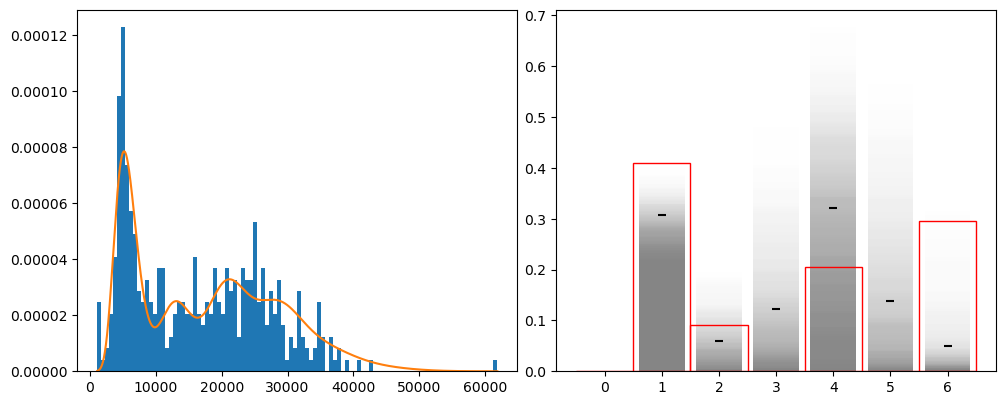

In [52]:
overall_intensity_min_ra = min(
    [np.min(method1_intensities_ra), np.min(method1_intensities_monomeric)]
)
data = {
    "num_spots": method1_intensities_ra.shape[0],
    "num_monomeric_spots": method1_intensities_monomeric.shape[0],
    "highest_oligomer": 6,
    "spot_intensities": method1_intensities_ra - overall_intensity_min_ra,
    "monomeric_spot_intensities": method1_intensities_monomeric - overall_intensity_min_ra,
}
combined_approx_ra_monomeric_model_fit_ra = combined_approx_ra_monomeric_model.sample(
    data, threads_per_chain=num_threads_per_chain
)

f, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(method1_intensities_ra, bins=data["num_spots"] // 4, density=True)
xvals = np.linspace(overall_intensity_min_ra, np.max(method1_intensities_ra), 10000)
axes[0].plot(
    xvals,
    approx_ra_mean_pdf(
        xvals,
        combined_approx_ra_monomeric_model_fit_ra,
        overall_intensity_min_ra,
        data["highest_oligomer"],
    ),
)

xvals = np.arange(data["highest_oligomer"]) + 1
for draw in combined_approx_ra_monomeric_model_fit_ra.draws().reshape(
    -1, combined_approx_ra_monomeric_model_fit_ra.draws().shape[-1]
)[::33, :]:
    heights = [
        draw[
            combined_approx_ra_monomeric_model_fit_ra.column_names.index(
                "p_oligomer[" + str(i + 1) + "]"
            )
        ]
        for i in range(data["highest_oligomer"])
    ]
    axes[1].bar(xvals, heights, color="black", alpha=0.004)
axes[1].scatter(
    xvals,
    np.mean(
        combined_approx_ra_monomeric_model_fit_ra.draws().reshape(
            -1, combined_approx_ra_monomeric_model_fit_ra.draws().shape[-1]
        )[
            :,
            combined_approx_ra_monomeric_model_fit_ra.column_names.index(
                "p_oligomer[1]"
            ) : combined_approx_ra_monomeric_model_fit_ra.column_names.index(
                "p_oligomer[" + str(data["highest_oligomer"]) + "]"
            )
            + 1,
        ],
        axis=0,
    ),
    color="black",
    marker="_",
)
axes[1].hist(
    num_fluorophores,
    bins=np.arange(np.max(oligomeric_states) + 2) - 0.5,
    color=(0, 0, 0, 0),
    edgecolor="red",
    density=True,
)
f.tight_layout(pad=0.5)

combined_approx_ra_monomeric_model_fit_ra.summary()

In [53]:
modelcode = """
functions {
    real partial_sum_oligomers_lpdf(array[] real slice_spot_intensities,
                                    int start, int end,
                                    int num_terms,
                                    int highest_oligomer,
                                    int[] oligomer_allowed,
                                    vector lps_precomputed,
                                    real background_level,
                                    real monomer_mu, real sigma) {
        vector[num_terms] lps;
        vector[highest_oligomer] lognormal_precomputed;
        int ravel;
        real sum = 0.0;
        for (i in 1:(end - start)) {
            ravel = 1;
            // precompute lognormal_lupdf
            for (n in 1:highest_oligomer) {
                lognormal_precomputed[n] = lognormal_lupdf(slice_spot_intensities[i] -
                                                           background_level |
                                                           monomer_mu + log(n) + sigma ^ 2 *
                                                           (n - 1) / (2.0 * n), sigma / sqrt(n));
            }
            for (k in 1:highest_oligomer) { // num total
                if (oligomer_allowed[k]) {
                    for (j in 1:k) { // num bright
                        lps[ravel] = lognormal_precomputed[j] + lps_precomputed[ravel];
                        ravel += 1;
                    }
                }
            }
            sum += log_sum_exp(lps);
        }
        return sum;
    }
    real partial_sum_monomers_lpdf(array[] real slice_monomeric_spot_intensities,
                                   int start, int end,
                                   real background_level,
                                   real monomer_mu, real sigma) {
        array[end - start] real subtracted_intensities;
        for (i in 1:(end - start)) {
            subtracted_intensities[i] = slice_monomeric_spot_intensities[i] - background_level;
        }
        return lognormal_lupdf(subtracted_intensities | monomer_mu, sigma);
    }
}
data {
    int<lower=1> num_spots;
    int<lower=1> num_monomeric_spots;
    int<lower=1> highest_oligomer;
    array[num_spots] real<lower=0> spot_intensities;
    array[num_monomeric_spots] real<lower=0> monomeric_spot_intensities;
    array[highest_oligomer] int<lower=0,upper=1> oligomer_allowed;
}
transformed data {
    int num_terms = 0;
    for (k in 1:highest_oligomer) { // num total
        if (oligomer_allowed[k]) {
            for (j in 1:k) { // num bright
                num_terms += 1;
            }
        }
    }
}
parameters {
    real background_level;
    real<lower=0> monomer_mu;
    real<lower=0> sigma;
    simplex[sum(oligomer_allowed)] p_oligomer;
    real<lower=0,upper=1> p_bright;
}
model {
    vector[sum(oligomer_allowed)] log_p_oligomer = log(p_oligomer);
    vector[num_terms] lps_precomputed;
    int ravel = 1;
    int allowed_index = 1;
    // precompute binomial terms
    for (k in 1:highest_oligomer) { // num total
        if (oligomer_allowed[k]) {
            for (j in 1:k) { // num bright
                lps_precomputed[ravel] = log_p_oligomer[allowed_index];
                // subtracting the log complementary CDF accounts for
                // the 0 population being censored
                lps_precomputed[ravel] += binomial_lpmf(j | k, p_bright) -
                                          binomial_lccdf(0 | k, p_bright);
                ravel += 1;
            }
            allowed_index += 1;
        }
    }
    target += reduce_sum(partial_sum_oligomers_lupdf, spot_intensities, 64,
                         num_terms, highest_oligomer, oligomer_allowed,
                         lps_precomputed, background_level, monomer_mu, sigma);
    target += reduce_sum(partial_sum_monomers_lupdf, monomeric_spot_intensities, 64,
                         background_level, monomer_mu, sigma);
}
generated quantities {
    //vector[num_spots + num_monomeric_spots] log_lik;
    vector[num_spots] log_lik;
    vector[sum(oligomer_allowed)] log_p_oligomer = log(p_oligomer);
    vector[num_terms] lps_precomputed;
    vector[num_terms] lps;
    vector[highest_oligomer] lognormal_precomputed;
    int ravel = 1;
    int allowed_index = 1;
    // precompute binomial terms
    for (k in 1:highest_oligomer) { // num total
        if (oligomer_allowed[k]) {
            for (j in 1:k) { // num bright
                lps_precomputed[ravel] = log_p_oligomer[allowed_index];
                // subtracting the log complementary CDF accounts for
                // the 0 population being censored
                lps_precomputed[ravel] += binomial_lpmf(j | k, p_bright) -
                                          binomial_lccdf(0 | k, p_bright);
                ravel += 1;
            }
            allowed_index += 1;
        }
    }
    for (i in 1:num_spots) {
        ravel = 1;
        // precompute lognormal_lupdf
        for (n in 1:highest_oligomer) {
            lognormal_precomputed[n] = lognormal_lpdf(spot_intensities[i] -
                                                      background_level |
                                                      monomer_mu + log(n) + sigma ^ 2 *
                                                      (n - 1) / (2.0 * n), sigma / sqrt(n));
        }
        for (k in 1:highest_oligomer) { // num total
            if (oligomer_allowed[k]) {
                for (j in 1:k) { // num bright
                    lps[ravel] = lognormal_precomputed[j] + lps_precomputed[ravel];
                    ravel += 1;
                }
            }
        }
        log_lik[i] = log_sum_exp(lps);
    }
    //for (i in 1:num_monomeric_spots) {
    //    log_lik[i + num_spots] = lognormal_lpdf(monomeric_spot_intensities[i] -
    //                                            background_level | monomer_mu, sigma);
    //}
}
"""

filename = "fit_combined_approx_ra_monomeric_allowed_oligomers.stan"

with open(filename, "w") as f:
    f.write(modelcode)

if num_threads_per_chain > 1:
    combined_approx_ra_monomeric_allowed_oligomers_model = CmdStanModel(
        stan_file=filename, cpp_options={"STAN_THREADS": True}
    )
else:
    combined_approx_ra_monomeric_allowed_oligomers_model = CmdStanModel(stan_file=filename)
combined_approx_ra_monomeric_allowed_oligomers_model.compile()

21:23:05 - cmdstanpy - INFO - compiling stan file /home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan to exe file /home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers
21:23:24 - cmdstanpy - INFO - compiled model executable: /home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers
21:23:24 - cmdstanpy - WARNING - Stan compiler has produced 1 warnings:
21:23:24 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc  --o=/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.hpp /home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan
Warning in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 7, column 36: Declaration
    of arrays by placing brackets after a type is deprecated and will be
    removed in Stan 2.32.0. Instead use the array keyword before the type.
    This can be changed automatically using the auto-format flag to stanc

--- Compiling, linking C++ code ---
g++ -std=c++1y -pthrea

21:23:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


21:24:08 - cmdstanpy - INFO - CmdStan done processing.
21:24:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 91, column 4 to line 93, column 79)
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 91, column 4 to line 93, column 79)
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_mo

/home/kent/miniconda3/envs/stan/lib/python3.8/site-packages/arviz/stats/stats.py:781: UserWarning: rename 'sample' to 'sample' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  log_weights = log_weights.rename("log_weights").rename(sample="sample")
21:24:08 - cmdstanpy - INFO - CmdStan start processing


[1 2]
Computed from 4000 by 402 log-likelihood matrix

         Estimate       SE
elpd_loo -4249.14    27.05
p_loo        6.03        -


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


21:24:39 - cmdstanpy - INFO - CmdStan done processing.
21:24:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 91, column 4 to line 93, column 79)
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 91, column 4 to line 93, column 79)
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_mo

/home/kent/miniconda3/envs/stan/lib/python3.8/site-packages/arviz/stats/stats.py:781: UserWarning: rename 'sample' to 'sample' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  log_weights = log_weights.rename("log_weights").rename(sample="sample")
21:24:40 - cmdstanpy - INFO - CmdStan start processing


[1 3]
Computed from 4000 by 402 log-likelihood matrix

         Estimate       SE
elpd_loo -4223.70    26.58
p_loo        7.09        -


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


21:25:13 - cmdstanpy - INFO - CmdStan done processing.
21:25:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 91, column 4 to line 93, column 79)
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 91, column 4 to line 93, column 79)
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_mo

/home/kent/miniconda3/envs/stan/lib/python3.8/site-packages/arviz/stats/stats.py:781: UserWarning: rename 'sample' to 'sample' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  log_weights = log_weights.rename("log_weights").rename(sample="sample")
21:25:13 - cmdstanpy - INFO - CmdStan start processing


[1 4]
Computed from 4000 by 402 log-likelihood matrix

         Estimate       SE
elpd_loo -4212.60    24.40
p_loo        5.90        -


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


21:25:44 - cmdstanpy - INFO - CmdStan done processing.
21:25:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 91, column 4 to line 93, column 79)
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 91, column 4 to line 93, column 79)
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_mo

/home/kent/miniconda3/envs/stan/lib/python3.8/site-packages/arviz/stats/stats.py:781: UserWarning: rename 'sample' to 'sample' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  log_weights = log_weights.rename("log_weights").rename(sample="sample")
21:25:45 - cmdstanpy - INFO - CmdStan start processing


[1 5]
Computed from 4000 by 402 log-likelihood matrix

         Estimate       SE
elpd_loo -4212.85    22.44
p_loo        6.51        -


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


21:26:24 - cmdstanpy - INFO - CmdStan done processing.
21:26:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 91, column 4 to line 93, column 79)
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 91, column 4 to line 93, column 79)
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_mo

/home/kent/miniconda3/envs/stan/lib/python3.8/site-packages/arviz/stats/stats.py:781: UserWarning: rename 'sample' to 'sample' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  log_weights = log_weights.rename("log_weights").rename(sample="sample")
21:26:25 - cmdstanpy - INFO - CmdStan start processing


[1 6]
Computed from 4000 by 402 log-likelihood matrix

         Estimate       SE
elpd_loo -4213.23    20.71
p_loo        6.17        -


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


21:27:12 - cmdstanpy - INFO - CmdStan done processing.
21:27:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 91, column 4 to line 93, column 79)
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 91, column 4 to line 93, column 79)
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_mo

/home/kent/miniconda3/envs/stan/lib/python3.8/site-packages/arviz/stats/stats.py:781: UserWarning: rename 'sample' to 'sample' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  log_weights = log_weights.rename("log_weights").rename(sample="sample")
21:27:13 - cmdstanpy - INFO - CmdStan start processing


[1 2 3]
Computed from 4000 by 402 log-likelihood matrix

         Estimate       SE
elpd_loo -4223.83    26.62
p_loo        7.17        -


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


21:27:54 - cmdstanpy - INFO - CmdStan done processing.
21:27:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 91, column 4 to line 93, column 79)
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 91, column 4 to line 93, column 79)
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_mo

/home/kent/miniconda3/envs/stan/lib/python3.8/site-packages/arviz/stats/stats.py:781: UserWarning: rename 'sample' to 'sample' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  log_weights = log_weights.rename("log_weights").rename(sample="sample")
21:27:54 - cmdstanpy - INFO - CmdStan start processing


[1 2 4]
Computed from 4000 by 402 log-likelihood matrix

         Estimate       SE
elpd_loo -4213.73    24.43
p_loo        6.47        -


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


21:28:39 - cmdstanpy - INFO - CmdStan done processing.
21:28:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 91, column 4 to line 93, column 79)
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 91, column 4 to line 93, column 79)
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_mo

/home/kent/miniconda3/envs/stan/lib/python3.8/site-packages/arviz/stats/stats.py:781: UserWarning: rename 'sample' to 'sample' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  log_weights = log_weights.rename("log_weights").rename(sample="sample")
21:28:40 - cmdstanpy - INFO - CmdStan start processing


[1 2 5]
Computed from 4000 by 402 log-likelihood matrix

         Estimate       SE
elpd_loo -4213.51    22.66
p_loo        6.55        -


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


21:29:25 - cmdstanpy - INFO - CmdStan done processing.
21:29:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 91, column 4 to line 93, column 79)
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 91, column 4 to line 93, column 79)Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeri

/home/kent/miniconda3/envs/stan/lib/python3.8/site-packages/arviz/stats/stats.py:781: UserWarning: rename 'sample' to 'sample' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  log_weights = log_weights.rename("log_weights").rename(sample="sample")
21:29:26 - cmdstanpy - INFO - CmdStan start processing


[1 2 6]
Computed from 4000 by 402 log-likelihood matrix

         Estimate       SE
elpd_loo -4214.20    20.84
p_loo        6.29        -


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


21:30:07 - cmdstanpy - INFO - CmdStan done processing.
21:30:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 91, column 4 to line 93, column 79)
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 91, column 4 to line 93, column 79)
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_mo

/home/kent/miniconda3/envs/stan/lib/python3.8/site-packages/arviz/stats/stats.py:781: UserWarning: rename 'sample' to 'sample' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  log_weights = log_weights.rename("log_weights").rename(sample="sample")
21:30:08 - cmdstanpy - INFO - CmdStan start processing


[1 3 4]
Computed from 4000 by 402 log-likelihood matrix

         Estimate       SE
elpd_loo -4212.55    24.35
p_loo        6.40        -


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


21:30:58 - cmdstanpy - INFO - CmdStan done processing.
21:30:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 91, column 4 to line 93, column 79)
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 91, column 4 to line 93, column 79)
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_mo

/home/kent/miniconda3/envs/stan/lib/python3.8/site-packages/arviz/stats/stats.py:781: UserWarning: rename 'sample' to 'sample' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  log_weights = log_weights.rename("log_weights").rename(sample="sample")
21:30:59 - cmdstanpy - INFO - CmdStan start processing


[1 3 5]
Computed from 4000 by 402 log-likelihood matrix

         Estimate       SE
elpd_loo -4213.72    22.53
p_loo        6.69        -


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


21:31:46 - cmdstanpy - INFO - CmdStan done processing.
21:31:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 91, column 4 to line 93, column 79)
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 91, column 4 to line 93, column 79)
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_mo

/home/kent/miniconda3/envs/stan/lib/python3.8/site-packages/arviz/stats/stats.py:781: UserWarning: rename 'sample' to 'sample' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  log_weights = log_weights.rename("log_weights").rename(sample="sample")
21:31:47 - cmdstanpy - INFO - CmdStan start processing


[1 3 6]
Computed from 4000 by 402 log-likelihood matrix

         Estimate       SE
elpd_loo -4214.07    20.83
p_loo        6.08        -


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


21:32:39 - cmdstanpy - INFO - CmdStan done processing.
21:32:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 91, column 4 to line 93, column 79)
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 91, column 4 to line 93, column 79)
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_mo

/home/kent/miniconda3/envs/stan/lib/python3.8/site-packages/arviz/stats/stats.py:781: UserWarning: rename 'sample' to 'sample' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  log_weights = log_weights.rename("log_weights").rename(sample="sample")
21:32:39 - cmdstanpy - INFO - CmdStan start processing


[1 4 5]
Computed from 4000 by 402 log-likelihood matrix

         Estimate       SE
elpd_loo -4212.55    21.99
p_loo        7.77        -


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


21:33:28 - cmdstanpy - INFO - CmdStan done processing.
21:33:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 91, column 4 to line 93, column 79)
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 91, column 4 to line 93, column 79)
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_mo

/home/kent/miniconda3/envs/stan/lib/python3.8/site-packages/arviz/stats/stats.py:781: UserWarning: rename 'sample' to 'sample' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  log_weights = log_weights.rename("log_weights").rename(sample="sample")
21:33:29 - cmdstanpy - INFO - CmdStan start processing


[1 4 6]
Computed from 4000 by 402 log-likelihood matrix

         Estimate       SE
elpd_loo -4208.77    19.33
p_loo        7.01        -


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


21:34:22 - cmdstanpy - INFO - CmdStan done processing.
21:34:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 91, column 4 to line 93, column 79)
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 91, column 4 to line 93, column 79)
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_mo

/home/kent/miniconda3/envs/stan/lib/python3.8/site-packages/arviz/stats/stats.py:781: UserWarning: rename 'sample' to 'sample' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  log_weights = log_weights.rename("log_weights").rename(sample="sample")
21:34:23 - cmdstanpy - INFO - CmdStan start processing


[1 5 6]
Computed from 4000 by 402 log-likelihood matrix

         Estimate       SE
elpd_loo -4212.37    20.92
p_loo        6.57        -


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


21:35:19 - cmdstanpy - INFO - CmdStan done processing.
21:35:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 91, column 4 to line 93, column 79)
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 91, column 4 to line 93, column 79)
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_mo

/home/kent/miniconda3/envs/stan/lib/python3.8/site-packages/arviz/stats/stats.py:781: UserWarning: rename 'sample' to 'sample' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  log_weights = log_weights.rename("log_weights").rename(sample="sample")
21:35:20 - cmdstanpy - INFO - CmdStan start processing


[1 2 3 4]
Computed from 4000 by 402 log-likelihood matrix

         Estimate       SE
elpd_loo -4213.22    24.39
p_loo        6.90        -


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


21:36:17 - cmdstanpy - INFO - CmdStan done processing.
21:36:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 91, column 4 to line 93, column 79)
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 91, column 4 to line 93, column 79)
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_mo

/home/kent/miniconda3/envs/stan/lib/python3.8/site-packages/arviz/stats/stats.py:781: UserWarning: rename 'sample' to 'sample' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  log_weights = log_weights.rename("log_weights").rename(sample="sample")
21:36:18 - cmdstanpy - INFO - CmdStan start processing


[1 2 3 5]
Computed from 4000 by 402 log-likelihood matrix

         Estimate       SE
elpd_loo -4214.47    22.82
p_loo        6.89        -


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


21:37:15 - cmdstanpy - INFO - CmdStan done processing.
21:37:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 91, column 4 to line 93, column 79)
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 91, column 4 to line 93, column 79)but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allo

/home/kent/miniconda3/envs/stan/lib/python3.8/site-packages/arviz/stats/stats.py:781: UserWarning: rename 'sample' to 'sample' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  log_weights = log_weights.rename("log_weights").rename(sample="sample")
21:37:16 - cmdstanpy - INFO - CmdStan start processing


[1 2 3 6]
Computed from 4000 by 402 log-likelihood matrix

         Estimate       SE
elpd_loo -4214.90    20.86
p_loo        6.32        -


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


21:38:19 - cmdstanpy - INFO - CmdStan done processing.
21:38:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 91, column 4 to line 93, column 79)
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 91, column 4 to line 93, column 79)
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_mo

/home/kent/miniconda3/envs/stan/lib/python3.8/site-packages/arviz/stats/stats.py:781: UserWarning: rename 'sample' to 'sample' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  log_weights = log_weights.rename("log_weights").rename(sample="sample")
21:38:20 - cmdstanpy - INFO - CmdStan start processing


[1 2 4 5]
Computed from 4000 by 402 log-likelihood matrix

         Estimate       SE
elpd_loo -4213.20    22.29
p_loo        7.88        -


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


21:39:13 - cmdstanpy - INFO - CmdStan done processing.
21:39:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 91, column 4 to line 93, column 79)
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 91, column 4 to line 93, column 79)
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_mo

/home/kent/miniconda3/envs/stan/lib/python3.8/site-packages/arviz/stats/stats.py:781: UserWarning: rename 'sample' to 'sample' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  log_weights = log_weights.rename("log_weights").rename(sample="sample")
21:39:14 - cmdstanpy - INFO - CmdStan start processing


[1 2 4 6]
Computed from 4000 by 402 log-likelihood matrix

         Estimate       SE
elpd_loo -4210.04    19.46
p_loo        7.76        -


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


21:40:14 - cmdstanpy - INFO - CmdStan done processing.
21:40:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 91, column 4 to line 93, column 79)
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 91, column 4 to line 93, column 79)
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_mo

/home/kent/miniconda3/envs/stan/lib/python3.8/site-packages/arviz/stats/stats.py:781: UserWarning: rename 'sample' to 'sample' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  log_weights = log_weights.rename("log_weights").rename(sample="sample")
21:40:15 - cmdstanpy - INFO - CmdStan start processing


[1 2 5 6]
Computed from 4000 by 402 log-likelihood matrix

         Estimate       SE
elpd_loo -4213.16    21.14
p_loo        6.77        -


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


21:41:24 - cmdstanpy - INFO - CmdStan done processing.
21:41:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 91, column 4 to line 93, column 79)
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 91, column 4 to line 93, column 79)
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_mo

/home/kent/miniconda3/envs/stan/lib/python3.8/site-packages/arviz/stats/stats.py:781: UserWarning: rename 'sample' to 'sample' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  log_weights = log_weights.rename("log_weights").rename(sample="sample")
21:41:24 - cmdstanpy - INFO - CmdStan start processing


[1 3 4 5]
Computed from 4000 by 402 log-likelihood matrix

         Estimate       SE
elpd_loo -4212.71    21.84
p_loo        8.30        -


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


21:42:21 - cmdstanpy - INFO - CmdStan done processing.
21:42:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 91, column 4 to line 93, column 79)
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 91, column 4 to line 93, column 79)
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_mo

/home/kent/miniconda3/envs/stan/lib/python3.8/site-packages/arviz/stats/stats.py:781: UserWarning: rename 'sample' to 'sample' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  log_weights = log_weights.rename("log_weights").rename(sample="sample")
21:42:21 - cmdstanpy - INFO - CmdStan start processing


[1 3 4 6]
Computed from 4000 by 402 log-likelihood matrix

         Estimate       SE
elpd_loo -4208.00    19.08
p_loo        7.00        -


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


21:43:23 - cmdstanpy - INFO - CmdStan done processing.
21:43:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 91, column 4 to line 93, column 79)
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 91, column 4 to line 93, column 79)but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allo

/home/kent/miniconda3/envs/stan/lib/python3.8/site-packages/arviz/stats/stats.py:781: UserWarning: rename 'sample' to 'sample' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  log_weights = log_weights.rename("log_weights").rename(sample="sample")
21:43:24 - cmdstanpy - INFO - CmdStan start processing


[1 3 5 6]
Computed from 4000 by 402 log-likelihood matrix

         Estimate       SE
elpd_loo -4213.10    21.03
p_loo        6.61        -


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


21:44:31 - cmdstanpy - INFO - CmdStan done processing.
21:44:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 91, column 4 to line 93, column 79)
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 91, column 4 to line 93, column 79)
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_mo

/home/kent/miniconda3/envs/stan/lib/python3.8/site-packages/arviz/stats/stats.py:781: UserWarning: rename 'sample' to 'sample' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  log_weights = log_weights.rename("log_weights").rename(sample="sample")
21:44:32 - cmdstanpy - INFO - CmdStan start processing


[1 4 5 6]
Computed from 4000 by 402 log-likelihood matrix

         Estimate       SE
elpd_loo -4211.92    20.41
p_loo        8.16        -


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


21:45:47 - cmdstanpy - INFO - CmdStan done processing.
21:45:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 91, column 4 to line 93, column 79)
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 91, column 4 to line 93, column 79)
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_mo

/home/kent/miniconda3/envs/stan/lib/python3.8/site-packages/arviz/stats/stats.py:781: UserWarning: rename 'sample' to 'sample' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  log_weights = log_weights.rename("log_weights").rename(sample="sample")
21:45:48 - cmdstanpy - INFO - CmdStan start processing


[1 2 3 4 5]
Computed from 4000 by 402 log-likelihood matrix

         Estimate       SE
elpd_loo -4213.31    22.01
p_loo        8.89        -


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


21:46:52 - cmdstanpy - INFO - CmdStan done processing.
21:46:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 91, column 4 to line 93, column 79)
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 91, column 4 to line 93, column 79)Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeri

/home/kent/miniconda3/envs/stan/lib/python3.8/site-packages/arviz/stats/stats.py:781: UserWarning: rename 'sample' to 'sample' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  log_weights = log_weights.rename("log_weights").rename(sample="sample")
21:46:52 - cmdstanpy - INFO - CmdStan start processing


[1 2 3 4 6]
Computed from 4000 by 402 log-likelihood matrix

         Estimate       SE
elpd_loo -4208.45    19.06
p_loo        7.37        -


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


21:48:03 - cmdstanpy - INFO - CmdStan done processing.
21:48:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 91, column 4 to line 93, column 79)
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 91, column 4 to line 93, column 79)
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_mo

/home/kent/miniconda3/envs/stan/lib/python3.8/site-packages/arviz/stats/stats.py:781: UserWarning: rename 'sample' to 'sample' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  log_weights = log_weights.rename("log_weights").rename(sample="sample")
21:48:03 - cmdstanpy - INFO - CmdStan start processing


[1 2 3 5 6]
Computed from 4000 by 402 log-likelihood matrix

         Estimate       SE
elpd_loo -4213.55    21.16
p_loo        6.74        -


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


21:49:20 - cmdstanpy - INFO - CmdStan done processing.
21:49:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 91, column 4 to line 93, column 79)Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 91, column 4 to line 93, column 79)
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_mono

/home/kent/miniconda3/envs/stan/lib/python3.8/site-packages/arviz/stats/stats.py:781: UserWarning: rename 'sample' to 'sample' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  log_weights = log_weights.rename("log_weights").rename(sample="sample")
21:49:20 - cmdstanpy - INFO - CmdStan start processing


[1 2 4 5 6]
Computed from 4000 by 402 log-likelihood matrix

         Estimate       SE
elpd_loo -4212.49    20.61
p_loo        8.59        -


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


21:50:42 - cmdstanpy - INFO - CmdStan done processing.
21:50:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 91, column 4 to line 93, column 79)
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 91, column 4 to line 93, column 79)
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_mo

/home/kent/miniconda3/envs/stan/lib/python3.8/site-packages/arviz/stats/stats.py:781: UserWarning: rename 'sample' to 'sample' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  log_weights = log_weights.rename("log_weights").rename(sample="sample")
21:50:42 - cmdstanpy - INFO - CmdStan start processing


[1 3 4 5 6]
Computed from 4000 by 402 log-likelihood matrix

         Estimate       SE
elpd_loo -4212.06    20.31
p_loo        9.31        -


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


21:52:13 - cmdstanpy - INFO - CmdStan done processing.
21:52:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 91, column 4 to line 93, column 79)
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 91, column 4 to line 93, column 79)
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_allowed_oligomers.stan', line 19, column 16 to line 22, column 97) (in '/home/kent/fit_combined_approx_ra_mo


[1 2 3 4 5 6]
Computed from 4000 by 402 log-likelihood matrix

         Estimate       SE
elpd_loo -4212.55    20.35
p_loo        9.69        -


/home/kent/miniconda3/envs/stan/lib/python3.8/site-packages/arviz/stats/stats.py:781: UserWarning: rename 'sample' to 'sample' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  log_weights = log_weights.rename("log_weights").rename(sample="sample")


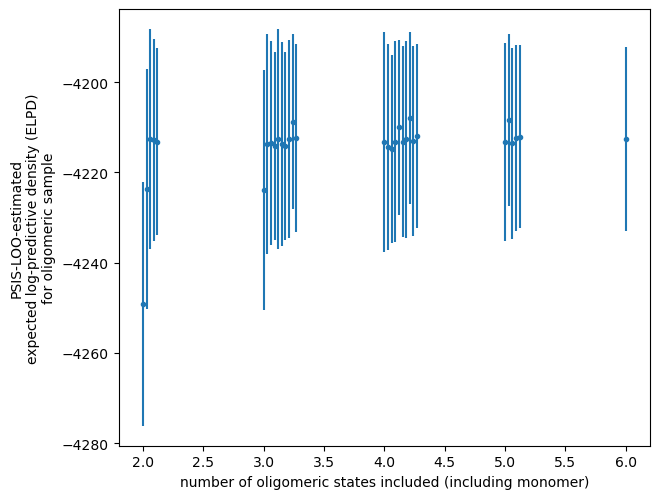

In [54]:
inits = []
for i, name in enumerate(combined_approx_ra_monomeric_model_fit_ra.column_names[7:10]):
    inits.append(
        (
            name,
            np.mean(
                combined_approx_ra_monomeric_model_fit_ra.draws().reshape(
                    -1, combined_approx_ra_monomeric_model_fit_ra.draws().shape[-1]
                )[:, i]
            ),
        )
    )
inits = dict(inits)

working_combos = []
fits = []
loos = []
for num in range(2, data["highest_oligomer"] + 2):
    plot_offset = 0.0
    for combo in combinations(range(1, data["highest_oligomer"]), num - 1):
        oligomer_allowed = np.zeros(data["highest_oligomer"], dtype=int)
        oligomer_allowed[0] = 1
        for i in combo:
            oligomer_allowed[i] = 1
        data = {
            "num_spots": method1_intensities_ra.shape[0],
            "num_monomeric_spots": method1_intensities_monomeric.shape[0],
            "highest_oligomer": 6,
            "spot_intensities": method1_intensities_ra - overall_intensity_min_ra,
            "monomeric_spot_intensities": method1_intensities_monomeric - overall_intensity_min_ra,
            "oligomer_allowed": oligomer_allowed,
        }
        try:
            combined_approx_ra_monomeric_allowed_oligomers_model_fit_ra = (
                combined_approx_ra_monomeric_allowed_oligomers_model.sample(
                    data, inits=inits, threads_per_chain=num_threads_per_chain
                )
            )
        except:
            try:
                combined_approx_ra_monomeric_allowed_oligomers_model_fit_ra = (
                    combined_approx_ra_monomeric_allowed_oligomers_model.sample(
                        data, inits=inits, threads_per_chain=num_threads_per_chain
                    )
                )
            except:
                try:
                    combined_approx_ra_monomeric_allowed_oligomers_model_fit_ra = (
                        combined_approx_ra_monomeric_allowed_oligomers_model.sample(
                            data, inits=inits, threads_per_chain=num_threads_per_chain
                        )
                    )
                except:
                    continue
        loo = az.loo(
            az.from_cmdstanpy(
                combined_approx_ra_monomeric_allowed_oligomers_model_fit_ra,
                log_likelihood="log_lik",
            )
        )
        fits.append(combined_approx_ra_monomeric_allowed_oligomers_model_fit_ra)
        working_combos.append(np.array([1] + [x + 1 for x in combo]))
        loos.append(loo)
        print(working_combos[-1])
        print(loo)
        plt.errorbar(num + plot_offset, loo["loo"], yerr=loo["loo_se"], marker=".", color="C0")
        plot_offset += 0.03

plt.xlabel("number of oligomeric states included (including monomer)")
plt.ylabel("PSIS-LOO-estimated\nexpected log-predictive density (ELPD)\nfor oligomeric sample")
plt.tight_layout(pad=0.0)

/home/kent/miniconda3/envs/stan/lib/python3.8/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


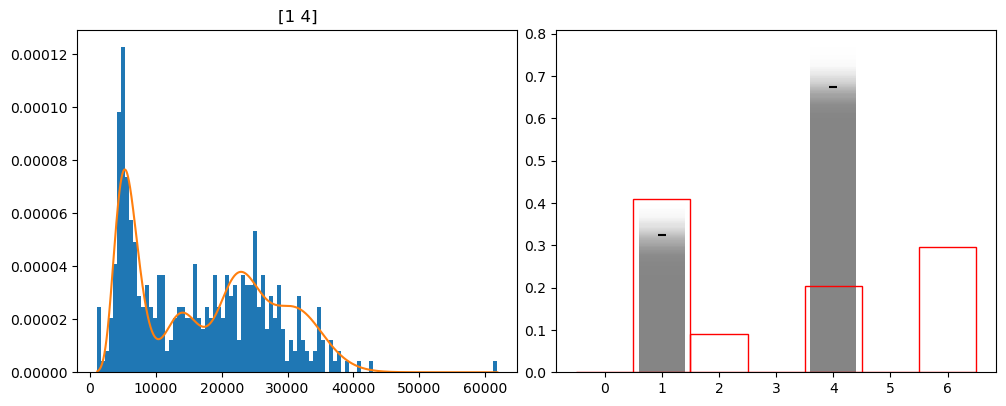

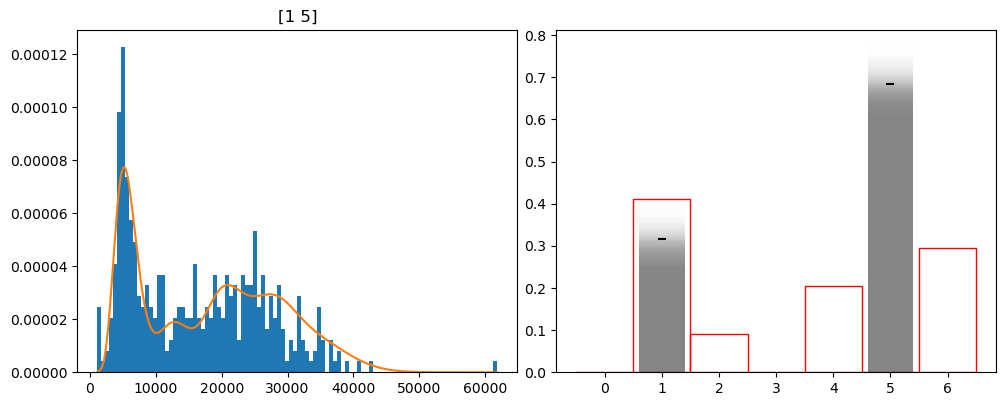

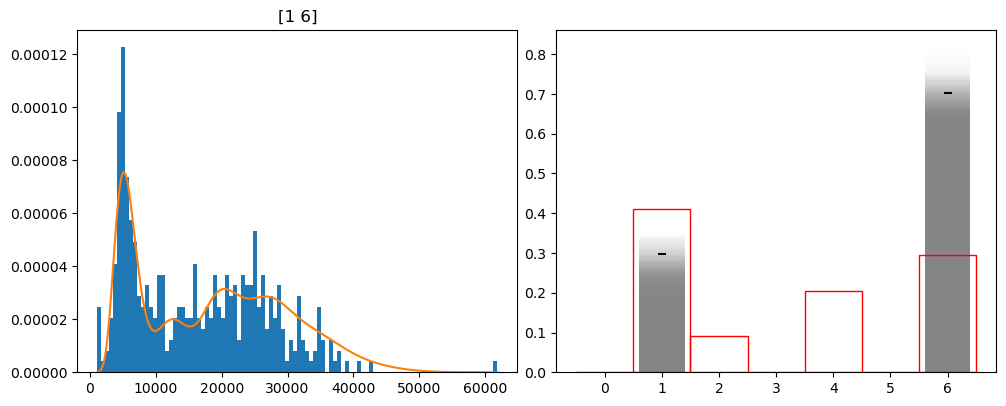

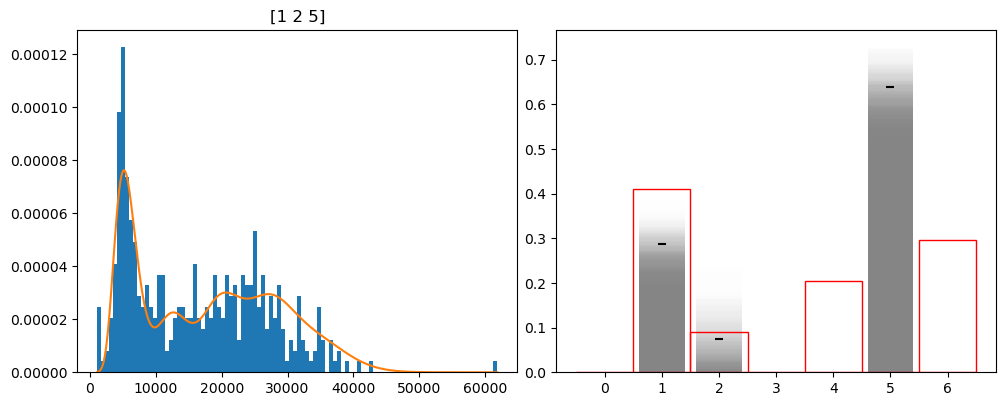

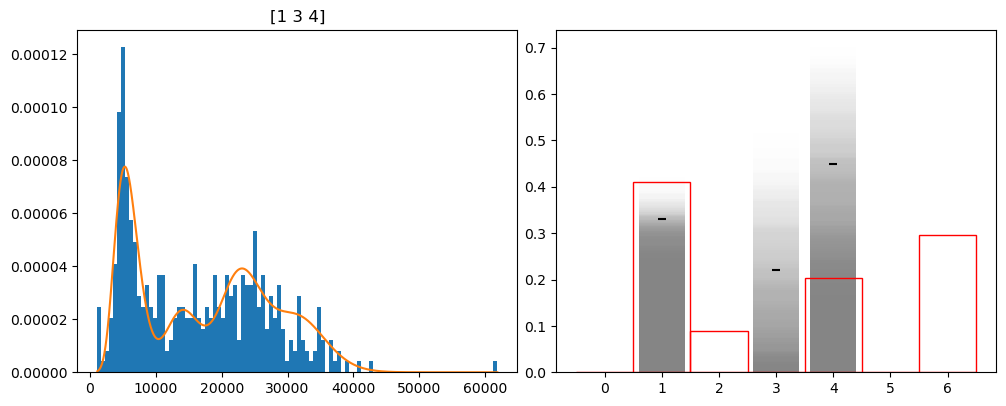

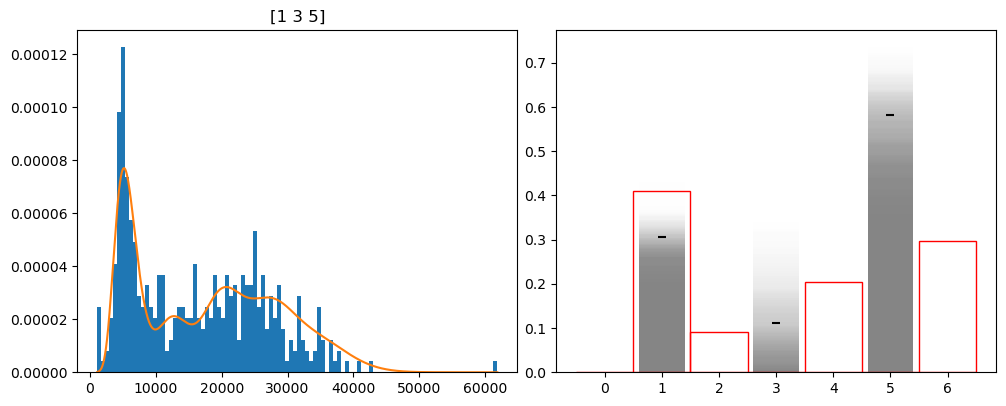

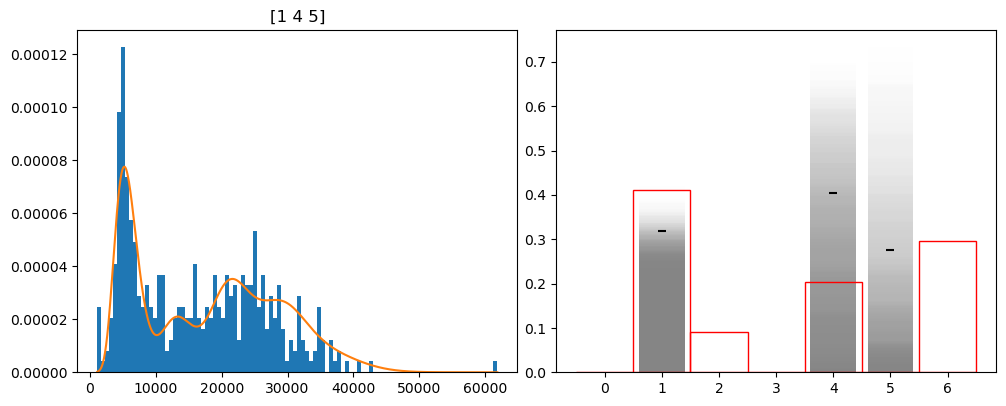

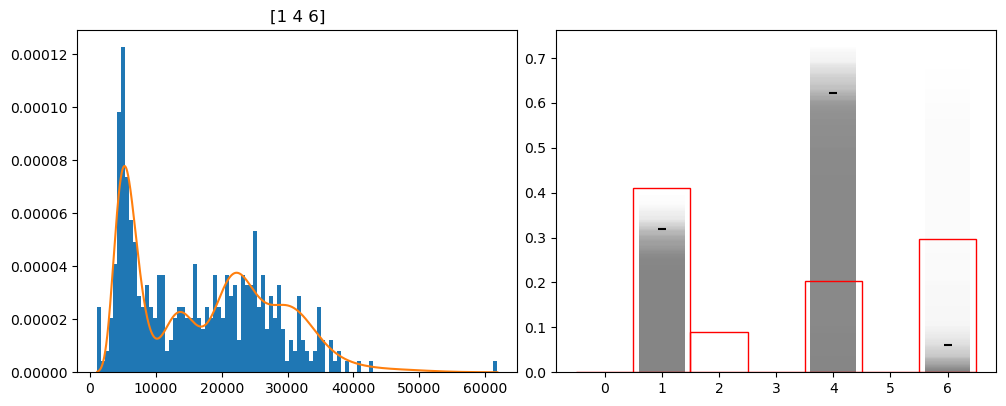

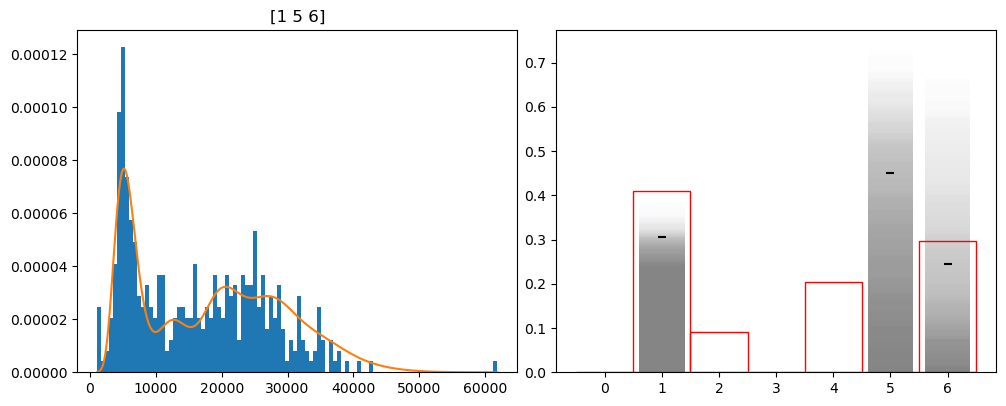

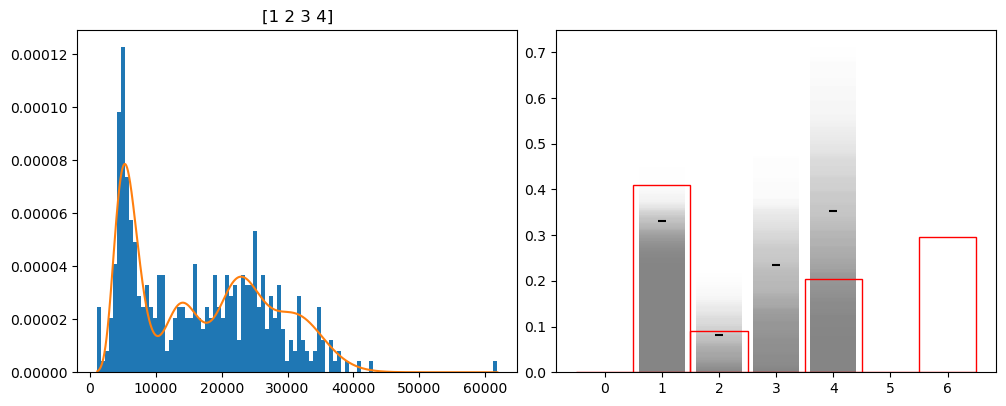

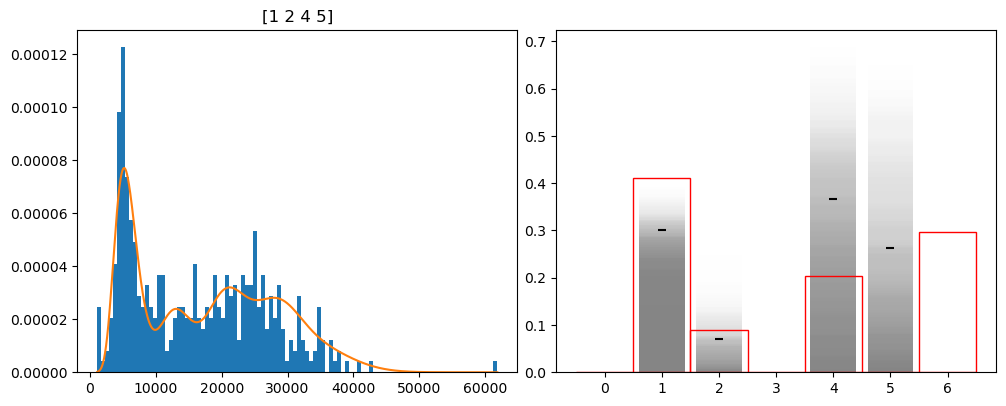

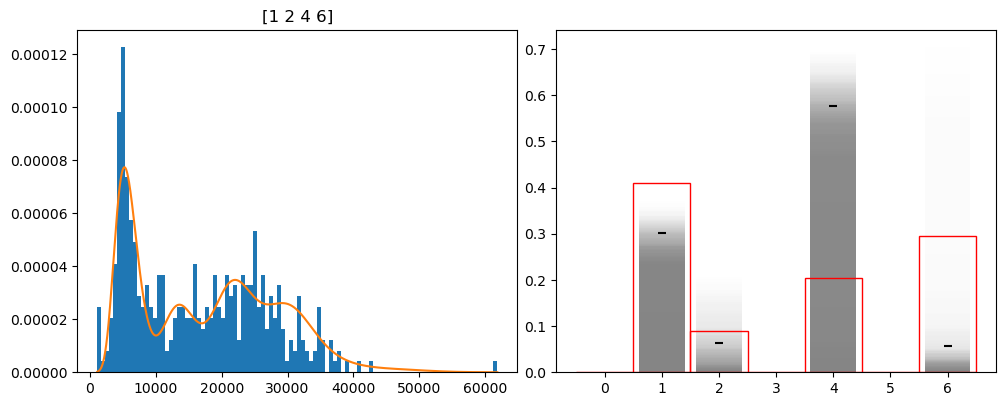

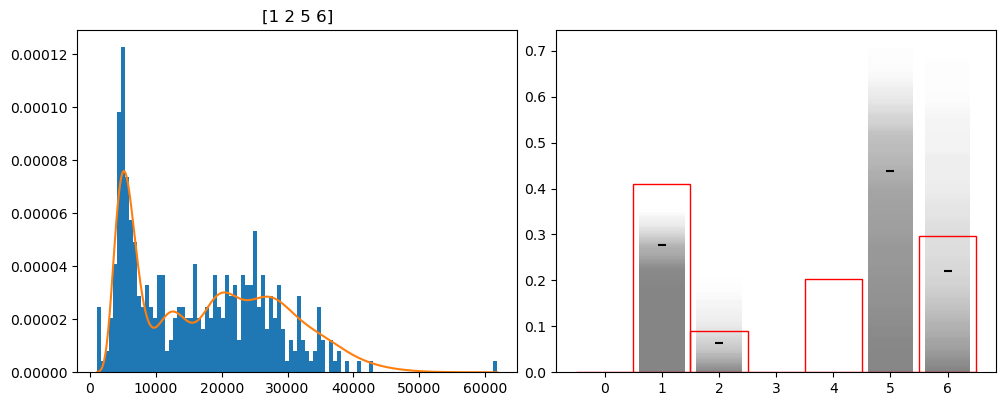

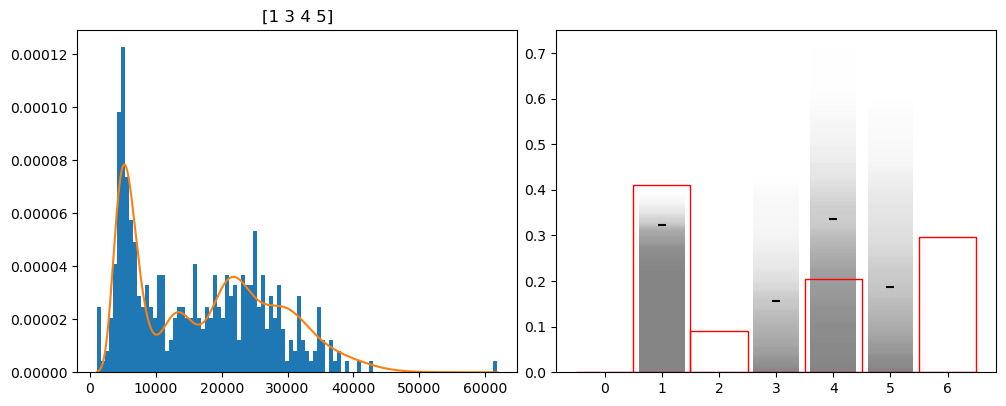

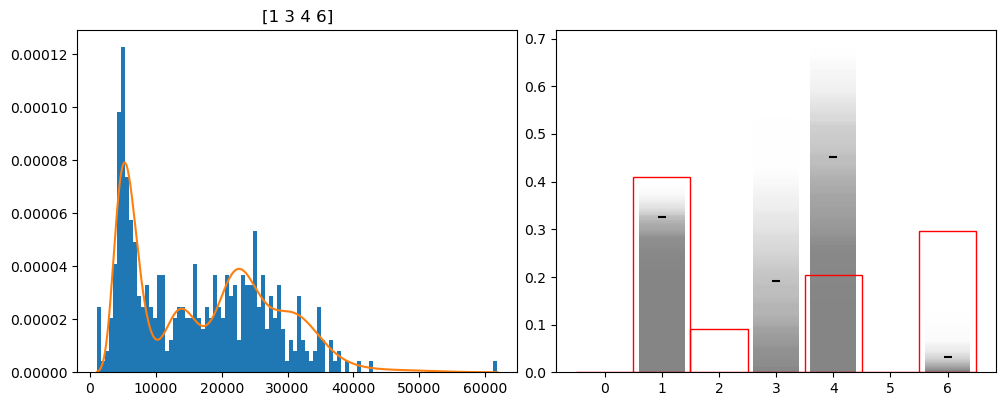

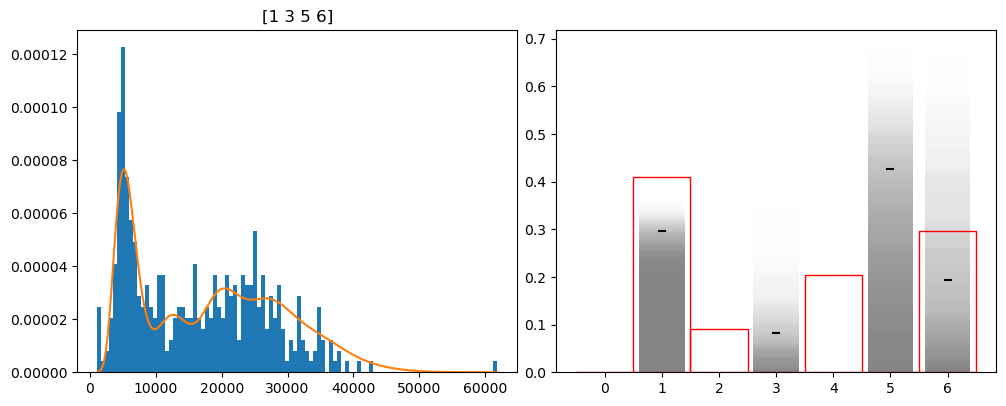

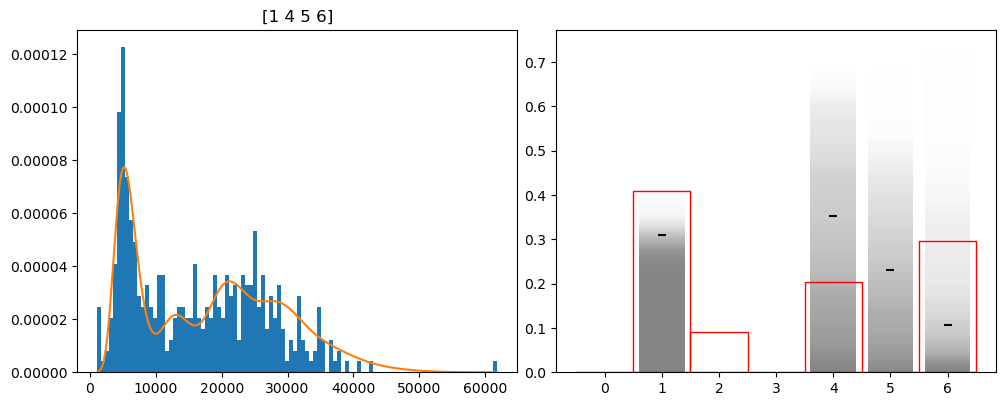

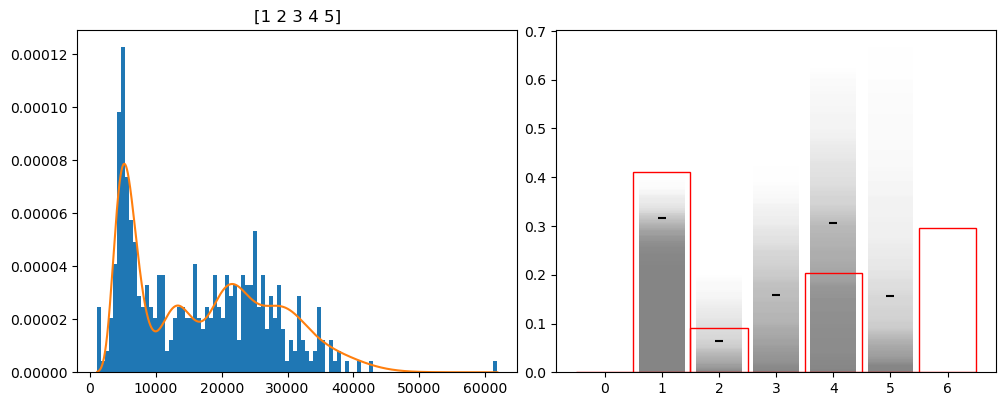

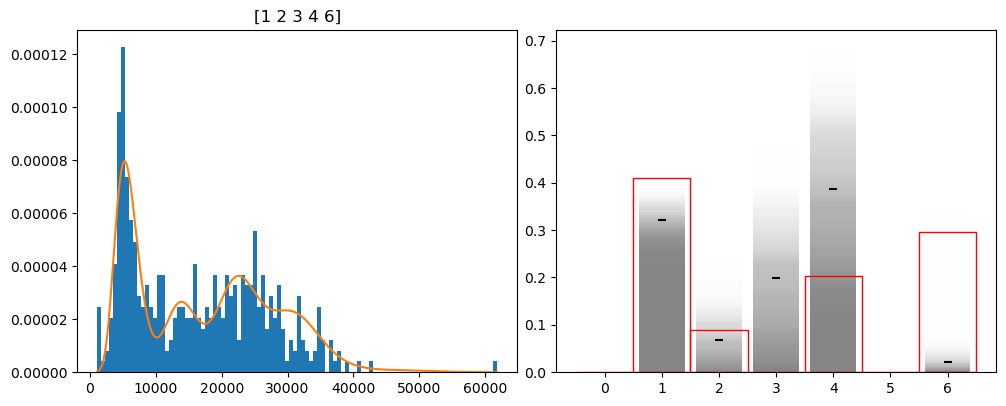

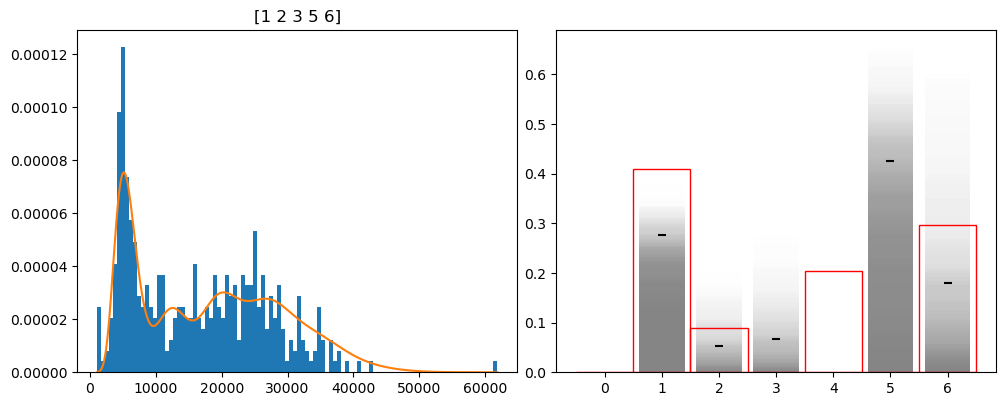

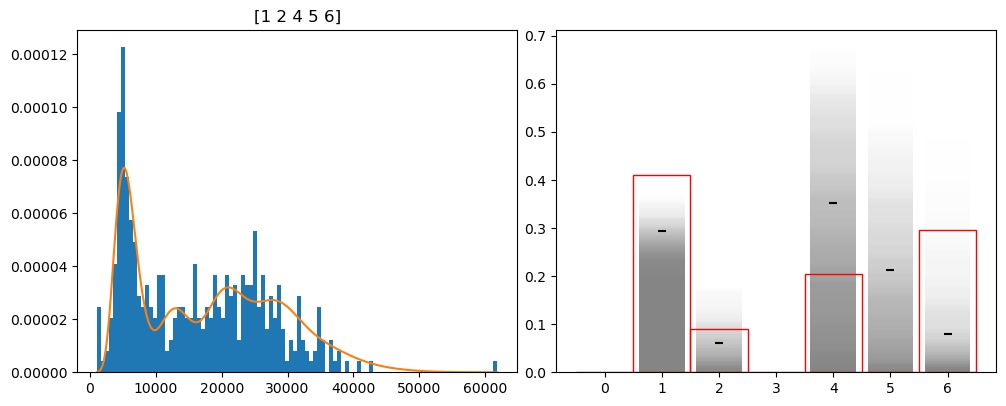

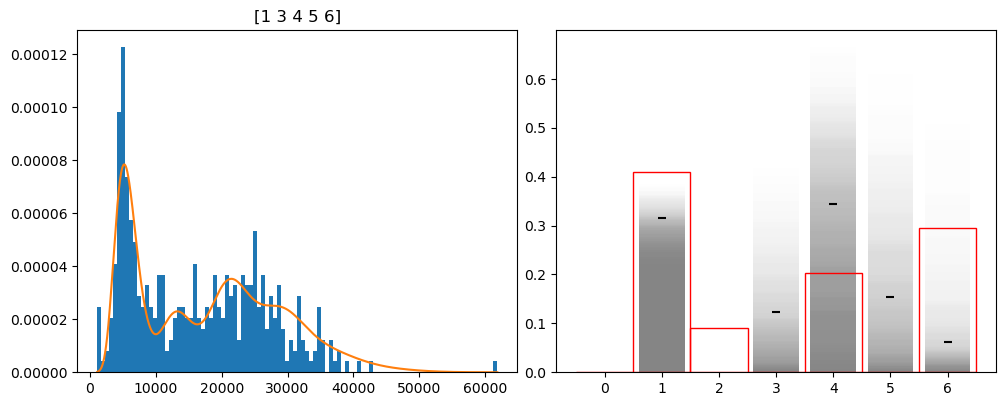

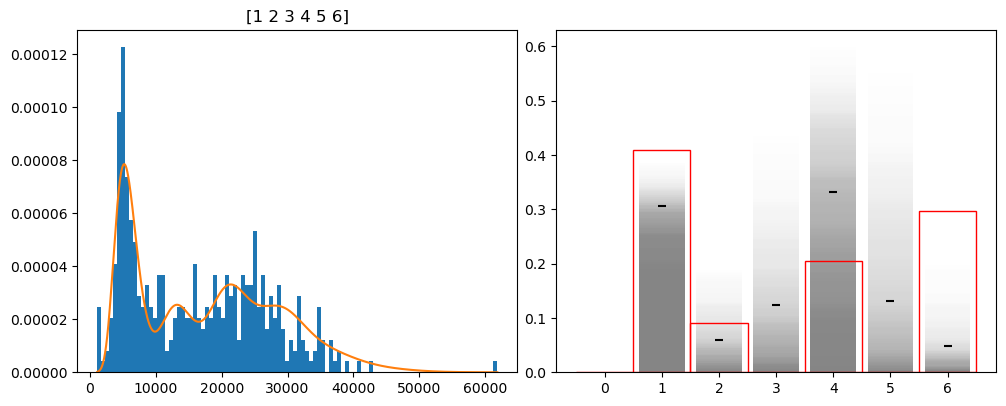

In [55]:
for c, loo in enumerate(loos):
    if loo["loo"] > np.quantile([result["loo"] for result in loos], .25):
        f, axes = plt.subplots(1, 2, figsize=(10, 4))
        axes[0].hist(method1_intensities_ra, bins=data["num_spots"] // 4, density=True)
        xvals = np.linspace(overall_intensity_min_ra, np.max(method1_intensities_ra), 10000)
        axes[0].plot(
            xvals,
            approx_ra_mean_pdf(xvals, fits[c], overall_intensity_min_ra, working_combos[c]),
        )
        axes[0].set_title(working_combos[c])
        for draw in fits[c].draws().reshape(-1, fits[c].draws().shape[-1])[::33, :]:
            heights = [
                draw[fits[c].column_names.index("p_oligomer[" + str(i + 1) + "]")]
                for i in range(working_combos[c].shape[0])
            ]
            axes[1].bar(working_combos[c], heights, color="black", alpha=0.004)
        axes[1].scatter(
            working_combos[c],
            np.mean(
                fits[c]
                .draws()
                .reshape(-1, fits[c].draws().shape[-1])[
                    :,
                    fits[c]
                    .column_names.index("p_oligomer[1]") : fits[c]
                    .column_names.index("p_oligomer[" + str(working_combos[c].shape[0]) + "]")
                    + 1,
                ],
                axis=0,
            ),
            color="black",
            marker="_",
        )
        axes[1].hist(
            num_fluorophores,
            bins=np.arange(np.max(oligomeric_states) + 2) - 0.5,
            color=(0, 0, 0, 0),
            edgecolor="red",
            density=True,
        )
        f.tight_layout(pad=0.5)
        plt.show()
        f.clf()

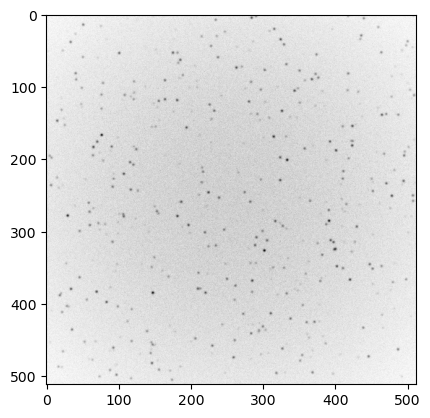

In [56]:
# example of simulating a vignetted image
vignetting_sigma = 300.0
image_vignetted_md = (
    image_md
    * 2.0
    * np.pi
    * vignetting_sigma**2
    * (
        norm.cdf(yvals_upper, image_dims[0] / 2.0, vignetting_sigma)
        - norm.cdf(yvals_lower, image_dims[0] / 2.0, vignetting_sigma)
    )[:, np.newaxis]
    * (
        norm.cdf(xvals_upper, image_dims[1] / 2.0, vignetting_sigma)
        - norm.cdf(xvals_lower, image_dims[1] / 2.0, vignetting_sigma)
    )[np.newaxis, :]
)

plt.imshow(image_vignetted_md, cmap="binary")

Text(0, 0.5, 'estimated intensity of closest spot')

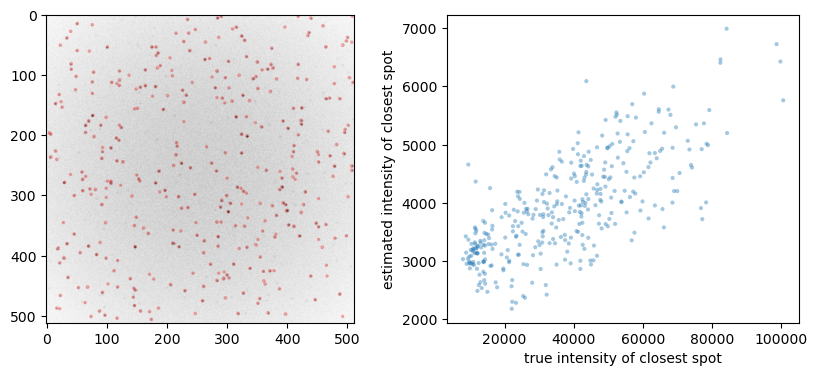

In [57]:
blobs_vignetted_md = blob_log(
    image_vignetted_md,
    threshold=threshold_to_use,
    min_sigma=sigma_guess / sigma_range,
    max_sigma=sigma_guess * sigma_range,
    num_sigma=40,
)

f, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(image_vignetted_md, cmap="binary")

blob_intensities_vignetted_md = []
closest_intensities_vignetted_md = []
for blob in blobs_vignetted_md:
    y, x, r = blob
    blob_intensities_vignetted_md.append(gaussian_filter(image_vignetted_md, r)[int(y), int(x)])
    closest_intensities_vignetted_md.append(
        intensities_md[
            np.argmin(np.square(y - spot_centers_md[:, 0]) + np.square(x - spot_centers_md[:, 1]))
        ]
    )
    c = plt.Circle((x, y), r * np.sqrt(2), color="red", linewidth=1, fill=False, alpha=0.3)
    axes[0].add_patch(c)

axes[1].scatter(
    closest_intensities_vignetted_md,
    blob_intensities_vignetted_md,
    alpha=0.4,
    edgecolor="none",
    marker=".",
)
axes[1].set_xlabel("true intensity of closest spot")
axes[1].set_ylabel("estimated intensity of closest spot")

In [58]:
modelcode = """
data {
    int<lower=1> num_background_pixels;
    vector<lower=0>[num_background_pixels] background_pixels;
    vector<lower=0>[num_background_pixels] pixel_locations[2];
    int<lower=1> max_image_dim;
}
parameters {
    real<lower=0> background_mu;
    real<lower=0> background_sigma;
    real<lower=max_image_dim / 2> background_decay;
    real<lower=0, upper=max_image_dim> background_center[2];
}
model {
    vector[num_background_pixels] distances = 
        sqrt((pixel_locations[1] - background_center[1]) ^ 2 +
             (pixel_locations[2] - background_center[2]) ^ 2);
    background_pixels ~ lognormal(background_mu - (distances / background_decay) ^ 2,
                                  background_sigma);
    background_center ~ normal(max_image_dim / 2, max_image_dim / 10);
}
"""

filename = "fit_vignetted_background.stan"

with open(filename, "w") as f:
    f.write(modelcode)

vignetted_background_model = CmdStanModel(stan_file=filename)
vignetted_background_model.compile()

21:52:39 - cmdstanpy - INFO - compiling stan file /home/kent/fit_vignetted_background.stan to exe file /home/kent/fit_vignetted_background
21:52:49 - cmdstanpy - INFO - compiled model executable: /home/kent/fit_vignetted_background
21:52:49 - cmdstanpy - WARNING - Stan compiler has produced 5 warnings:
21:52:49 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc  --o=/home/kent/fit_vignetted_background.hpp /home/kent/fit_vignetted_background.stan
Warning in '/home/kent/fit_vignetted_background.stan', line 5, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/home/kent/fit_vignetted_background.stan', line 12, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead

In [59]:
@jit(nopython=True)
def pick_background_pixels_locations(image, blobs):
    background_pixels = []
    background_pixel_locations = []
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            for blob in blobs:
                y, x, blob_sigma = blob
                if np.sqrt(np.square(y - i) + np.square(x - j)) < 4.0 * blob_sigma:
                    background_pixels.append(image[i, j])
                    background_pixel_locations.append((i, j))
    return background_pixels, background_pixel_locations

In [60]:
def pick_background_pixels_locations_after_subtracting(image, blobs, intensities, background_level):
    spot_images_estimated = np.zeros((num_spots, *image.shape))
    for i, blob in enumerate(blobs):
        y, x, blob_sigma = blob
        spot_images_estimated[i] = (
            (intensities[i] - background_level)
            * 2.0
            * np.pi
            * np.square(blob_sigma)
            * (norm.cdf(yvals_upper, y, blob_sigma) - norm.cdf(yvals_lower, y, blob_sigma))[
                :, np.newaxis
            ]
            * (norm.cdf(xvals_upper, x, blob_sigma) - norm.cdf(xvals_lower, x, blob_sigma))[
                np.newaxis, :
            ]
        )
    image_estimated = image - np.sum(spot_images_estimated, axis=0)
    background_pixels, background_pixel_locations = pick_background_pixels_locations(
        image_estimated, blobs
    )
    return background_pixels, image_estimated, background_pixel_locations

21:52:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


22:07:22 - cmdstanpy - INFO - CmdStan done processing.
22:07:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: lognormal_lpdf: Location parameter[1] is inf, but must be finite! (in '/home/kent/fit_vignetted_background.stan', line 18, column 4 to line 19, column 52)
	Exception: lognormal_lpdf: Location parameter[1] is inf, but must be finite! (in '/home/kent/fit_vignetted_background.stan', line 18, column 4 to line 19, column 52)
	Exception: lognormal_lpdf: Location parameter[1] is inf, but must be finite! (in '/home/kent/fit_vignetted_background.stan', line 18, column 4 to line 19, column 52)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in '/home/kent/fit_vignetted_background.stan', line 18, column 4 to line 19, column 52)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in '/home/kent/fit_vignetted_background.stan', line 18, column 4 to line 19, column 52)
	Exception: lognormal_lpdf: Scale param

22:07:22 - cmdstanpy - INFO - Chain [1] done processing


Mean      MCSE    StdDev          5%         50%  \
lp__                  694.76100  0.042228  1.619570  691.658000  695.100000   
background_mu           8.10740  0.000046  0.002589    8.103090    8.107430   
background_sigma        0.23623  0.000017  0.001013    0.234565    0.236236   
background_decay      444.00200  0.043608  2.359990  440.169000  444.074000   
background_center[1]  253.65700  0.022355  1.027000  251.925000  253.653000   
background_center[2]  255.33400  0.020858  0.967559  253.774000  255.311000   

                             95%    N_Eff  N_Eff/s     R_hat  
lp__                  696.751000  1470.93  1.52396  1.002440  
background_mu           8.111630  3104.57  3.21648  1.000440  
background_sigma        0.237871  3648.96  3.78050  0.999558  
background_decay      447.922000  2928.80  3.03438  1.000060  
background_center[1]  255.336000  2110.46  2.18654  1.001480  
background_center[2]  256.923000  2151.94  2.22951  1.001060

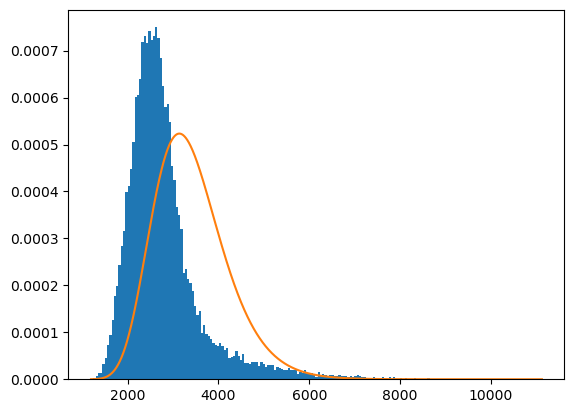

In [61]:
(
    background_pixels_vignetted_md,
    background_pixel_locations_vignetted_md,
) = pick_background_pixels_locations(image_vignetted_md, blobs_vignetted_md)

data = {
    "num_background_pixels": len(background_pixels_vignetted_md),
    "background_pixels": background_pixels_vignetted_md,
    "pixel_locations": np.array(background_pixel_locations_vignetted_md).T,
    "max_image_dim": max(image_dims),
}

vignetted_background_fit_md = vignetted_background_model.sample(
    data, inits={"background_center": (image_dims[0] / 2, image_dims[1] / 2)}
)
vignetted_background_mle_md = vignetted_background_model.optimize(data)

plt.hist(background_pixels_vignetted_md, bins="auto", density=True)
xvals = np.linspace(
    np.min(background_pixels_vignetted_md),
    np.max(background_pixels_vignetted_md),
    10000,
)
plt.plot(
    xvals,
    lognorm.pdf(
        xvals,
        s=vignetted_background_mle_md.optimized_params_dict["background_sigma"],
        scale=np.exp(vignetted_background_mle_md.optimized_params_dict["background_mu"]),
    ),
)
vignetted_background_fit_md.summary()

22:07:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


22:25:26 - cmdstanpy - INFO - CmdStan done processing.
22:25:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: lognormal_lpdf: Location parameter[1] is inf, but must be finite! (in '/home/kent/fit_vignetted_background.stan', line 18, column 4 to line 19, column 52)
	Exception: lognormal_lpdf: Location parameter[1] is inf, but must be finite! (in '/home/kent/fit_vignetted_background.stan', line 18, column 4 to line 19, column 52)
	Exception: lognormal_lpdf: Location parameter[1] is inf, but must be finite! (in '/home/kent/fit_vignetted_background.stan', line 18, column 4 to line 19, column 52)
	Exception: lognormal_lpdf: Location parameter[1] is inf, but must be finite! (in '/home/kent/fit_vignetted_background.stan', line 18, column 4 to line 19, column 52)
	Exception: lognormal_lpdf: Location parameter[1] is inf, but must be finite! (in '/home/kent/fit_vignetted_background.stan', line 18, column 4 to line 19, column 52)
	Exception: lognormal_lpdf: Location paramete

22:25:26 - cmdstanpy - INFO - Chain [1] done processing


Mean      MCSE    StdDev           5%  \
lp__                  6546.230000  0.037630  1.533660  6543.240000   
background_mu            8.054800  0.000038  0.002077     8.051380   
background_sigma         0.198755  0.000014  0.000770     0.197534   
background_decay       465.489000  0.043359  2.161030   461.882000   
background_center[1]   253.631000  0.016692  0.815887   252.295000   
background_center[2]   255.060000  0.015603  0.800212   253.716000   

                              50%          95%    N_Eff  N_Eff/s     R_hat  
lp__                  6546.510000  6548.160000  1661.10  1.23449  1.000710  
background_mu            8.054790     8.058270  2913.49  2.16524  0.999240  
background_sigma         0.198739     0.200049  2846.66  2.11558  0.999957  
background_decay       465.497000   468.985000  2484.10  1.84613  0.999478  
background_center[1]   253.617000   255.016000  2389.30  1.77567  1.001940  
background_center[2]   255.064000   256.359000  2630.32  1.95479  0.999665

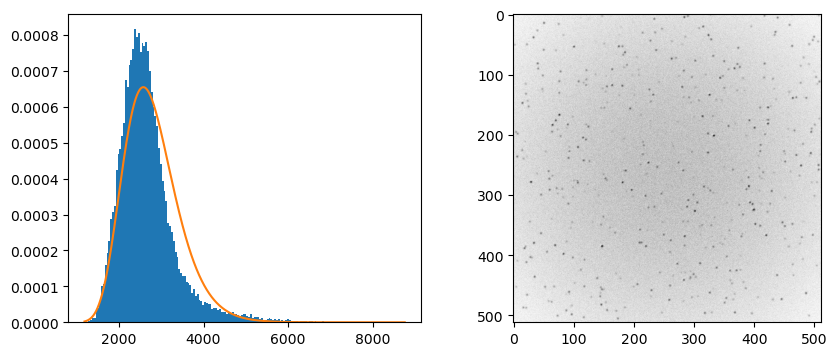

In [62]:
# redo blob detection on vignetting-corrected image, then evaluate intensities on original vignetted image again
image_vignetted_md_corrected = image_vignetted_md / (
    2.0
    * np.pi
    * (vignetted_background_mle_md.optimized_params_dict["background_decay"] / np.sqrt(2)) ** 2
    * (
        norm.cdf(
            yvals_upper,
            vignetted_background_mle_md.optimized_params_dict["background_center[1]"],
            vignetted_background_mle_md.optimized_params_dict["background_decay"] / np.sqrt(2),
        )
        - norm.cdf(
            yvals_lower,
            vignetted_background_mle_md.optimized_params_dict["background_center[1]"],
            vignetted_background_mle_md.optimized_params_dict["background_decay"] / np.sqrt(2),
        )
    )[:, np.newaxis]
    * (
        norm.cdf(
            xvals_upper,
            vignetted_background_mle_md.optimized_params_dict["background_center[2]"],
            vignetted_background_mle_md.optimized_params_dict["background_decay"] / np.sqrt(2),
        )
        - norm.cdf(
            xvals_lower,
            vignetted_background_mle_md.optimized_params_dict["background_center[2]"],
            vignetted_background_mle_md.optimized_params_dict["background_decay"] / np.sqrt(2),
        )
    )[np.newaxis, :]
)

blobs_vignetted_md_corrected = blob_log(
    image_vignetted_md_corrected,
    threshold=threshold_to_use,
    min_sigma=sigma_guess / sigma_range,
    max_sigma=sigma_guess * sigma_range,
    num_sigma=40,
)
blob_intensities_vignetted_md_corrected = []
for blob in blobs_vignetted_md_corrected:
    y, x, r = blob
    blob_intensities_vignetted_md_corrected.append(
        gaussian_filter(image_vignetted_md, r)[int(y), int(x)]
    )

(
    background_pixels_vignetted_md,
    image_estimated_vignetted_md,
    background_pixel_locations_vignetted_md,
) = pick_background_pixels_locations_after_subtracting(
    image_vignetted_md,
    blobs_vignetted_md_corrected,
    blob_intensities_vignetted_md_corrected,
    np.exp(
        vignetted_background_mle_md.optimized_params_dict["background_mu"]
        - vignetted_background_mle_md.optimized_params_dict["background_sigma"] ** 2
    ),
)

data = {
    "num_background_pixels": len(background_pixels_vignetted_md),
    "background_pixels": background_pixels_vignetted_md,
    "pixel_locations": np.array(background_pixel_locations_vignetted_md).T,
    "max_image_dim": max(image_dims),
}

vignetted_background_fit_md = vignetted_background_model.sample(
    data, inits={"background_center": (image_dims[0] / 2, image_dims[1] / 2)}
)
vignetted_background_mle_md = vignetted_background_model.optimize(data)

f, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(background_pixels_vignetted_md, bins="auto", density=True)
xvals = np.linspace(
    np.min(background_pixels_vignetted_md),
    np.max(background_pixels_vignetted_md),
    10000,
)
axes[0].plot(
    xvals,
    lognorm.pdf(
        xvals,
        s=vignetted_background_mle_md.optimized_params_dict["background_sigma"],
        scale=np.exp(vignetted_background_mle_md.optimized_params_dict["background_mu"]),
    ),
)
axes[1].imshow(image_estimated_vignetted_md, cmap="binary")
vignetted_background_fit_md.summary()

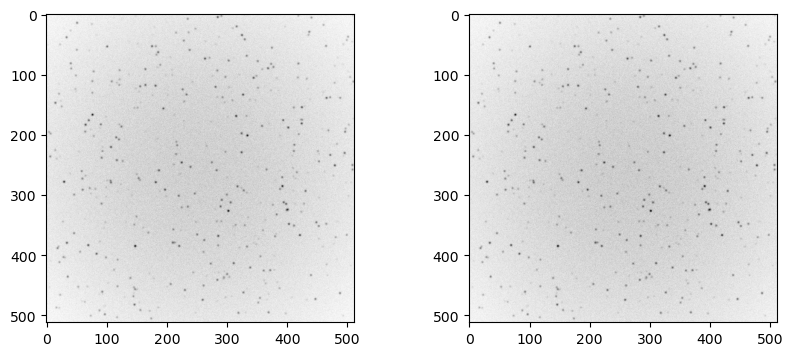

In [63]:
image_vignetted_md_corrected = image_vignetted_md / (
    2.0
    * np.pi
    * (vignetted_background_mle_md.optimized_params_dict["background_decay"] / np.sqrt(2)) ** 2
    * (
        norm.cdf(
            yvals_upper,
            vignetted_background_mle_md.optimized_params_dict["background_center[1]"],
            vignetted_background_mle_md.optimized_params_dict["background_decay"] / np.sqrt(2),
        )
        - norm.cdf(
            yvals_lower,
            vignetted_background_mle_md.optimized_params_dict["background_center[1]"],
            vignetted_background_mle_md.optimized_params_dict["background_decay"] / np.sqrt(2),
        )
    )[:, np.newaxis]
    * (
        norm.cdf(
            xvals_upper,
            vignetted_background_mle_md.optimized_params_dict["background_center[2]"],
            vignetted_background_mle_md.optimized_params_dict["background_decay"] / np.sqrt(2),
        )
        - norm.cdf(
            xvals_lower,
            vignetted_background_mle_md.optimized_params_dict["background_center[2]"],
            vignetted_background_mle_md.optimized_params_dict["background_decay"] / np.sqrt(2),
        )
    )[np.newaxis, :]
)

blobs_vignetted_md_corrected = blob_log(
    image_vignetted_md_corrected,
    threshold=threshold_to_use,
    min_sigma=sigma_guess / sigma_range,
    max_sigma=sigma_guess * sigma_range,
    num_sigma=40,
)

blob_intensities_vignetted_md_corrected = []
closest_intensities_vignetted_md_corrected = []
for blob in blobs_vignetted_md_corrected:
    y, x, r = blob
    blob_intensities_vignetted_md_corrected.append(
        gaussian_filter(image_vignetted_md_corrected, r)[int(y), int(x)]
    )
    closest_intensities_vignetted_md_corrected.append(
        intensities_md[
            np.argmin(np.square(y - spot_centers_md[:, 0]) + np.square(x - spot_centers_md[:, 1]))
        ]
    )

f, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(image_vignetted_md, cmap="binary")
axes[1].imshow(
    image_vignetted_md_corrected,
    cmap="binary",
    vmin=np.min(image_vignetted_md),
    vmax=np.max(image_vignetted_md),
)

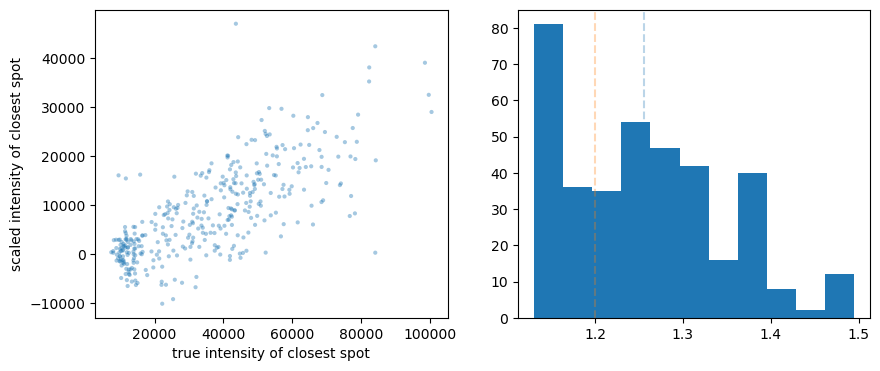

In [64]:
method1_intensities_vignetted_md_corrected = np.empty(blobs_vignetted_md_corrected.shape[0])
blob_sigmas = np.empty(blobs_vignetted_md_corrected.shape[0])
for i, blob in enumerate(blobs_vignetted_md_corrected):
    y, x, blob_sigma = blob
    blob_sigmas[i] = blob_sigma
    method1_intensities_vignetted_md_corrected[i] = (
        (
            blob_intensities_vignetted_md_corrected[i]
            - np.exp(background_mle_md.optimized_params_dict["background_mu"])
        )
        * 2.0
        * np.pi
        * np.square(blob_sigma)
    )

f, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].scatter(
    closest_intensities_vignetted_md_corrected,
    method1_intensities_vignetted_md_corrected,
    alpha=0.4,
    edgecolor="none",
    marker=".",
)
axes[0].set_xlabel("true intensity of closest spot")
axes[0].set_ylabel("scaled intensity of closest spot")
axes[1].hist(blob_sigmas, bins="auto")
axes[1].axvline(np.mean(blob_sigmas), ls="dashed", alpha=0.3)
axes[1].axvline(spot_sigma, ls="dashed", alpha=0.3, color="C1")

22:25:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


22:26:32 - cmdstanpy - INFO - CmdStan done processing.
22:26:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: Exception: lognormal_lpdf: Random variable is -0.306863, but must be nonnegative! (in '/home/kent/fit_combined_md.stan', line 17, column 16 to line 19, column 87) (in '/home/kent/fit_combined_md.stan', line 60, column 4 to line 62, column 44)
	Exception: Exception: lognormal_lpdf: Random variable is -0.791789, but must be nonnegative! (in '/home/kent/fit_combined_md.stan', line 17, column 16 to line 19, column 87) (in '/home/kent/fit_combined_md.stan', line 60, column 4 to line 62, column 44)
	Exception: Exception: lognormal_lpdf: Random variable is -1.55456, but must be nonnegative! (in '/home/kent/fit_combined_md.stan', line 17, column 16 to line 19, column 87) (in '/home/kent/fit_combined_md.stan', line 60, column 4 to line 62, column 44)
	Exception: Exception: lognormal_lpdf: Random variable is -1.85193, but must be nonnegative! (in '/home/kent/fit_com

Mean         MCSE       StdDev            5%  \
lp__             -3854.110000     0.188446     2.690720  -3858.910000   
background_level -7545.550000  2536.580000  4566.610000 -16096.800000   
monomer_mu           9.420780     0.577790     0.826835      8.447840   
sigma                0.293647     0.017348     0.056781      0.201434   
p_oligomer[1]        0.104411     0.072423     0.150818      0.001260   
p_oligomer[2]        0.115190     0.051051     0.127631      0.004540   
p_oligomer[3]        0.234412     0.048815     0.150638      0.019334   
p_oligomer[4]        0.173417     0.010505     0.143238      0.011196   
p_oligomer[5]        0.195889     0.030916     0.149196      0.012822   
p_oligomer[6]        0.176682     0.018274     0.144887      0.009524   
p_bright             0.481150     0.333190     0.472580      0.001030   

                          50%          95%      N_Eff   N_Eff/s     R_hat  
lp__             -3853.820000 -3850.230000  203.87600  3.176430   1.02152  
background_level -6106.280000 -2392.040000    3.24109  0.050497   1.58392  
monomer_mu           9.836160    10.422200    2.04785  0.031906   6.61817  
sigma                0.294419     0.386711   10.71250  0.166903   1.11299  
p_oligomer[1]        0.018483     0.438923    4.33671  0.067567   1.33892  
p_oligomer[2]        0.064686     0.389191    6.25042  0.097383   1.20335  
p_oligomer[3]        0.228695     0.465660    9.52257  0.148364   1.12389  
p_oligomer[4]        0.138106     0.460522  185.92200  2.896700   1.01707  
p_oligomer[5]        0.169508     0.468194   23.28860  0.362841   1.05161  
p_oligomer[6]        0.142691     0.448491   62.86340  0.979424   1.02763  
p_bright             0.729410     0.992910    2.01175  0.031340  17.63827

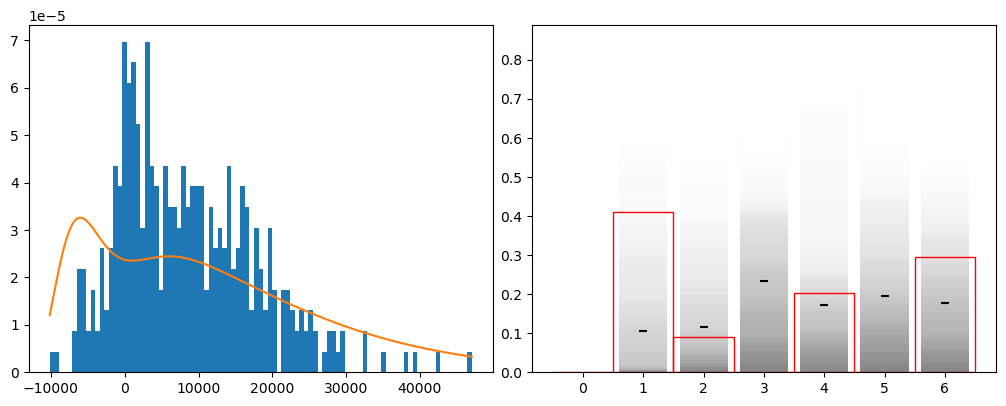

In [65]:
data = {
    "num_spots": method1_intensities_vignetted_md_corrected.shape[0],
    "highest_oligomer": 6,
    "spot_intensities": method1_intensities_vignetted_md_corrected
    - np.min(method1_intensities_vignetted_md_corrected),
}
combined_md_model_fit_vignetted_md_corrected = combined_md_model.sample(data)

f, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(
    method1_intensities_vignetted_md_corrected,
    bins=data["num_spots"] // 4,
    density=True,
)
xvals = np.linspace(
    np.min(method1_intensities_vignetted_md_corrected),
    np.max(method1_intensities_vignetted_md_corrected),
    10000,
)
yvals = np.zeros(xvals.shape)
for i in range(data["highest_oligomer"]):
    for j in range(i + 1):
        yvals += (
            np.mean(
                combined_md_model_fit_vignetted_md_corrected.draws()[
                    :,
                    :,
                    combined_md_model_fit_vignetted_md_corrected.column_names.index(
                        "p_oligomer[" + str(i + 1) + "]"
                    ),
                ]
            )
            * binom.pmf(
                j,
                i,
                np.mean(
                    combined_md_model_fit_vignetted_md_corrected.draws()[
                        :,
                        :,
                        combined_md_model_fit_vignetted_md_corrected.column_names.index("p_bright"),
                    ]
                ),
            )
            * lognorm.pdf(
                xvals
                - np.min(method1_intensities_vignetted_md_corrected)
                - np.mean(
                    combined_md_model_fit_vignetted_md_corrected.draws()[
                        :,
                        :,
                        combined_md_model_fit_vignetted_md_corrected.column_names.index(
                            "background_level"
                        ),
                    ]
                ),
                s=np.mean(
                    combined_md_model_fit_vignetted_md_corrected.draws()[
                        :,
                        :,
                        combined_md_model_fit_vignetted_md_corrected.column_names.index("sigma"),
                    ]
                ),
                scale=(j + 1)
                * np.exp(
                    np.mean(
                        combined_md_model_fit_vignetted_md_corrected.draws()[
                            :,
                            :,
                            combined_md_model_fit_vignetted_md_corrected.column_names.index(
                                "monomer_mu"
                            ),
                        ]
                    )
                ),
            )
        )
axes[0].plot(xvals, yvals)

xvals = np.arange(data["highest_oligomer"]) + 1
for draw in combined_md_model_fit_vignetted_md_corrected.draws().reshape(
    -1, combined_md_model_fit_vignetted_md_corrected.draws().shape[-1]
)[::33, :]:
    heights = [
        draw[
            combined_md_model_fit_vignetted_md_corrected.column_names.index(
                "p_oligomer[" + str(i + 1) + "]"
            )
        ]
        for i in range(data["highest_oligomer"])
    ]
    axes[1].bar(xvals, heights, color="black", alpha=0.004)
axes[1].scatter(
    xvals,
    np.mean(
        combined_md_model_fit_vignetted_md_corrected.draws().reshape(
            -1, combined_md_model_fit_vignetted_md_corrected.draws().shape[-1]
        )[
            :,
            combined_md_model_fit_vignetted_md_corrected.column_names.index(
                "p_oligomer[1]"
            ) : combined_md_model_fit_vignetted_md_corrected.column_names.index(
                "p_oligomer[" + str(data["highest_oligomer"]) + "]"
            )
            + 1,
        ],
        axis=0,
    ),
    color="black",
    marker="_",
)
axes[1].hist(
    num_fluorophores,
    bins=np.arange(np.max(oligomeric_states) + 2) - 0.5,
    color=(0, 0, 0, 0),
    edgecolor="red",
    density=True,
)
f.tight_layout(pad=0.5)

combined_md_model_fit_vignetted_md_corrected.summary()

In [66]:
# sample log-scale (Normal) model

modelcode = """
data {
    int<lower=1> num_spots;
    int<lower=0> highest_oligomer;
    vector<lower=0>[num_spots] spot_intensities;
}

parameters {
    real background_level;
    real<lower=0> monomer_mu;
    real<lower=0> sigma;
    simplex[highest_oligomer] p_oligomer;
}

model {
    vector[highest_oligomer] log_p_oligomer = log(p_oligomer);
    for (i in 1:num_spots) {
        vector[highest_oligomer] lps = log_p_oligomer;
        for (j in 1:highest_oligomer)
            lps[j] += normal_lpdf(log(spot_intensities[i] - background_level) |
                                  monomer_mu * log(j), sigma - 0.5 * log(j));
        target += log_sum_exp(lps);
    }
}
"""

filename = "fit_log_scale.stan"

with open(filename, "w") as f:
    f.write(modelcode)

log_scale_model = CmdStanModel(stan_file=filename)
log_scale_model.compile()

22:26:33 - cmdstanpy - INFO - compiling stan file /home/kent/fit_log_scale.stan to exe file /home/kent/fit_log_scale
22:26:40 - cmdstanpy - INFO - compiled model executable: /home/kent/fit_log_scale


22:26:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


22:29:56 - cmdstanpy - INFO - CmdStan done processing.
22:29:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is -0.0417416, but must be positive! (in '/home/kent/fit_log_scale.stan', line 20, column 12 to line 21, column 77)
	Exception: normal_lpdf: Scale parameter is -0.137171, but must be positive! (in '/home/kent/fit_log_scale.stan', line 20, column 12 to line 21, column 77)
	Exception: normal_lpdf: Random variable is -nan, but must be not nan! (in '/home/kent/fit_log_scale.stan', line 20, column 12 to line 21, column 77)
	Exception: normal_lpdf: Scale parameter is -0.0118699, but must be positive! (in '/home/kent/fit_log_scale.stan', line 20, column 12 to line 21, column 77)
	Exception: normal_lpdf: Random variable is -nan, but must be not nan! (in '/home/kent/fit_log_scale.stan', line 20, column 12 to line 21, column 77)
	Exception: normal_lpdf: Random variable is -nan, but must be not nan! (in '/home/kent/fit_log_scale.stan', li

22:29:56 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 999 divergent transitions (99.9%)
	Chain 2 had 707 divergent transitions (70.7%)
	Chain 2 had 129 iterations at max treedepth (12.9%)
	Chain 3 had 999 divergent transitions (99.9%)
	Chain 4 had 995 divergent transitions (99.5%)
	Use function "diagnose()" to see further information.


Mean          MCSE        StdDev            5%  \
lp__              7.826000e+02  7.410090e+02  1.049680e+03 -1.729790e+02   
background_level -5.848420e+06  6.868240e+06  9.758260e+06 -2.340860e+07   
monomer_mu        1.101100e+01  2.884050e+00  4.094590e+00  7.631550e+00   
sigma             8.965870e-01  2.681580e-04  7.973890e-04  8.959240e-01   
p_oligomer[1]     2.406940e-03  1.957220e-03  2.825200e-03  1.176460e-04   
p_oligomer[2]     2.490140e-01  3.022150e-01  4.280420e-01  6.228390e-04   
p_oligomer[3]     3.466610e-03  2.612590e-03  3.774400e-03  3.303020e-05   
p_oligomer[4]     2.524390e-01  2.979620e-01  4.220170e-01  5.904520e-04   
p_oligomer[5]     2.452490e-01  2.943310e-01  4.168730e-01  6.544750e-04   
p_oligomer[6]     2.474240e-01  3.007000e-01  4.258940e-01  3.123050e-04   

                            50%            95%    N_Eff   N_Eff/s      R_hat  
lp__                 485.473000    2563.480000  2.00663  0.039253   60.23010  
background_level -265245.000000 -138599.000000  2.01862  0.039488   12.78840  
monomer_mu             9.145600      18.477500  2.01565  0.039430   19.80310  
sigma                  0.896366       0.898143  8.84218  0.172969    1.16706  
p_oligomer[1]          0.001265       0.007536  2.08362  0.040759    6.08790  
p_oligomer[2]          0.003092       0.993120  2.00604  0.039242  312.54400  
p_oligomer[3]          0.001619       0.009991  2.08716  0.040829    5.13092  
p_oligomer[4]          0.017733       0.983532  2.00603  0.039242  424.60100  
p_oligomer[5]          0.006487       0.967752  2.00602  0.039241  607.69800  
p_oligomer[6]          0.001575       0.985713  2.00603  0.039242  445.88900

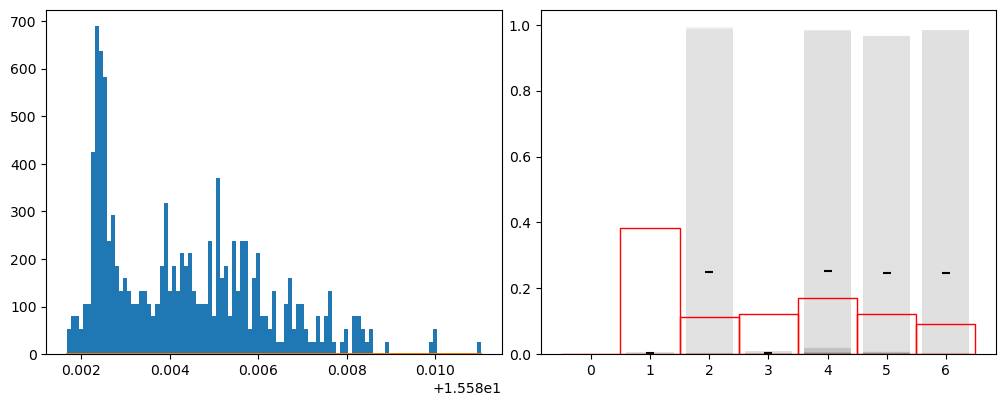

In [67]:
# sample log-scale (Normal) model

data = {
    "num_spots": method1_intensities_md.shape[0],
    "highest_oligomer": 6,
    "spot_intensities": method1_intensities_md - np.min(method1_intensities_md) + 1.0,
}
log_scale_model_fit_md = log_scale_model.sample(data)

f, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(
    np.log(
        method1_intensities_md
        - np.min(method1_intensities_md)
        + 1.0
        - np.mean(
            log_scale_model_fit_md.draws()[
                :, :, log_scale_model_fit_md.column_names.index("background_level")
            ]
        )
    ),
    bins=data["num_spots"] // 4,
    density=True,
)
xvals = np.linspace(
    np.min(
        np.log(
            method1_intensities_md
            - np.min(method1_intensities_md)
            + 1.0
            - np.mean(
                log_scale_model_fit_md.draws()[
                    :, :, log_scale_model_fit_md.column_names.index("background_level")
                ]
            )
        )
    ),
    np.max(
        np.log(
            method1_intensities_md
            - np.min(method1_intensities_md)
            + 1.0
            - np.mean(
                log_scale_model_fit_md.draws()[
                    :, :, log_scale_model_fit_md.column_names.index("background_level")
                ]
            )
        )
    ),
    10000,
)
yvals = np.zeros(xvals.shape)
for i in range(data["highest_oligomer"]):
    yvals += np.mean(
        log_scale_model_fit_md.draws()[
            :,
            :,
            log_scale_model_fit_md.column_names.index("p_oligomer[" + str(i + 1) + "]"),
        ]
    ) * norm.pdf(
        xvals,
        np.mean(
            log_scale_model_fit_md.draws()[
                :, :, log_scale_model_fit_md.column_names.index("monomer_mu")
            ]
        )
        * np.log(i + 1),
        -0.5 * np.log(i + 1)
        + np.mean(
            log_scale_model_fit_md.draws()[:, :, log_scale_model_fit_md.column_names.index("sigma")]
        ),
    )
axes[0].plot(xvals, yvals)

xvals = np.arange(data["highest_oligomer"]) + 1
for draw in log_scale_model_fit_md.draws().reshape(-1, log_scale_model_fit_md.draws().shape[-1])[
    ::33, :
]:
    heights = [
        draw[log_scale_model_fit_md.column_names.index("p_oligomer[" + str(i + 1) + "]")]
        for i in range(data["highest_oligomer"])
    ]
    axes[1].bar(xvals, heights, color="black", alpha=0.004)
axes[1].scatter(
    xvals,
    np.mean(
        log_scale_model_fit_md.draws().reshape(-1, log_scale_model_fit_md.draws().shape[-1])[
            :,
            log_scale_model_fit_md.column_names.index(
                "p_oligomer[1]"
            ) : log_scale_model_fit_md.column_names.index(
                "p_oligomer[" + str(data["highest_oligomer"]) + "]"
            )
            + 1,
        ],
        axis=0,
    ),
    color="black",
    marker="_",
)
axes[1].hist(
    num_bright_fluorophores[num_bright_fluorophores != 0],
    bins=np.arange(np.max(oligomeric_states) + 2) - 0.5,
    color=(0, 0, 0, 0),
    edgecolor="red",
    density=True,
)
f.tight_layout(pad=0.5)

log_scale_model_fit_md.summary()

In [68]:
modelcode = """
functions {
    real partial_sum_oligomers_lpdf(array[] real slice_spot_intensities,
                                    int start, int end,
                                    int highest_oligomer,
                                    vector lps_precomputed,
                                    real background_level,
                                    real monomer_mu, real sigma) {
        vector[((highest_oligomer * (highest_oligomer + 1))%/%2)] lps;
        vector[highest_oligomer] lognormal_precomputed;
        int ravel;
        real sum = 0.0;
        for (i in 1:(end - start)) {
            ravel = 1;
            // precompute lognormal_lupdf
            for (n in 1:highest_oligomer) {
                lognormal_precomputed[n] = lognormal_lupdf(slice_spot_intensities[i] -
                                                           background_level |
                                                           monomer_mu + log(n) + sigma ^ 2 *
                                                           (n - 1) / (2.0 * n), sigma / sqrt(n));
            }
            for (k in 1:highest_oligomer) { // num total
                for (j in 1:k) { // num bright
                    lps[ravel] = lognormal_precomputed[j] + lps_precomputed[ravel];
                    ravel += 1;
                }
            }
            sum += log_sum_exp(lps);
        }
        return sum;
    }
    real partial_sum_monomers_lpdf(array[] real slice_monomeric_spot_intensities,
                                   int start, int end,
                                   real background_level,
                                   real monomer_mu, real sigma) {
        array[end - start] real subtracted_intensities;
        for (i in 1:(end - start)) {
            subtracted_intensities[i] = slice_monomeric_spot_intensities[i] - background_level;
        }
        return lognormal_lupdf(subtracted_intensities | monomer_mu, sigma);
    }
}
data {
    int<lower=1> num_spots;
    int<lower=1> num_monomeric_spots;
    int<lower=1> highest_oligomer;
    array[num_spots] real<lower=0> spot_intensities;
    array[num_monomeric_spots] real<lower=0> monomeric_spot_intensities;
    real<lower=0> prior_alpha;
}

parameters {
    real background_level;
    real<lower=0> monomer_mu;
    real<lower=0> sigma;
    simplex[highest_oligomer] p_oligomer;
    real<lower=0,upper=1> p_bright;
}

model {
    vector[highest_oligomer] log_p_oligomer = log(p_oligomer);
    vector[((highest_oligomer * (highest_oligomer + 1))%/%2)] lps_precomputed;
    int ravel = 1;
    // precompute binomial terms
    for (k in 1:highest_oligomer) { // num total
        for (j in 1:k) { // num bright
            lps_precomputed[ravel] = log_p_oligomer[k];
            // subtracting the log complementary CDF accounts for
            // the 0 population being censored
            lps_precomputed[ravel] += binomial_lpmf(j | k, p_bright) -
                                      binomial_lccdf(0 | k, p_bright);
            ravel += 1;
        }
    }
    target += reduce_sum(partial_sum_oligomers_lupdf, spot_intensities, 128,
                         highest_oligomer, lps_precomputed, background_level,
                         monomer_mu, sigma);
    target += reduce_sum(partial_sum_monomers_lupdf, monomeric_spot_intensities, 128,
                         background_level, monomer_mu, sigma);
    p_oligomer ~ dirichlet(rep_vector(prior_alpha, highest_oligomer));
}
"""

filename = "fit_combined_approx_ra_monomeric_prior.stan"

with open(filename, "w") as f:
    f.write(modelcode)

if num_threads_per_chain > 1:
    combined_approx_ra_monomeric_prior_model = CmdStanModel(
        stan_file=filename, cpp_options={"STAN_THREADS": True}
    )
else:
    combined_approx_ra_monomeric_prior_model = CmdStanModel(stan_file=filename)
combined_approx_ra_monomeric_prior_model.compile()

22:29:58 - cmdstanpy - INFO - compiling stan file /home/kent/fit_combined_approx_ra_monomeric_prior.stan to exe file /home/kent/fit_combined_approx_ra_monomeric_prior
22:30:17 - cmdstanpy - INFO - compiled model executable: /home/kent/fit_combined_approx_ra_monomeric_prior


In [69]:
alphas = 10.0 ** np.linspace(-1.5, 0.0, 4)

inits = []
for i, name in enumerate(combined_approx_ra_monomeric_model_fit_ra.column_names[7:]):
    inits.append(
        (
            name,
            np.mean(
                combined_approx_ra_monomeric_model_fit_ra.draws().reshape(
                    -1, combined_approx_ra_monomeric_model_fit_ra.draws().shape[-1]
                )[:, i]
            ),
        )
    )
inits = dict(inits)

combined_approx_ra_monomeric_prior_fits = []
for a, alpha in enumerate(alphas):
    data = {
        "num_spots": method1_intensities_ra.shape[0],
        "num_monomeric_spots": method1_intensities_monomeric.shape[0],
        "highest_oligomer": 6,
        "spot_intensities": method1_intensities_ra - overall_intensity_min_ra,
        "monomeric_spot_intensities": method1_intensities_monomeric - overall_intensity_min_ra,
        "prior_alpha": alpha,
    }
    combined_approx_ra_monomeric_prior_fits.append(
        combined_approx_ra_monomeric_prior_model.sample(
            data,
            inits=inits,
            threads_per_chain=num_threads_per_chain,
            adapt_delta=0.999,
            max_treedepth=14,
        )
    )
    print(combined_approx_ra_monomeric_prior_fits[-1].diagnose())

22:30:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


22:44:25 - cmdstanpy - INFO - CmdStan done processing.
22:44:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_prior.stan', line 17, column 16 to line 20, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_prior.stan', line 75, column 4 to line 77, column 44)
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_prior.stan', line 17, column 16 to line 20, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_prior.stan', line 75, column 4 to line 77, column 44)
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_prior.stan', line 17, column 16 to line 20, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_prior.stan', line 75, column 4 to line 77, column 44

22:44:25 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 17 divergent transitions (1.7%)
	Chain 2 had 52 divergent transitions (5.2%)
	Chain 3 had 19 divergent transitions (1.9%)
	Chain 4 had 37 divergent transitions (3.7%)
	Use function "diagnose()" to see further information.



Processing csv files: /tmp/tmpa102fg89/fit_combined_approx_ra_monomeric_prior0nqio5zr/fit_combined_approx_ra_monomeric_prior-20230424223018_1.csv, /tmp/tmpa102fg89/fit_combined_approx_ra_monomeric_prior0nqio5zr/fit_combined_approx_ra_monomeric_prior-20230424223018_2.csv, /tmp/tmpa102fg89/fit_combined_approx_ra_monomeric_prior0nqio5zr/fit_combined_approx_ra_monomeric_prior-20230424223018_3.csv, /tmp/tmpa102fg89/fit_combined_approx_ra_monomeric_prior0nqio5zr/fit_combined_approx_ra_monomeric_prior-20230424223018_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
125 of 4000 (3.12%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satis

22:44:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


22:53:38 - cmdstanpy - INFO - CmdStan done processing.
22:53:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_prior.stan', line 17, column 16 to line 20, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_prior.stan', line 75, column 4 to line 77, column 44)
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_prior.stan', line 17, column 16 to line 20, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_prior.stan', line 75, column 4 to line 77, column 44)
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_prior.stan', line 17, column 16 to line 20, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_prior.stan', line 75, column 4 to line 77, column 44

22:53:38 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.1%)
	Chain 2 had 3 divergent transitions (0.3%)
	Chain 3 had 3 divergent transitions (0.3%)
	Chain 4 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.



Processing csv files: /tmp/tmpa102fg89/fit_combined_approx_ra_monomeric_priorh7yf70s3/fit_combined_approx_ra_monomeric_prior-20230424224425_1.csv, /tmp/tmpa102fg89/fit_combined_approx_ra_monomeric_priorh7yf70s3/fit_combined_approx_ra_monomeric_prior-20230424224425_2.csv, /tmp/tmpa102fg89/fit_combined_approx_ra_monomeric_priorh7yf70s3/fit_combined_approx_ra_monomeric_prior-20230424224425_3.csv, /tmp/tmpa102fg89/fit_combined_approx_ra_monomeric_priorh7yf70s3/fit_combined_approx_ra_monomeric_prior-20230424224425_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
8 of 4000 (0.20%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfa

22:53:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


23:01:50 - cmdstanpy - INFO - CmdStan done processing.
23:01:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_prior.stan', line 17, column 16 to line 20, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_prior.stan', line 75, column 4 to line 77, column 44)
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_prior.stan', line 17, column 16 to line 20, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_prior.stan', line 75, column 4 to line 77, column 44)
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_prior.stan', line 17, column 16 to line 20, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_prior.stan', line 75, column 4 to line 77, column 44


Processing csv files: /tmp/tmpa102fg89/fit_combined_approx_ra_monomeric_priorbductn18/fit_combined_approx_ra_monomeric_prior-20230424225338_1.csv, /tmp/tmpa102fg89/fit_combined_approx_ra_monomeric_priorbductn18/fit_combined_approx_ra_monomeric_prior-20230424225338_2.csv, /tmp/tmpa102fg89/fit_combined_approx_ra_monomeric_priorbductn18/fit_combined_approx_ra_monomeric_prior-20230424225338_3.csv, /tmp/tmpa102fg89/fit_combined_approx_ra_monomeric_priorbductn18/fit_combined_approx_ra_monomeric_prior-20230424225338_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



23:01:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


23:07:30 - cmdstanpy - INFO - CmdStan done processing.
23:07:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_prior.stan', line 17, column 16 to line 20, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_prior.stan', line 75, column 4 to line 77, column 44)
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_prior.stan', line 17, column 16 to line 20, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_prior.stan', line 75, column 4 to line 77, column 44)
	Exception: Exception: lognormal_lpdf: Location parameter is -nan, but must be finite! (in '/home/kent/fit_combined_approx_ra_monomeric_prior.stan', line 17, column 16 to line 20, column 97) (in '/home/kent/fit_combined_approx_ra_monomeric_prior.stan', line 75, column 4 to line 77, column 44


Processing csv files: /tmp/tmpa102fg89/fit_combined_approx_ra_monomeric_priorucb9yzw7/fit_combined_approx_ra_monomeric_prior-20230424230150_1.csv, /tmp/tmpa102fg89/fit_combined_approx_ra_monomeric_priorucb9yzw7/fit_combined_approx_ra_monomeric_prior-20230424230150_2.csv, /tmp/tmpa102fg89/fit_combined_approx_ra_monomeric_priorucb9yzw7/fit_combined_approx_ra_monomeric_prior-20230424230150_3.csv, /tmp/tmpa102fg89/fit_combined_approx_ra_monomeric_priorucb9yzw7/fit_combined_approx_ra_monomeric_prior-20230424230150_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



07:23:33 - cmdstanpy - INFO - Chain [1] start processing
07:23:34 - cmdstanpy - INFO - Chain [1] done processing
07:23:34 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:23:34 - cmdstanpy - INFO - Chain [1] start processing
07:23:34 - cmdstanpy - INFO - Chain [1] done processing
07:23:34 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:23:34 - cmdstanpy - INFO - Chain [1] start processing
07:23:34 - cmdstanpy - INFO - Chain [1] done processing
07:23:34 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:23:34 - cmdstanpy - INFO - Chain [1] start processing
07:23:35 - cmdstanpy - INFO - Chain [1] done processing
07:23:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:23:35 - cmdstanpy - INFO - Chain [1] start processing
07:23:35 - cmdstanpy - INFO - Chain [1] done processing
07:23:35 - cmdstanpy - ERROR - Chain [1] error: err

07:23:56 - cmdstanpy - INFO - Chain [1] done processing
07:23:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:23:56 - cmdstanpy - INFO - Chain [1] start processing
07:23:56 - cmdstanpy - INFO - Chain [1] done processing
07:23:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:23:56 - cmdstanpy - INFO - Chain [1] start processing
07:23:57 - cmdstanpy - INFO - Chain [1] done processing
07:23:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:23:57 - cmdstanpy - INFO - Chain [1] start processing
07:23:57 - cmdstanpy - INFO - Chain [1] done processing
07:23:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:23:57 - cmdstanpy - INFO - Chain [1] start processing
07:23:57 - cmdstanpy - INFO - Chain [1] done processing
07:23:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:23:57 - c

07:24:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:24:16 - cmdstanpy - INFO - Chain [1] start processing
07:24:17 - cmdstanpy - INFO - Chain [1] done processing
07:24:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:24:17 - cmdstanpy - INFO - Chain [1] start processing
07:24:17 - cmdstanpy - INFO - Chain [1] done processing
07:24:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:24:17 - cmdstanpy - INFO - Chain [1] start processing
07:24:18 - cmdstanpy - INFO - Chain [1] done processing
07:24:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:24:18 - cmdstanpy - INFO - Chain [1] start processing
07:24:18 - cmdstanpy - INFO - Chain [1] done processing
07:24:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:24:18 - cmdstanpy - INFO - Chain [1] start processing
07:24:18 - 

07:24:33 - cmdstanpy - INFO - Chain [1] start processing
07:24:33 - cmdstanpy - INFO - Chain [1] done processing
07:24:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:24:33 - cmdstanpy - INFO - Chain [1] start processing
07:24:34 - cmdstanpy - INFO - Chain [1] done processing
07:24:34 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:24:34 - cmdstanpy - INFO - Chain [1] start processing
07:24:34 - cmdstanpy - INFO - Chain [1] done processing
07:24:34 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:24:34 - cmdstanpy - INFO - Chain [1] start processing
07:24:35 - cmdstanpy - INFO - Chain [1] done processing
07:24:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:24:35 - cmdstanpy - INFO - Chain [1] start processing
07:24:35 - cmdstanpy - INFO - Chain [1] done processing
07:24:35 - cmdstanpy - ERROR - Chain [1] error: err

OrderedDict([('lp__', -7865.78), ('background_level', -7433.91), ('monomer_mu', 9.66323), ('sigma', 0.438555), ('p_oligomer[1]', 0.05781), ('p_oligomer[2]', 0.0947443), ('p_oligomer[3]', 0.16061), ('p_oligomer[4]', 0.515681), ('p_oligomer[5]', 0.0634167), ('p_oligomer[6]', 0.107738), ('p_bright', 5.83525e-06)])


07:24:44 - cmdstanpy - INFO - Chain [1] done processing
07:24:44 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:24:44 - cmdstanpy - INFO - Chain [1] start processing
07:24:45 - cmdstanpy - INFO - Chain [1] done processing
07:24:45 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:24:45 - cmdstanpy - INFO - Chain [1] start processing
07:24:45 - cmdstanpy - INFO - Chain [1] done processing
07:24:45 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:24:45 - cmdstanpy - INFO - Chain [1] start processing
07:24:45 - cmdstanpy - INFO - Chain [1] done processing
07:24:45 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:24:45 - cmdstanpy - INFO - Chain [1] start processing
07:24:46 - cmdstanpy - INFO - Chain [1] done processing
07:24:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:24:46 - c

07:25:08 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:25:08 - cmdstanpy - INFO - Chain [1] start processing
07:25:08 - cmdstanpy - INFO - Chain [1] done processing
07:25:08 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:25:08 - cmdstanpy - INFO - Chain [1] start processing
07:25:08 - cmdstanpy - INFO - Chain [1] done processing
07:25:08 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:25:08 - cmdstanpy - INFO - Chain [1] start processing
07:25:09 - cmdstanpy - INFO - Chain [1] done processing
07:25:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:25:09 - cmdstanpy - INFO - Chain [1] start processing
07:25:10 - cmdstanpy - INFO - Chain [1] done processing
07:25:10 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:25:10 - cmdstanpy - INFO - Chain [1] start processing
07:25:10 - 

07:25:25 - cmdstanpy - INFO - Chain [1] start processing
07:25:25 - cmdstanpy - INFO - Chain [1] done processing
07:25:25 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:25:25 - cmdstanpy - INFO - Chain [1] start processing
07:25:26 - cmdstanpy - INFO - Chain [1] done processing
07:25:26 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:25:26 - cmdstanpy - INFO - Chain [1] start processing
07:25:26 - cmdstanpy - INFO - Chain [1] done processing
07:25:26 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:25:26 - cmdstanpy - INFO - Chain [1] start processing
07:25:27 - cmdstanpy - INFO - Chain [1] done processing
07:25:27 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:25:27 - cmdstanpy - INFO - Chain [1] start processing
07:25:27 - cmdstanpy - INFO - Chain [1] done processing
07:25:27 - cmdstanpy - ERROR - Chain [1] error: err

OrderedDict([('lp__', -7541.84), ('background_level', -7433.82), ('monomer_mu', 9.66337), ('sigma', 0.438556), ('p_oligomer[1]', 1.0), ('p_oligomer[2]', 6.66134e-16), ('p_oligomer[3]', 2.24458e-31), ('p_oligomer[4]', 1.8463e-30), ('p_oligomer[5]', 1.06614e-36), ('p_oligomer[6]', 5.48949e-40), ('p_bright', 7.69495e-08)])


07:25:47 - cmdstanpy - INFO - Chain [1] done processing
07:25:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:25:47 - cmdstanpy - INFO - Chain [1] start processing
07:25:47 - cmdstanpy - INFO - Chain [1] done processing
07:25:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:25:47 - cmdstanpy - INFO - Chain [1] start processing
07:25:47 - cmdstanpy - INFO - Chain [1] done processing
07:25:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:25:47 - cmdstanpy - INFO - Chain [1] start processing
07:25:48 - cmdstanpy - INFO - Chain [1] done processing
07:25:48 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:25:48 - cmdstanpy - INFO - Chain [1] start processing
07:25:49 - cmdstanpy - INFO - Chain [1] done processing
07:25:49 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:25:49 - c

07:26:12 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:26:12 - cmdstanpy - INFO - Chain [1] start processing
07:26:12 - cmdstanpy - INFO - Chain [1] done processing
07:26:12 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:26:12 - cmdstanpy - INFO - Chain [1] start processing
07:26:12 - cmdstanpy - INFO - Chain [1] done processing
07:26:12 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:26:13 - cmdstanpy - INFO - Chain [1] start processing
07:26:13 - cmdstanpy - INFO - Chain [1] done processing
07:26:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:26:13 - cmdstanpy - INFO - Chain [1] start processing
07:26:13 - cmdstanpy - INFO - Chain [1] done processing
07:26:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:26:13 - cmdstanpy - INFO - Chain [1] start processing
07:26:14 - 

07:26:35 - cmdstanpy - INFO - Chain [1] start processing
07:26:35 - cmdstanpy - INFO - Chain [1] done processing
07:26:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:26:35 - cmdstanpy - INFO - Chain [1] start processing
07:26:36 - cmdstanpy - INFO - Chain [1] done processing
07:26:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:26:36 - cmdstanpy - INFO - Chain [1] start processing
07:26:36 - cmdstanpy - INFO - Chain [1] done processing
07:26:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:26:36 - cmdstanpy - INFO - Chain [1] start processing
07:26:36 - cmdstanpy - INFO - Chain [1] done processing
07:26:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:26:36 - cmdstanpy - INFO - Chain [1] start processing
07:26:37 - cmdstanpy - INFO - Chain [1] done processing
07:26:37 - cmdstanpy - ERROR - Chain [1] error: err

07:26:53 - cmdstanpy - INFO - Chain [1] done processing
07:26:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:26:53 - cmdstanpy - INFO - Chain [1] start processing
07:26:53 - cmdstanpy - INFO - Chain [1] done processing
07:26:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:26:53 - cmdstanpy - INFO - Chain [1] start processing
07:26:53 - cmdstanpy - INFO - Chain [1] done processing
07:26:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:26:53 - cmdstanpy - INFO - Chain [1] start processing
07:26:54 - cmdstanpy - INFO - Chain [1] done processing
07:26:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:26:54 - cmdstanpy - INFO - Chain [1] start processing
07:26:54 - cmdstanpy - INFO - Chain [1] done processing
07:26:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:26:54 - c

07:27:10 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:27:10 - cmdstanpy - INFO - Chain [1] start processing
07:27:10 - cmdstanpy - INFO - Chain [1] done processing
07:27:10 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:27:10 - cmdstanpy - INFO - Chain [1] start processing
07:27:10 - cmdstanpy - INFO - Chain [1] done processing
07:27:10 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:27:10 - cmdstanpy - INFO - Chain [1] start processing
07:27:11 - cmdstanpy - INFO - Chain [1] done processing
07:27:11 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:27:11 - cmdstanpy - INFO - Chain [1] start processing
07:27:11 - cmdstanpy - INFO - Chain [1] done processing
07:27:11 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:27:11 - cmdstanpy - INFO - Chain [1] start processing
07:27:11 - 

07:27:26 - cmdstanpy - INFO - Chain [1] start processing
07:27:26 - cmdstanpy - INFO - Chain [1] done processing
07:27:26 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:27:26 - cmdstanpy - INFO - Chain [1] start processing
07:27:26 - cmdstanpy - INFO - Chain [1] done processing
07:27:26 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:27:26 - cmdstanpy - INFO - Chain [1] start processing
07:27:27 - cmdstanpy - INFO - Chain [1] done processing
07:27:27 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:27:27 - cmdstanpy - INFO - Chain [1] start processing
07:27:28 - cmdstanpy - INFO - Chain [1] done processing
07:27:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:27:28 - cmdstanpy - INFO - Chain [1] start processing
07:27:28 - cmdstanpy - INFO - Chain [1] done processing
07:27:28 - cmdstanpy - ERROR - Chain [1] error: err

07:27:44 - cmdstanpy - INFO - Chain [1] done processing
07:27:45 - cmdstanpy - INFO - Chain [1] start processing


OrderedDict([('lp__', -7865.97), ('background_level', -7433.91), ('monomer_mu', 9.66323), ('sigma', 0.43854), ('p_oligomer[1]', 0.353028), ('p_oligomer[2]', 0.18988), ('p_oligomer[3]', 0.031434), ('p_oligomer[4]', 0.0514477), ('p_oligomer[5]', 0.177245), ('p_oligomer[6]', 0.196965), ('p_bright', 6.47705e-06)])


07:27:45 - cmdstanpy - INFO - Chain [1] done processing
07:27:45 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:27:45 - cmdstanpy - INFO - Chain [1] start processing
07:27:46 - cmdstanpy - INFO - Chain [1] done processing
07:27:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:27:46 - cmdstanpy - INFO - Chain [1] start processing
07:27:47 - cmdstanpy - INFO - Chain [1] done processing
07:27:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:27:47 - cmdstanpy - INFO - Chain [1] start processing
07:27:47 - cmdstanpy - INFO - Chain [1] done processing
07:27:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:27:47 - cmdstanpy - INFO - Chain [1] start processing
07:27:48 - cmdstanpy - INFO - Chain [1] done processing
07:27:48 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:27:48 - c

OrderedDict([('lp__', -7691.0), ('background_level', -7433.75), ('monomer_mu', 9.66312), ('sigma', 0.438558), ('p_oligomer[1]', 1.0), ('p_oligomer[2]', 6.74303e-17), ('p_oligomer[3]', 4.85839e-21), ('p_oligomer[4]', 8.89395e-20), ('p_oligomer[5]', 3.76516e-16), ('p_oligomer[6]', 4.93007e-20), ('p_bright', 7.19872e-08)])


07:28:19 - cmdstanpy - INFO - Chain [1] done processing
07:28:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:28:19 - cmdstanpy - INFO - Chain [1] start processing
07:28:19 - cmdstanpy - INFO - Chain [1] done processing
07:28:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:28:19 - cmdstanpy - INFO - Chain [1] start processing
07:28:20 - cmdstanpy - INFO - Chain [1] done processing
07:28:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:28:20 - cmdstanpy - INFO - Chain [1] start processing
07:28:20 - cmdstanpy - INFO - Chain [1] done processing
07:28:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:28:20 - cmdstanpy - INFO - Chain [1] start processing
07:28:20 - cmdstanpy - INFO - Chain [1] done processing
07:28:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:28:20 - c

OrderedDict([('lp__', -7698.68), ('background_level', -7433.86), ('monomer_mu', 9.66333), ('sigma', 0.438555), ('p_oligomer[1]', 1.0), ('p_oligomer[2]', 2.74828e-18), ('p_oligomer[3]', 3.26334e-19), ('p_oligomer[4]', 1.8694e-17), ('p_oligomer[5]', 1.99462e-16), ('p_oligomer[6]', 8.13735e-19), ('p_bright', 0.479776)])


07:28:51 - cmdstanpy - INFO - Chain [1] done processing
07:28:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:28:51 - cmdstanpy - INFO - Chain [1] start processing
07:28:52 - cmdstanpy - INFO - Chain [1] done processing
07:28:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:28:52 - cmdstanpy - INFO - Chain [1] start processing
07:28:52 - cmdstanpy - INFO - Chain [1] done processing
07:28:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:28:52 - cmdstanpy - INFO - Chain [1] start processing
07:28:53 - cmdstanpy - INFO - Chain [1] done processing
07:28:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:28:53 - cmdstanpy - INFO - Chain [1] start processing
07:28:53 - cmdstanpy - INFO - Chain [1] done processing
07:28:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:28:54 - c

07:29:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:29:13 - cmdstanpy - INFO - Chain [1] start processing
07:29:13 - cmdstanpy - INFO - Chain [1] done processing
07:29:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:29:13 - cmdstanpy - INFO - Chain [1] start processing
07:29:13 - cmdstanpy - INFO - Chain [1] done processing
07:29:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:29:13 - cmdstanpy - INFO - Chain [1] start processing
07:29:14 - cmdstanpy - INFO - Chain [1] done processing
07:29:14 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:29:14 - cmdstanpy - INFO - Chain [1] start processing
07:29:14 - cmdstanpy - INFO - Chain [1] done processing
07:29:14 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:29:14 - cmdstanpy - INFO - Chain [1] start processing
07:29:14 - 

OrderedDict([('lp__', -7867.12), ('background_level', -7433.91), ('monomer_mu', 9.66324), ('sigma', 0.438664), ('p_oligomer[1]', 0.202333), ('p_oligomer[2]', 0.0877253), ('p_oligomer[3]', 0.168853), ('p_oligomer[4]', 0.411047), ('p_oligomer[5]', 0.0677071), ('p_oligomer[6]', 0.0623349), ('p_bright', 2.43899e-11)])


07:29:23 - cmdstanpy - INFO - Chain [1] start processing
07:29:23 - cmdstanpy - INFO - Chain [1] done processing
07:29:23 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:29:23 - cmdstanpy - INFO - Chain [1] start processing
07:29:24 - cmdstanpy - INFO - Chain [1] done processing
07:29:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:29:24 - cmdstanpy - INFO - Chain [1] start processing
07:29:25 - cmdstanpy - INFO - Chain [1] done processing
07:29:25 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:29:25 - cmdstanpy - INFO - Chain [1] start processing
07:29:25 - cmdstanpy - INFO - Chain [1] done processing
07:29:25 - cmdstanpy - INFO - Chain [1] start processing
07:29:25 - cmdstanpy - INFO - Chain [1] done processing
07:29:25 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:29:25 - cmdstanpy - INFO - Chain [1] start proce

OrderedDict([('lp__', -7869.56), ('background_level', -7433.91), ('monomer_mu', 9.6632), ('sigma', 0.438532), ('p_oligomer[1]', 0.145748), ('p_oligomer[2]', 0.0349507), ('p_oligomer[3]', 0.18387), ('p_oligomer[4]', 0.432265), ('p_oligomer[5]', 0.0856907), ('p_oligomer[6]', 0.117476), ('p_bright', 2.47961e-05)])


07:29:37 - cmdstanpy - INFO - Chain [1] done processing
07:29:37 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:29:37 - cmdstanpy - INFO - Chain [1] start processing
07:29:37 - cmdstanpy - INFO - Chain [1] done processing
07:29:37 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:29:37 - cmdstanpy - INFO - Chain [1] start processing
07:29:37 - cmdstanpy - INFO - Chain [1] done processing
07:29:37 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:29:37 - cmdstanpy - INFO - Chain [1] start processing
07:29:38 - cmdstanpy - INFO - Chain [1] done processing
07:29:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:29:38 - cmdstanpy - INFO - Chain [1] start processing
07:29:38 - cmdstanpy - INFO - Chain [1] done processing
07:29:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:29:38 - c

07:30:21 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:30:21 - cmdstanpy - INFO - Chain [1] start processing
07:30:22 - cmdstanpy - INFO - Chain [1] done processing
07:30:22 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:30:22 - cmdstanpy - INFO - Chain [1] start processing
07:30:22 - cmdstanpy - INFO - Chain [1] done processing
07:30:22 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:30:22 - cmdstanpy - INFO - Chain [1] start processing
07:30:23 - cmdstanpy - INFO - Chain [1] done processing
07:30:23 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:30:23 - cmdstanpy - INFO - Chain [1] start processing
07:30:23 - cmdstanpy - INFO - Chain [1] done processing
07:30:23 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:30:23 - cmdstanpy - INFO - Chain [1] start processing
07:30:24 - 

OrderedDict([('lp__', -7787.34), ('background_level', -7433.73), ('monomer_mu', 9.66323), ('sigma', 0.438374), ('p_oligomer[1]', 0.116034), ('p_oligomer[2]', 0.000268094), ('p_oligomer[3]', 0.883698), ('p_oligomer[4]', 4.01143e-21), ('p_oligomer[5]', 1.01886e-17), ('p_oligomer[6]', 2.11852e-16), ('p_bright', 9.43851e-08)])


07:30:27 - cmdstanpy - INFO - Chain [1] done processing
07:30:27 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:30:27 - cmdstanpy - INFO - Chain [1] start processing
07:30:28 - cmdstanpy - INFO - Chain [1] done processing
07:30:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:30:28 - cmdstanpy - INFO - Chain [1] start processing
07:30:28 - cmdstanpy - INFO - Chain [1] done processing
07:30:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:30:28 - cmdstanpy - INFO - Chain [1] start processing
07:30:29 - cmdstanpy - INFO - Chain [1] done processing
07:30:29 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:30:29 - cmdstanpy - INFO - Chain [1] start processing
07:30:30 - cmdstanpy - INFO - Chain [1] done processing
07:30:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:30:30 - c

07:30:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:30:54 - cmdstanpy - INFO - Chain [1] start processing
07:30:54 - cmdstanpy - INFO - Chain [1] done processing
07:30:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:30:54 - cmdstanpy - INFO - Chain [1] start processing
07:30:55 - cmdstanpy - INFO - Chain [1] done processing
07:30:55 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:30:55 - cmdstanpy - INFO - Chain [1] start processing
07:30:55 - cmdstanpy - INFO - Chain [1] done processing
07:30:55 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:30:55 - cmdstanpy - INFO - Chain [1] start processing
07:30:55 - cmdstanpy - INFO - Chain [1] done processing
07:30:55 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
07:30:55 - cmdstanpy - INFO - Chain [1] start processing
07:30:56 - 

OrderedDict([('lp__', -7865.9), ('background_level', -7433.91), ('monomer_mu', 9.66322), ('sigma', 0.438533), ('p_oligomer[1]', 0.0781968), ('p_oligomer[2]', 0.253205), ('p_oligomer[3]', 0.629728), ('p_oligomer[4]', 0.0163186), ('p_oligomer[5]', 0.00540053), ('p_oligomer[6]', 0.0171504), ('p_bright', 5.80733e-06)])


07:30:58 - cmdstanpy - INFO - Chain [1] done processing
07:30:58 - cmdstanpy - INFO - Chain [1] start processing
07:30:58 - cmdstanpy - INFO - Chain [1] done processing
07:30:59 - cmdstanpy - INFO - Chain [1] start processing


OrderedDict([('lp__', -7878.07), ('background_level', -7433.91), ('monomer_mu', 9.66323), ('sigma', 0.438553), ('p_oligomer[1]', 0.998463), ('p_oligomer[2]', 0.00151449), ('p_oligomer[3]', 4.57553e-06), ('p_oligomer[4]', 3.44784e-06), ('p_oligomer[5]', 5.97247e-06), ('p_oligomer[6]', 8.09465e-06), ('p_bright', 0.000109172)])
OrderedDict([('lp__', -7878.07), ('background_level', -7433.91), ('monomer_mu', 9.66322), ('sigma', 0.438543), ('p_oligomer[1]', 1.0), ('p_oligomer[2]', 2.44801e-10), ('p_oligomer[3]', 6.4232e-10), ('p_oligomer[4]', 4.54883e-11), ('p_oligomer[5]', 4.55474e-11), ('p_oligomer[6]', 2.0994e-10), ('p_bright', 0.294194)])


07:30:59 - cmdstanpy - INFO - Chain [1] done processing


OrderedDict([('lp__', -7878.07), ('background_level', -7433.91), ('monomer_mu', 9.66323), ('sigma', 0.438553), ('p_oligomer[1]', 0.0946681), ('p_oligomer[2]', 0.894304), ('p_oligomer[3]', 0.0104937), ('p_oligomer[4]', 4.51802e-05), ('p_oligomer[5]', 0.000409688), ('p_oligomer[6]', 7.88502e-05), ('p_bright', 2.11567e-09)])


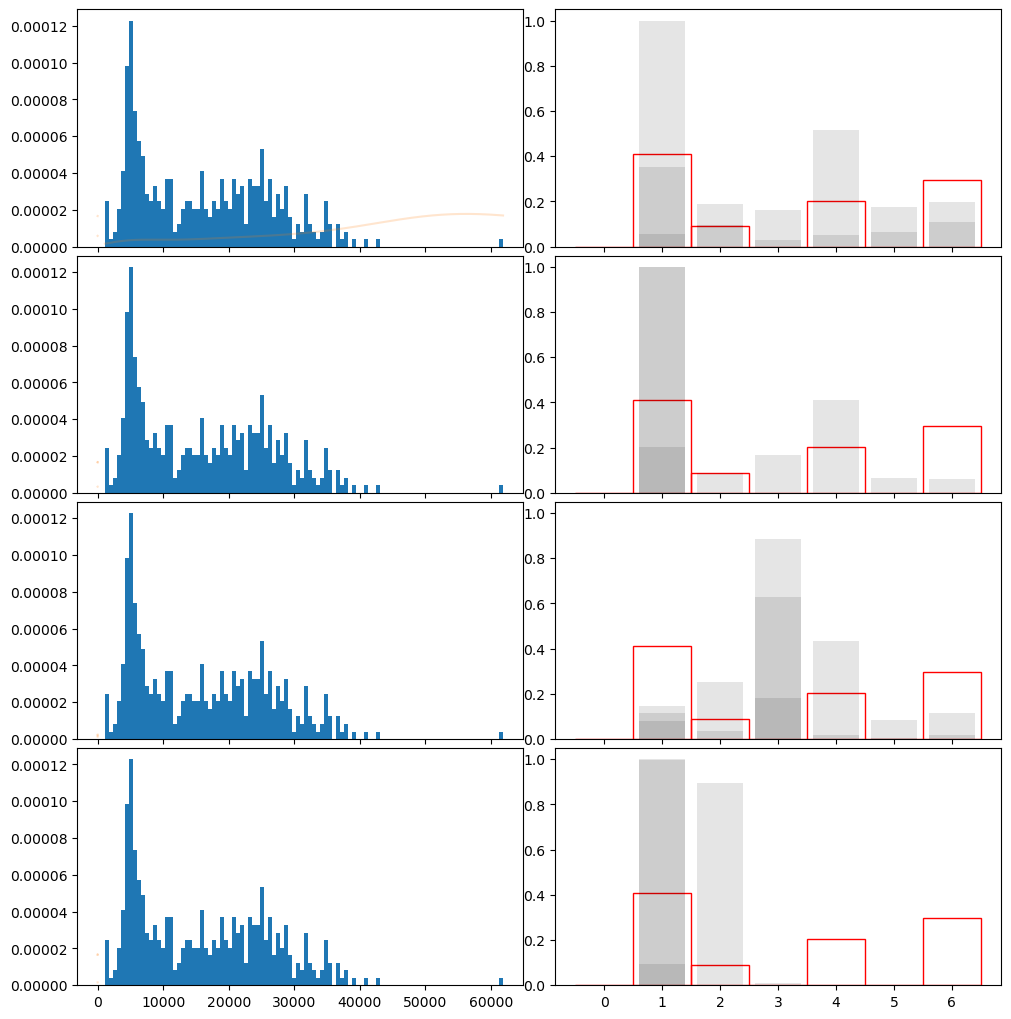

In [73]:
environ["STAN_NUM_THREADS"] = str(4 * num_threads_per_chain)
alphas = 10.0 ** np.linspace(-1.5, 0.0, 4)

inits = []
for i, name in enumerate(combined_approx_ra_monomeric_model_fit_ra.column_names[7:10]):
    inits.append(
        (
            name,
            np.mean(
                combined_approx_ra_monomeric_model_fit_ra.draws().reshape(
                    -1, combined_approx_ra_monomeric_model_fit_ra.draws().shape[-1]
                )[:, i]
            ),
        )
    )
inits = dict(inits)

f, axes = plt.subplots(alphas.shape[0], 2, sharex="col", sharey="col", figsize=(10, 10))
xvals = np.linspace(overall_intensity_min_ra, np.max(method1_intensities_ra), 10000)

for a, alpha in enumerate(alphas):
    axes[a, 0].hist(method1_intensities_ra, bins=data["num_spots"] // 4, density=True)
    axes[a, 1].hist(
        num_fluorophores,
        bins=np.arange(np.max(oligomeric_states) + 2) - 0.5,
        color=(0, 0, 0, 0),
        edgecolor="red",
        density=True,
    )
    data = {
        "num_spots": method1_intensities_ra.shape[0],
        "num_monomeric_spots": method1_intensities_monomeric.shape[0],
        "highest_oligomer": 6,
        "spot_intensities": method1_intensities_ra - overall_intensity_min_ra,
        "monomeric_spot_intensities": method1_intensities_monomeric - overall_intensity_min_ra,
        "prior_alpha": alpha,
    }
    opts = []
    while len(opts) < 3:
        try:
            opt = combined_approx_ra_monomeric_prior_model.optimize(
                data, inits=inits
            ).optimized_params_dict
        except:
            continue
        p_oligomer = [
            opt["p_oligomer[" + str(i + 1) + "]"] for i in range(data["highest_oligomer"])
        ]
        oligomeric_combo = np.arange(data["highest_oligomer"]) + 1
        yvals = approx_ra_pdf(
            xvals,
            overall_intensity_min_ra,
            oligomeric_combo,
            p_oligomer,
            opt["background_level"],
            opt["monomer_mu"],
            opt["sigma"],
        )

        if np.max(yvals) > 1e-6:
            print(opt)
            opts.append(opt)
        else:
            continue
        axes[a, 0].plot(xvals, yvals, alpha=0.2, color="C1")

        xvals = np.arange(data["highest_oligomer"]) + 1
        heights = [opt["p_oligomer[" + str(i + 1) + "]"] for i in range(data["highest_oligomer"])]
        axes[a, 1].bar(xvals, heights, color="black", alpha=0.1)

f.tight_layout(pad=0.0)

environ["STAN_NUM_THREADS"] = ""